In [1]:
from PIL import Image
import numpy as np
import time
import os
import json
from tqdm import tqdm

In [2]:
data_path = 'deepfashion2_dataset/train/'

with open(data_path + 'all_data.json', 'r') as json_file:
    json_data = json.load(json_file)
    json_file.close()

In [3]:
print(json_data['0'])

{'path': '/train/image/000001.jpg', 'item2': [[249, 423, 466, 623], 8], 'item1': [[0, 29, 466, 622], 1]}


In [4]:
deepfashion2_data = {}
for key in json_data:
    deepfashion2_data[int(key)] = json_data[key]
    

In [5]:
print(deepfashion2_data[10]) #anno 000011.json 확인

{'path': '/train/image/000011.jpg', 'item2': [[284, 548, 458, 851], 8], 'item1': [[256, 393, 369, 608], 2]}


In [6]:
import random
random.seed(100)
print(len(deepfashion2_data))
deepfashion2_data_1 = dict(list(deepfashion2_data.items())[:50000])


191961


In [7]:
print(len(deepfashion2_data))

191961


In [8]:
print(len(deepfashion2_data_1[49999]))

3


In [9]:
cat = {}
for i in range(13):
    cat[i+1] = 0


for img in range(len(deepfashion2_data_1)):
    num_objs = len(deepfashion2_data_1[img])-1
    for obj in range(num_objs):
        for c in range(13):
            if deepfashion2_data_1[img]['item'+str(obj+1)][1] == c+1:
                cat[c+1] += 1

In [10]:
print(cat)

{1: 18535, 2: 9374, 3: 103, 4: 3586, 5: 4323, 6: 538, 7: 9526, 8: 14757, 9: 7845, 10: 4079, 11: 2098, 12: 4883, 13: 1792}


In [11]:
%%shell
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python cocoapi/PythonAPI/setup.py build_ext install

UsageError: Cell magic `%%shell` not found.


In [12]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

In [13]:
class DeepfashionDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, transforms = None):
    self.dataset = dataset
    self.transforms = transforms
  def __getitem__(self, idx):
    img_path= os.path.join('deepfashion2_dataset'+self.dataset[idx]['path'])
    img = Image.open(img_path).convert("RGB")
    
    num_objs = len(self.dataset[idx])-1
    labels = torch.ones((num_objs,), dtype=torch.int64)
    boxes = []
    for i in range(num_objs):
        boxes.append(self.dataset[idx]['item'+str(i+1)][0])
        labels[i] = self.dataset[idx]['item'+str(i+1)][1]
    
    
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype = torch.int64)
    image_id = torch.tensor([idx])
    area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
    
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
    
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    #target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd
    
    if self.transforms is not None:
        img, target = self.transforms(img, target)

    return img, target
  
  def __len__(self):
    return len(self.dataset)

In [14]:
dataset = DeepfashionDataset(deepfashion2_data_1)

In [15]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=468x624 at 0x7F35F0C71110>,
 {'boxes': tensor([[  0.,  29., 466., 622.],
          [249., 423., 466., 623.]]),
  'labels': tensor([1, 8]),
  'image_id': tensor([0]),
  'area': tensor([276338.,  43400.]),
  'iscrowd': tensor([0, 0])})

In [16]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_faster_rcnn(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  num_classes = 14  # 2 class + background

  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  
  return model

In [17]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

UsageError: Cell magic `%%shell` not found.


In [18]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [19]:
dataset = DeepfashionDataset(deepfashion2_data_1, get_transform(train = True))
dataset_test = DeepfashionDataset(deepfashion2_data_1, get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-300])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-300:])
                                  
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
PATH = './model/'

# our dataset has two classes only - background and person
num_classes = 14 #num_class + 1

model = get_faster_rcnn(num_classes)
model.load_state_dict(torch.load(PATH+'deepfashion2_model_data_2_'+str(1)+'.pth'))
#model.load_state_dict(torch.load(PATH+'model'+str(epoch)+'.pth'))
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
print(params)

[Parameter containing:
tensor([[[[ 3.4088e-04]],

         [[-1.8732e-03]],

         [[ 4.0281e-03]],

         ...,

         [[-8.8492e-04]],

         [[-3.0013e-03]],

         [[-4.4852e-03]]],


        [[[-3.8901e-03]],

         [[-5.5474e-03]],

         [[-1.8564e-02]],

         ...,

         [[ 5.4075e-03]],

         [[ 9.1815e-03]],

         [[-6.7238e-03]]],


        [[[ 8.5090e-03]],

         [[ 2.1638e-03]],

         [[-1.2522e-02]],

         ...,

         [[ 7.4729e-03]],

         [[-1.6271e-02]],

         [[ 2.8816e-03]]],


        ...,


        [[[ 3.5952e-03]],

         [[ 6.7045e-03]],

         [[-1.5537e-02]],

         ...,

         [[-5.9242e-04]],

         [[ 2.4354e-02]],

         [[ 3.0696e-03]]],


        [[[-1.0501e-02]],

         [[-3.7619e-03]],

         [[ 4.8202e-02]],

         ...,

         [[-5.9035e-03]],

         [[-4.1303e-03]],

         [[ 8.2784e-03]]],


        [[[-9.1439e-05]],

         [[-1.6558e-03]],

         [[ 5

In [20]:
num_epochs = 10
PATH = './model/'
model.train()
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    torch.save(model.state_dict(), PATH+'deepfashion2_data_50000_'+str(epoch)+'.pth')

Epoch: [0]  [    0/24850]  eta: 10:54:10  lr: 0.000010  loss: 0.2580 (0.2580)  loss_classifier: 0.1724 (0.1724)  loss_box_reg: 0.0696 (0.0696)  loss_objectness: 0.0061 (0.0061)  loss_rpn_box_reg: 0.0100 (0.0100)  time: 1.5795  data: 0.1403  max mem: 1956
Epoch: [0]  [   10/24850]  eta: 4:15:23  lr: 0.000060  loss: 0.1775 (0.1796)  loss_classifier: 0.1001 (0.1131)  loss_box_reg: 0.0480 (0.0459)  loss_objectness: 0.0044 (0.0043)  loss_rpn_box_reg: 0.0124 (0.0164)  time: 0.6169  data: 0.0168  max mem: 3871
Epoch: [0]  [   20/24850]  eta: 3:56:02  lr: 0.000110  loss: 0.1544 (0.1774)  loss_classifier: 0.0993 (0.1177)  loss_box_reg: 0.0386 (0.0429)  loss_objectness: 0.0035 (0.0037)  loss_rpn_box_reg: 0.0109 (0.0131)  time: 0.5199  data: 0.0040  max mem: 3871
Epoch: [0]  [   30/24850]  eta: 3:51:59  lr: 0.000160  loss: 0.1544 (0.1743)  loss_classifier: 0.0993 (0.1142)  loss_box_reg: 0.0267 (0.0402)  loss_objectness: 0.0028 (0.0041)  loss_rpn_box_reg: 0.0103 (0.0158)  time: 0.5300  data: 0.003

Epoch: [0]  [  330/24850]  eta: 3:37:09  lr: 0.001658  loss: 0.1253 (0.1486)  loss_classifier: 0.0873 (0.0964)  loss_box_reg: 0.0214 (0.0331)  loss_objectness: 0.0018 (0.0043)  loss_rpn_box_reg: 0.0065 (0.0150)  time: 0.5080  data: 0.0033  max mem: 4332
Epoch: [0]  [  340/24850]  eta: 3:36:45  lr: 0.001708  loss: 0.1293 (0.1486)  loss_classifier: 0.0816 (0.0963)  loss_box_reg: 0.0334 (0.0331)  loss_objectness: 0.0034 (0.0043)  loss_rpn_box_reg: 0.0085 (0.0148)  time: 0.4999  data: 0.0033  max mem: 4332
Epoch: [0]  [  350/24850]  eta: 3:36:41  lr: 0.001758  loss: 0.1196 (0.1478)  loss_classifier: 0.0785 (0.0958)  loss_box_reg: 0.0309 (0.0329)  loss_objectness: 0.0025 (0.0043)  loss_rpn_box_reg: 0.0118 (0.0148)  time: 0.5189  data: 0.0034  max mem: 4354
Epoch: [0]  [  360/24850]  eta: 3:36:37  lr: 0.001808  loss: 0.1251 (0.1485)  loss_classifier: 0.0714 (0.0962)  loss_box_reg: 0.0213 (0.0328)  loss_objectness: 0.0040 (0.0044)  loss_rpn_box_reg: 0.0127 (0.0150)  time: 0.5324  data: 0.0034

Epoch: [0]  [  660/24850]  eta: 3:34:56  lr: 0.003307  loss: 0.1666 (0.1508)  loss_classifier: 0.1005 (0.0971)  loss_box_reg: 0.0388 (0.0330)  loss_objectness: 0.0048 (0.0044)  loss_rpn_box_reg: 0.0130 (0.0163)  time: 0.5531  data: 0.0033  max mem: 4434
Epoch: [0]  [  670/24850]  eta: 3:35:04  lr: 0.003357  loss: 0.1893 (0.1513)  loss_classifier: 0.1046 (0.0976)  loss_box_reg: 0.0397 (0.0331)  loss_objectness: 0.0044 (0.0044)  loss_rpn_box_reg: 0.0108 (0.0163)  time: 0.5637  data: 0.0034  max mem: 4477
Epoch: [0]  [  680/24850]  eta: 3:35:01  lr: 0.003407  loss: 0.1537 (0.1517)  loss_classifier: 0.0954 (0.0978)  loss_box_reg: 0.0372 (0.0333)  loss_objectness: 0.0033 (0.0044)  loss_rpn_box_reg: 0.0087 (0.0162)  time: 0.5551  data: 0.0034  max mem: 4477
Epoch: [0]  [  690/24850]  eta: 3:35:18  lr: 0.003457  loss: 0.1739 (0.1523)  loss_classifier: 0.1108 (0.0981)  loss_box_reg: 0.0394 (0.0335)  loss_objectness: 0.0039 (0.0044)  loss_rpn_box_reg: 0.0133 (0.0163)  time: 0.5696  data: 0.0033

Epoch: [0]  [  990/24850]  eta: 3:31:13  lr: 0.004955  loss: 0.1528 (0.1558)  loss_classifier: 0.0942 (0.1002)  loss_box_reg: 0.0323 (0.0351)  loss_objectness: 0.0033 (0.0042)  loss_rpn_box_reg: 0.0131 (0.0163)  time: 0.5135  data: 0.0034  max mem: 4561
Epoch: [0]  [ 1000/24850]  eta: 3:31:05  lr: 0.005000  loss: 0.1239 (0.1556)  loss_classifier: 0.0830 (0.1002)  loss_box_reg: 0.0293 (0.0350)  loss_objectness: 0.0022 (0.0041)  loss_rpn_box_reg: 0.0133 (0.0163)  time: 0.5133  data: 0.0034  max mem: 4561
Epoch: [0]  [ 1010/24850]  eta: 3:30:51  lr: 0.005000  loss: 0.1241 (0.1557)  loss_classifier: 0.0861 (0.1002)  loss_box_reg: 0.0271 (0.0351)  loss_objectness: 0.0022 (0.0041)  loss_rpn_box_reg: 0.0131 (0.0163)  time: 0.5073  data: 0.0035  max mem: 4561
Epoch: [0]  [ 1020/24850]  eta: 3:30:46  lr: 0.005000  loss: 0.1321 (0.1559)  loss_classifier: 0.0872 (0.1004)  loss_box_reg: 0.0277 (0.0351)  loss_objectness: 0.0022 (0.0041)  loss_rpn_box_reg: 0.0116 (0.0163)  time: 0.5125  data: 0.0035

Epoch: [0]  [ 1320/24850]  eta: 3:28:25  lr: 0.005000  loss: 0.1520 (0.1611)  loss_classifier: 0.0924 (0.1038)  loss_box_reg: 0.0302 (0.0364)  loss_objectness: 0.0019 (0.0043)  loss_rpn_box_reg: 0.0114 (0.0166)  time: 0.5205  data: 0.0034  max mem: 4620
Epoch: [0]  [ 1330/24850]  eta: 3:28:18  lr: 0.005000  loss: 0.1376 (0.1610)  loss_classifier: 0.0834 (0.1037)  loss_box_reg: 0.0302 (0.0363)  loss_objectness: 0.0023 (0.0043)  loss_rpn_box_reg: 0.0115 (0.0166)  time: 0.5203  data: 0.0035  max mem: 4620
Epoch: [0]  [ 1340/24850]  eta: 3:28:10  lr: 0.005000  loss: 0.1525 (0.1612)  loss_classifier: 0.0912 (0.1039)  loss_box_reg: 0.0311 (0.0364)  loss_objectness: 0.0024 (0.0043)  loss_rpn_box_reg: 0.0114 (0.0166)  time: 0.5199  data: 0.0036  max mem: 4620
Epoch: [0]  [ 1350/24850]  eta: 3:28:09  lr: 0.005000  loss: 0.1532 (0.1611)  loss_classifier: 0.1019 (0.1039)  loss_box_reg: 0.0300 (0.0363)  loss_objectness: 0.0019 (0.0043)  loss_rpn_box_reg: 0.0111 (0.0166)  time: 0.5349  data: 0.0034

Epoch: [0]  [ 1650/24850]  eta: 3:25:15  lr: 0.005000  loss: 0.1676 (0.1633)  loss_classifier: 0.1019 (0.1054)  loss_box_reg: 0.0307 (0.0370)  loss_objectness: 0.0027 (0.0043)  loss_rpn_box_reg: 0.0136 (0.0167)  time: 0.5628  data: 0.0033  max mem: 4782
Epoch: [0]  [ 1660/24850]  eta: 3:25:09  lr: 0.005000  loss: 0.1476 (0.1632)  loss_classifier: 0.0941 (0.1053)  loss_box_reg: 0.0335 (0.0369)  loss_objectness: 0.0027 (0.0043)  loss_rpn_box_reg: 0.0133 (0.0167)  time: 0.5596  data: 0.0033  max mem: 4782
Epoch: [0]  [ 1670/24850]  eta: 3:25:00  lr: 0.005000  loss: 0.1392 (0.1630)  loss_classifier: 0.0800 (0.1052)  loss_box_reg: 0.0248 (0.0369)  loss_objectness: 0.0024 (0.0043)  loss_rpn_box_reg: 0.0113 (0.0167)  time: 0.5176  data: 0.0034  max mem: 4782
Epoch: [0]  [ 1680/24850]  eta: 3:24:52  lr: 0.005000  loss: 0.1395 (0.1631)  loss_classifier: 0.0854 (0.1052)  loss_box_reg: 0.0316 (0.0369)  loss_objectness: 0.0031 (0.0043)  loss_rpn_box_reg: 0.0112 (0.0167)  time: 0.5098  data: 0.0035

Epoch: [0]  [ 1980/24850]  eta: 3:21:52  lr: 0.005000  loss: 0.1690 (0.1658)  loss_classifier: 0.1031 (0.1065)  loss_box_reg: 0.0471 (0.0377)  loss_objectness: 0.0048 (0.0047)  loss_rpn_box_reg: 0.0125 (0.0169)  time: 0.5082  data: 0.0036  max mem: 4794
Epoch: [0]  [ 1990/24850]  eta: 3:21:45  lr: 0.005000  loss: 0.1690 (0.1659)  loss_classifier: 0.1031 (0.1066)  loss_box_reg: 0.0408 (0.0377)  loss_objectness: 0.0034 (0.0047)  loss_rpn_box_reg: 0.0115 (0.0169)  time: 0.5205  data: 0.0035  max mem: 4794
Epoch: [0]  [ 2000/24850]  eta: 3:21:44  lr: 0.005000  loss: 0.1459 (0.1658)  loss_classifier: 0.1034 (0.1065)  loss_box_reg: 0.0273 (0.0377)  loss_objectness: 0.0031 (0.0047)  loss_rpn_box_reg: 0.0129 (0.0170)  time: 0.5414  data: 0.0034  max mem: 4794
Epoch: [0]  [ 2010/24850]  eta: 3:21:37  lr: 0.005000  loss: 0.1312 (0.1658)  loss_classifier: 0.0896 (0.1065)  loss_box_reg: 0.0224 (0.0377)  loss_objectness: 0.0022 (0.0047)  loss_rpn_box_reg: 0.0123 (0.0170)  time: 0.5417  data: 0.0034

Epoch: [0]  [ 2310/24850]  eta: 3:18:55  lr: 0.005000  loss: 0.1498 (0.1671)  loss_classifier: 0.0905 (0.1073)  loss_box_reg: 0.0250 (0.0379)  loss_objectness: 0.0026 (0.0047)  loss_rpn_box_reg: 0.0144 (0.0172)  time: 0.5337  data: 0.0034  max mem: 5146
Epoch: [0]  [ 2320/24850]  eta: 3:18:51  lr: 0.005000  loss: 0.1552 (0.1673)  loss_classifier: 0.1076 (0.1074)  loss_box_reg: 0.0242 (0.0379)  loss_objectness: 0.0026 (0.0047)  loss_rpn_box_reg: 0.0126 (0.0172)  time: 0.5235  data: 0.0033  max mem: 5146
Epoch: [0]  [ 2330/24850]  eta: 3:18:48  lr: 0.005000  loss: 0.1302 (0.1671)  loss_classifier: 0.0759 (0.1073)  loss_box_reg: 0.0349 (0.0379)  loss_objectness: 0.0038 (0.0047)  loss_rpn_box_reg: 0.0108 (0.0172)  time: 0.5472  data: 0.0034  max mem: 5146
Epoch: [0]  [ 2340/24850]  eta: 3:18:43  lr: 0.005000  loss: 0.1145 (0.1669)  loss_classifier: 0.0605 (0.1072)  loss_box_reg: 0.0282 (0.0378)  loss_objectness: 0.0030 (0.0047)  loss_rpn_box_reg: 0.0140 (0.0172)  time: 0.5397  data: 0.0034

Epoch: [0]  [ 2640/24850]  eta: 3:16:00  lr: 0.005000  loss: 0.1482 (0.1675)  loss_classifier: 0.0914 (0.1075)  loss_box_reg: 0.0354 (0.0381)  loss_objectness: 0.0032 (0.0047)  loss_rpn_box_reg: 0.0139 (0.0172)  time: 0.5529  data: 0.0034  max mem: 5146
Epoch: [0]  [ 2650/24850]  eta: 3:15:54  lr: 0.005000  loss: 0.1742 (0.1676)  loss_classifier: 0.1111 (0.1076)  loss_box_reg: 0.0354 (0.0381)  loss_objectness: 0.0020 (0.0047)  loss_rpn_box_reg: 0.0141 (0.0172)  time: 0.5587  data: 0.0034  max mem: 5146
Epoch: [0]  [ 2660/24850]  eta: 3:15:48  lr: 0.005000  loss: 0.1654 (0.1677)  loss_classifier: 0.0986 (0.1076)  loss_box_reg: 0.0332 (0.0381)  loss_objectness: 0.0020 (0.0047)  loss_rpn_box_reg: 0.0180 (0.0173)  time: 0.5248  data: 0.0033  max mem: 5146
Epoch: [0]  [ 2670/24850]  eta: 3:15:40  lr: 0.005000  loss: 0.1772 (0.1679)  loss_classifier: 0.1037 (0.1077)  loss_box_reg: 0.0283 (0.0381)  loss_objectness: 0.0051 (0.0047)  loss_rpn_box_reg: 0.0186 (0.0173)  time: 0.5073  data: 0.0033

Epoch: [0]  [ 2970/24850]  eta: 3:12:54  lr: 0.005000  loss: 0.1689 (0.1675)  loss_classifier: 0.0991 (0.1075)  loss_box_reg: 0.0276 (0.0380)  loss_objectness: 0.0033 (0.0047)  loss_rpn_box_reg: 0.0125 (0.0173)  time: 0.5472  data: 0.0033  max mem: 5146
Epoch: [0]  [ 2980/24850]  eta: 3:12:50  lr: 0.005000  loss: 0.1398 (0.1674)  loss_classifier: 0.0991 (0.1075)  loss_box_reg: 0.0276 (0.0380)  loss_objectness: 0.0051 (0.0047)  loss_rpn_box_reg: 0.0107 (0.0173)  time: 0.5609  data: 0.0034  max mem: 5146
Epoch: [0]  [ 2990/24850]  eta: 3:12:47  lr: 0.005000  loss: 0.1398 (0.1673)  loss_classifier: 0.0950 (0.1074)  loss_box_reg: 0.0285 (0.0380)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0111 (0.0173)  time: 0.5528  data: 0.0035  max mem: 5146
Epoch: [0]  [ 3000/24850]  eta: 3:12:42  lr: 0.005000  loss: 0.1398 (0.1672)  loss_classifier: 0.0950 (0.1074)  loss_box_reg: 0.0247 (0.0379)  loss_objectness: 0.0018 (0.0047)  loss_rpn_box_reg: 0.0111 (0.0172)  time: 0.5408  data: 0.0035

Epoch: [0]  [ 3300/24850]  eta: 3:09:56  lr: 0.005000  loss: 0.1254 (0.1671)  loss_classifier: 0.0736 (0.1072)  loss_box_reg: 0.0213 (0.0379)  loss_objectness: 0.0018 (0.0047)  loss_rpn_box_reg: 0.0165 (0.0173)  time: 0.5304  data: 0.0033  max mem: 5146
Epoch: [0]  [ 3310/24850]  eta: 3:09:50  lr: 0.005000  loss: 0.1443 (0.1671)  loss_classifier: 0.0803 (0.1073)  loss_box_reg: 0.0217 (0.0379)  loss_objectness: 0.0017 (0.0046)  loss_rpn_box_reg: 0.0166 (0.0173)  time: 0.5316  data: 0.0033  max mem: 5146
Epoch: [0]  [ 3320/24850]  eta: 3:09:47  lr: 0.005000  loss: 0.1443 (0.1671)  loss_classifier: 0.0815 (0.1073)  loss_box_reg: 0.0268 (0.0379)  loss_objectness: 0.0016 (0.0046)  loss_rpn_box_reg: 0.0127 (0.0173)  time: 0.5369  data: 0.0034  max mem: 5146
Epoch: [0]  [ 3330/24850]  eta: 3:09:40  lr: 0.005000  loss: 0.1506 (0.1671)  loss_classifier: 0.0946 (0.1073)  loss_box_reg: 0.0347 (0.0379)  loss_objectness: 0.0024 (0.0046)  loss_rpn_box_reg: 0.0109 (0.0172)  time: 0.5383  data: 0.0034

Epoch: [0]  [ 3630/24850]  eta: 3:07:25  lr: 0.005000  loss: 0.1702 (0.1685)  loss_classifier: 0.1030 (0.1081)  loss_box_reg: 0.0393 (0.0384)  loss_objectness: 0.0023 (0.0047)  loss_rpn_box_reg: 0.0129 (0.0172)  time: 0.5674  data: 0.0033  max mem: 5146
Epoch: [0]  [ 3640/24850]  eta: 3:07:23  lr: 0.005000  loss: 0.1986 (0.1686)  loss_classifier: 0.1230 (0.1083)  loss_box_reg: 0.0487 (0.0384)  loss_objectness: 0.0023 (0.0047)  loss_rpn_box_reg: 0.0129 (0.0173)  time: 0.5679  data: 0.0034  max mem: 5146
Epoch: [0]  [ 3650/24850]  eta: 3:07:18  lr: 0.005000  loss: 0.1774 (0.1686)  loss_classifier: 0.1097 (0.1082)  loss_box_reg: 0.0422 (0.0384)  loss_objectness: 0.0026 (0.0047)  loss_rpn_box_reg: 0.0113 (0.0173)  time: 0.5631  data: 0.0035  max mem: 5146
Epoch: [0]  [ 3660/24850]  eta: 3:07:12  lr: 0.005000  loss: 0.1635 (0.1687)  loss_classifier: 0.1096 (0.1083)  loss_box_reg: 0.0422 (0.0385)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0113 (0.0173)  time: 0.5292  data: 0.0034

Epoch: [0]  [ 3960/24850]  eta: 3:04:47  lr: 0.005000  loss: 0.1901 (0.1688)  loss_classifier: 0.1066 (0.1082)  loss_box_reg: 0.0406 (0.0385)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0107 (0.0173)  time: 0.5702  data: 0.0034  max mem: 5146
Epoch: [0]  [ 3970/24850]  eta: 3:04:40  lr: 0.005000  loss: 0.1555 (0.1687)  loss_classifier: 0.1061 (0.1082)  loss_box_reg: 0.0400 (0.0385)  loss_objectness: 0.0023 (0.0047)  loss_rpn_box_reg: 0.0102 (0.0173)  time: 0.5441  data: 0.0035  max mem: 5146
Epoch: [0]  [ 3980/24850]  eta: 3:04:34  lr: 0.005000  loss: 0.1548 (0.1688)  loss_classifier: 0.1101 (0.1082)  loss_box_reg: 0.0386 (0.0385)  loss_objectness: 0.0023 (0.0047)  loss_rpn_box_reg: 0.0104 (0.0173)  time: 0.5110  data: 0.0034  max mem: 5146
Epoch: [0]  [ 3990/24850]  eta: 3:04:29  lr: 0.005000  loss: 0.1508 (0.1687)  loss_classifier: 0.0889 (0.1082)  loss_box_reg: 0.0261 (0.0385)  loss_objectness: 0.0022 (0.0047)  loss_rpn_box_reg: 0.0104 (0.0173)  time: 0.5217  data: 0.0033

Epoch: [0]  [ 4290/24850]  eta: 3:02:12  lr: 0.005000  loss: 0.1676 (0.1692)  loss_classifier: 0.1155 (0.1087)  loss_box_reg: 0.0375 (0.0386)  loss_objectness: 0.0020 (0.0047)  loss_rpn_box_reg: 0.0110 (0.0173)  time: 0.5737  data: 0.0035  max mem: 5146
Epoch: [0]  [ 4300/24850]  eta: 3:02:05  lr: 0.005000  loss: 0.1390 (0.1692)  loss_classifier: 0.0894 (0.1087)  loss_box_reg: 0.0324 (0.0386)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0093 (0.0173)  time: 0.5281  data: 0.0035  max mem: 5146
Epoch: [0]  [ 4310/24850]  eta: 3:01:59  lr: 0.005000  loss: 0.1517 (0.1694)  loss_classifier: 0.1008 (0.1088)  loss_box_reg: 0.0369 (0.0386)  loss_objectness: 0.0026 (0.0047)  loss_rpn_box_reg: 0.0093 (0.0173)  time: 0.5023  data: 0.0035  max mem: 5146
Epoch: [0]  [ 4320/24850]  eta: 3:01:53  lr: 0.005000  loss: 0.1475 (0.1693)  loss_classifier: 0.0987 (0.1088)  loss_box_reg: 0.0313 (0.0386)  loss_objectness: 0.0043 (0.0047)  loss_rpn_box_reg: 0.0121 (0.0173)  time: 0.5137  data: 0.0035

Epoch: [0]  [ 4620/24850]  eta: 2:59:27  lr: 0.005000  loss: 0.1233 (0.1694)  loss_classifier: 0.0752 (0.1089)  loss_box_reg: 0.0301 (0.0386)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0124 (0.0173)  time: 0.5243  data: 0.0035  max mem: 5146
Epoch: [0]  [ 4630/24850]  eta: 2:59:21  lr: 0.005000  loss: 0.1314 (0.1694)  loss_classifier: 0.0749 (0.1089)  loss_box_reg: 0.0344 (0.0386)  loss_objectness: 0.0019 (0.0047)  loss_rpn_box_reg: 0.0117 (0.0173)  time: 0.5182  data: 0.0035  max mem: 5146
Epoch: [0]  [ 4640/24850]  eta: 2:59:16  lr: 0.005000  loss: 0.1532 (0.1695)  loss_classifier: 0.0927 (0.1089)  loss_box_reg: 0.0344 (0.0386)  loss_objectness: 0.0019 (0.0047)  loss_rpn_box_reg: 0.0104 (0.0173)  time: 0.5329  data: 0.0034  max mem: 5146
Epoch: [0]  [ 4650/24850]  eta: 2:59:11  lr: 0.005000  loss: 0.1788 (0.1695)  loss_classifier: 0.1059 (0.1089)  loss_box_reg: 0.0345 (0.0386)  loss_objectness: 0.0023 (0.0047)  loss_rpn_box_reg: 0.0099 (0.0173)  time: 0.5358  data: 0.0034

Epoch: [0]  [ 4950/24850]  eta: 2:56:40  lr: 0.005000  loss: 0.1529 (0.1701)  loss_classifier: 0.0811 (0.1091)  loss_box_reg: 0.0350 (0.0387)  loss_objectness: 0.0112 (0.0049)  loss_rpn_box_reg: 0.0165 (0.0174)  time: 0.5594  data: 0.0034  max mem: 5146
Epoch: [0]  [ 4960/24850]  eta: 2:56:34  lr: 0.005000  loss: 0.1561 (0.1701)  loss_classifier: 0.0811 (0.1091)  loss_box_reg: 0.0388 (0.0387)  loss_objectness: 0.0117 (0.0049)  loss_rpn_box_reg: 0.0165 (0.0174)  time: 0.5353  data: 0.0034  max mem: 5146
Epoch: [0]  [ 4970/24850]  eta: 2:56:28  lr: 0.005000  loss: 0.1399 (0.1700)  loss_classifier: 0.0668 (0.1090)  loss_box_reg: 0.0369 (0.0387)  loss_objectness: 0.0099 (0.0049)  loss_rpn_box_reg: 0.0118 (0.0174)  time: 0.5212  data: 0.0034  max mem: 5146
Epoch: [0]  [ 4980/24850]  eta: 2:56:24  lr: 0.005000  loss: 0.1143 (0.1699)  loss_classifier: 0.0668 (0.1090)  loss_box_reg: 0.0224 (0.0386)  loss_objectness: 0.0119 (0.0050)  loss_rpn_box_reg: 0.0107 (0.0174)  time: 0.5399  data: 0.0033

Epoch: [0]  [ 5280/24850]  eta: 2:53:51  lr: 0.005000  loss: 0.1334 (0.1691)  loss_classifier: 0.0820 (0.1082)  loss_box_reg: 0.0262 (0.0384)  loss_objectness: 0.0037 (0.0050)  loss_rpn_box_reg: 0.0116 (0.0175)  time: 0.5479  data: 0.0034  max mem: 5146
Epoch: [0]  [ 5290/24850]  eta: 2:53:48  lr: 0.005000  loss: 0.1682 (0.1692)  loss_classifier: 0.0926 (0.1083)  loss_box_reg: 0.0326 (0.0384)  loss_objectness: 0.0039 (0.0050)  loss_rpn_box_reg: 0.0147 (0.0175)  time: 0.5520  data: 0.0034  max mem: 5146
Epoch: [0]  [ 5300/24850]  eta: 2:53:44  lr: 0.005000  loss: 0.1871 (0.1693)  loss_classifier: 0.1276 (0.1083)  loss_box_reg: 0.0461 (0.0385)  loss_objectness: 0.0026 (0.0050)  loss_rpn_box_reg: 0.0124 (0.0175)  time: 0.5724  data: 0.0034  max mem: 5146
Epoch: [0]  [ 5310/24850]  eta: 2:53:39  lr: 0.005000  loss: 0.1501 (0.1692)  loss_classifier: 0.0926 (0.1083)  loss_box_reg: 0.0302 (0.0384)  loss_objectness: 0.0048 (0.0050)  loss_rpn_box_reg: 0.0132 (0.0175)  time: 0.5629  data: 0.0035

Epoch: [0]  [ 5610/24850]  eta: 2:51:09  lr: 0.005000  loss: 0.1982 (0.1697)  loss_classifier: 0.1303 (0.1088)  loss_box_reg: 0.0353 (0.0385)  loss_objectness: 0.0028 (0.0050)  loss_rpn_box_reg: 0.0103 (0.0173)  time: 0.5492  data: 0.0036  max mem: 5358
Epoch: [0]  [ 5620/24850]  eta: 2:51:05  lr: 0.005000  loss: 0.1654 (0.1697)  loss_classifier: 0.1023 (0.1088)  loss_box_reg: 0.0343 (0.0385)  loss_objectness: 0.0031 (0.0050)  loss_rpn_box_reg: 0.0103 (0.0174)  time: 0.5643  data: 0.0034  max mem: 5358
Epoch: [0]  [ 5630/24850]  eta: 2:51:00  lr: 0.005000  loss: 0.1637 (0.1698)  loss_classifier: 0.1023 (0.1088)  loss_box_reg: 0.0343 (0.0385)  loss_objectness: 0.0033 (0.0050)  loss_rpn_box_reg: 0.0187 (0.0174)  time: 0.5610  data: 0.0033  max mem: 5358
Epoch: [0]  [ 5640/24850]  eta: 2:50:55  lr: 0.005000  loss: 0.1519 (0.1697)  loss_classifier: 0.0971 (0.1088)  loss_box_reg: 0.0287 (0.0385)  loss_objectness: 0.0033 (0.0050)  loss_rpn_box_reg: 0.0113 (0.0174)  time: 0.5427  data: 0.0034

Epoch: [0]  [ 5940/24850]  eta: 2:48:24  lr: 0.005000  loss: 0.1337 (0.1701)  loss_classifier: 0.0768 (0.1091)  loss_box_reg: 0.0303 (0.0386)  loss_objectness: 0.0034 (0.0050)  loss_rpn_box_reg: 0.0124 (0.0174)  time: 0.5255  data: 0.0034  max mem: 5358
Epoch: [0]  [ 5950/24850]  eta: 2:48:20  lr: 0.005000  loss: 0.1383 (0.1701)  loss_classifier: 0.0799 (0.1090)  loss_box_reg: 0.0261 (0.0385)  loss_objectness: 0.0034 (0.0050)  loss_rpn_box_reg: 0.0139 (0.0175)  time: 0.5610  data: 0.0033  max mem: 5358
Epoch: [0]  [ 5960/24850]  eta: 2:48:15  lr: 0.005000  loss: 0.1334 (0.1700)  loss_classifier: 0.0805 (0.1090)  loss_box_reg: 0.0277 (0.0385)  loss_objectness: 0.0015 (0.0050)  loss_rpn_box_reg: 0.0101 (0.0174)  time: 0.5654  data: 0.0034  max mem: 5358
Epoch: [0]  [ 5970/24850]  eta: 2:48:09  lr: 0.005000  loss: 0.1345 (0.1700)  loss_classifier: 0.0844 (0.1090)  loss_box_reg: 0.0304 (0.0385)  loss_objectness: 0.0013 (0.0050)  loss_rpn_box_reg: 0.0112 (0.0175)  time: 0.5420  data: 0.0035

Epoch: [0]  [ 6270/24850]  eta: 2:45:32  lr: 0.005000  loss: 0.1457 (0.1697)  loss_classifier: 0.0980 (0.1088)  loss_box_reg: 0.0276 (0.0385)  loss_objectness: 0.0020 (0.0050)  loss_rpn_box_reg: 0.0132 (0.0175)  time: 0.5371  data: 0.0034  max mem: 5358
Epoch: [0]  [ 6280/24850]  eta: 2:45:26  lr: 0.005000  loss: 0.1441 (0.1698)  loss_classifier: 0.0980 (0.1088)  loss_box_reg: 0.0285 (0.0385)  loss_objectness: 0.0035 (0.0050)  loss_rpn_box_reg: 0.0120 (0.0175)  time: 0.5347  data: 0.0034  max mem: 5358
Epoch: [0]  [ 6290/24850]  eta: 2:45:20  lr: 0.005000  loss: 0.1622 (0.1698)  loss_classifier: 0.1083 (0.1088)  loss_box_reg: 0.0321 (0.0385)  loss_objectness: 0.0035 (0.0050)  loss_rpn_box_reg: 0.0095 (0.0174)  time: 0.5108  data: 0.0034  max mem: 5358
Epoch: [0]  [ 6300/24850]  eta: 2:45:15  lr: 0.005000  loss: 0.1761 (0.1698)  loss_classifier: 0.1099 (0.1088)  loss_box_reg: 0.0358 (0.0385)  loss_objectness: 0.0024 (0.0050)  loss_rpn_box_reg: 0.0100 (0.0175)  time: 0.5302  data: 0.0034

Epoch: [0]  [ 6600/24850]  eta: 2:42:45  lr: 0.005000  loss: 0.1537 (0.1694)  loss_classifier: 0.1087 (0.1086)  loss_box_reg: 0.0354 (0.0383)  loss_objectness: 0.0032 (0.0050)  loss_rpn_box_reg: 0.0098 (0.0175)  time: 0.5255  data: 0.0035  max mem: 5358
Epoch: [0]  [ 6610/24850]  eta: 2:42:39  lr: 0.005000  loss: 0.1472 (0.1694)  loss_classifier: 0.0872 (0.1086)  loss_box_reg: 0.0295 (0.0384)  loss_objectness: 0.0029 (0.0050)  loss_rpn_box_reg: 0.0098 (0.0174)  time: 0.5111  data: 0.0035  max mem: 5358
Epoch: [0]  [ 6620/24850]  eta: 2:42:33  lr: 0.005000  loss: 0.1214 (0.1693)  loss_classifier: 0.0775 (0.1085)  loss_box_reg: 0.0295 (0.0383)  loss_objectness: 0.0033 (0.0050)  loss_rpn_box_reg: 0.0088 (0.0174)  time: 0.5109  data: 0.0034  max mem: 5358
Epoch: [0]  [ 6630/24850]  eta: 2:42:28  lr: 0.005000  loss: 0.1288 (0.1694)  loss_classifier: 0.0883 (0.1086)  loss_box_reg: 0.0323 (0.0384)  loss_objectness: 0.0048 (0.0050)  loss_rpn_box_reg: 0.0106 (0.0174)  time: 0.5260  data: 0.0033

Epoch: [0]  [ 6930/24850]  eta: 2:39:53  lr: 0.005000  loss: 0.1927 (0.1695)  loss_classifier: 0.1010 (0.1086)  loss_box_reg: 0.0415 (0.0384)  loss_objectness: 0.0039 (0.0050)  loss_rpn_box_reg: 0.0137 (0.0175)  time: 0.5486  data: 0.0035  max mem: 5358
Epoch: [0]  [ 6940/24850]  eta: 2:39:48  lr: 0.005000  loss: 0.1628 (0.1694)  loss_classifier: 0.1000 (0.1086)  loss_box_reg: 0.0342 (0.0384)  loss_objectness: 0.0031 (0.0050)  loss_rpn_box_reg: 0.0166 (0.0175)  time: 0.5285  data: 0.0035  max mem: 5358
Epoch: [0]  [ 6950/24850]  eta: 2:39:43  lr: 0.005000  loss: 0.1211 (0.1694)  loss_classifier: 0.0876 (0.1086)  loss_box_reg: 0.0224 (0.0384)  loss_objectness: 0.0021 (0.0050)  loss_rpn_box_reg: 0.0132 (0.0175)  time: 0.5573  data: 0.0035  max mem: 5358
Epoch: [0]  [ 6960/24850]  eta: 2:39:38  lr: 0.005000  loss: 0.1476 (0.1695)  loss_classifier: 0.0976 (0.1086)  loss_box_reg: 0.0348 (0.0384)  loss_objectness: 0.0014 (0.0050)  loss_rpn_box_reg: 0.0128 (0.0175)  time: 0.5482  data: 0.0034

Epoch: [0]  [ 7260/24850]  eta: 2:37:02  lr: 0.005000  loss: 0.1653 (0.1697)  loss_classifier: 0.1150 (0.1087)  loss_box_reg: 0.0398 (0.0384)  loss_objectness: 0.0021 (0.0050)  loss_rpn_box_reg: 0.0134 (0.0175)  time: 0.5407  data: 0.0035  max mem: 5368
Epoch: [0]  [ 7270/24850]  eta: 2:36:58  lr: 0.005000  loss: 0.1618 (0.1696)  loss_classifier: 0.1132 (0.1087)  loss_box_reg: 0.0337 (0.0384)  loss_objectness: 0.0015 (0.0050)  loss_rpn_box_reg: 0.0146 (0.0175)  time: 0.5567  data: 0.0035  max mem: 5368
Epoch: [0]  [ 7280/24850]  eta: 2:36:53  lr: 0.005000  loss: 0.1567 (0.1697)  loss_classifier: 0.1132 (0.1087)  loss_box_reg: 0.0353 (0.0384)  loss_objectness: 0.0015 (0.0050)  loss_rpn_box_reg: 0.0113 (0.0175)  time: 0.5790  data: 0.0034  max mem: 5368
Epoch: [0]  [ 7290/24850]  eta: 2:36:49  lr: 0.005000  loss: 0.1450 (0.1696)  loss_classifier: 0.0980 (0.1087)  loss_box_reg: 0.0341 (0.0384)  loss_objectness: 0.0024 (0.0050)  loss_rpn_box_reg: 0.0112 (0.0175)  time: 0.5685  data: 0.0033

Epoch: [0]  [ 7590/24850]  eta: 2:34:13  lr: 0.005000  loss: 0.1499 (0.1699)  loss_classifier: 0.1080 (0.1089)  loss_box_reg: 0.0334 (0.0385)  loss_objectness: 0.0038 (0.0050)  loss_rpn_box_reg: 0.0114 (0.0174)  time: 0.5544  data: 0.0035  max mem: 5368
Epoch: [0]  [ 7600/24850]  eta: 2:34:07  lr: 0.005000  loss: 0.1378 (0.1699)  loss_classifier: 0.1080 (0.1090)  loss_box_reg: 0.0249 (0.0385)  loss_objectness: 0.0031 (0.0050)  loss_rpn_box_reg: 0.0122 (0.0174)  time: 0.5191  data: 0.0034  max mem: 5368
Epoch: [0]  [ 7610/24850]  eta: 2:34:01  lr: 0.005000  loss: 0.1354 (0.1699)  loss_classifier: 0.0798 (0.1089)  loss_box_reg: 0.0249 (0.0385)  loss_objectness: 0.0020 (0.0050)  loss_rpn_box_reg: 0.0170 (0.0174)  time: 0.5067  data: 0.0033  max mem: 5368
Epoch: [0]  [ 7620/24850]  eta: 2:33:56  lr: 0.005000  loss: 0.1309 (0.1699)  loss_classifier: 0.0736 (0.1089)  loss_box_reg: 0.0230 (0.0384)  loss_objectness: 0.0021 (0.0050)  loss_rpn_box_reg: 0.0152 (0.0174)  time: 0.5113  data: 0.0033

Epoch: [0]  [ 7920/24850]  eta: 2:31:18  lr: 0.005000  loss: 0.1360 (0.1701)  loss_classifier: 0.0888 (0.1091)  loss_box_reg: 0.0302 (0.0385)  loss_objectness: 0.0036 (0.0050)  loss_rpn_box_reg: 0.0116 (0.0174)  time: 0.5553  data: 0.0034  max mem: 5368
Epoch: [0]  [ 7930/24850]  eta: 2:31:13  lr: 0.005000  loss: 0.1612 (0.1701)  loss_classifier: 0.1114 (0.1091)  loss_box_reg: 0.0346 (0.0385)  loss_objectness: 0.0037 (0.0050)  loss_rpn_box_reg: 0.0116 (0.0174)  time: 0.5366  data: 0.0034  max mem: 5368
Epoch: [0]  [ 7940/24850]  eta: 2:31:08  lr: 0.005000  loss: 0.1565 (0.1701)  loss_classifier: 0.1114 (0.1091)  loss_box_reg: 0.0367 (0.0385)  loss_objectness: 0.0025 (0.0050)  loss_rpn_box_reg: 0.0125 (0.0174)  time: 0.5369  data: 0.0034  max mem: 5368
Epoch: [0]  [ 7950/24850]  eta: 2:31:03  lr: 0.005000  loss: 0.1297 (0.1701)  loss_classifier: 0.0826 (0.1091)  loss_box_reg: 0.0318 (0.0385)  loss_objectness: 0.0024 (0.0050)  loss_rpn_box_reg: 0.0105 (0.0174)  time: 0.5477  data: 0.0035

Epoch: [0]  [ 8250/24850]  eta: 2:28:22  lr: 0.005000  loss: 0.1469 (0.1701)  loss_classifier: 0.1035 (0.1092)  loss_box_reg: 0.0399 (0.0386)  loss_objectness: 0.0030 (0.0050)  loss_rpn_box_reg: 0.0090 (0.0174)  time: 0.5313  data: 0.0034  max mem: 5368
Epoch: [0]  [ 8260/24850]  eta: 2:28:18  lr: 0.005000  loss: 0.1797 (0.1701)  loss_classifier: 0.1210 (0.1092)  loss_box_reg: 0.0414 (0.0386)  loss_objectness: 0.0026 (0.0050)  loss_rpn_box_reg: 0.0099 (0.0174)  time: 0.5399  data: 0.0035  max mem: 5368
Epoch: [0]  [ 8270/24850]  eta: 2:28:12  lr: 0.005000  loss: 0.1780 (0.1702)  loss_classifier: 0.1104 (0.1092)  loss_box_reg: 0.0415 (0.0386)  loss_objectness: 0.0027 (0.0050)  loss_rpn_box_reg: 0.0163 (0.0174)  time: 0.5427  data: 0.0035  max mem: 5368
Epoch: [0]  [ 8280/24850]  eta: 2:28:06  lr: 0.005000  loss: 0.1580 (0.1702)  loss_classifier: 0.0950 (0.1092)  loss_box_reg: 0.0394 (0.0386)  loss_objectness: 0.0026 (0.0050)  loss_rpn_box_reg: 0.0152 (0.0174)  time: 0.5241  data: 0.0034

Epoch: [0]  [ 8580/24850]  eta: 2:25:28  lr: 0.005000  loss: 0.1828 (0.1702)  loss_classifier: 0.0952 (0.1092)  loss_box_reg: 0.0408 (0.0386)  loss_objectness: 0.0030 (0.0050)  loss_rpn_box_reg: 0.0141 (0.0174)  time: 0.5188  data: 0.0035  max mem: 5589
Epoch: [0]  [ 8590/24850]  eta: 2:25:23  lr: 0.005000  loss: 0.1204 (0.1701)  loss_classifier: 0.0933 (0.1091)  loss_box_reg: 0.0288 (0.0386)  loss_objectness: 0.0023 (0.0050)  loss_rpn_box_reg: 0.0133 (0.0174)  time: 0.5373  data: 0.0034  max mem: 5589
Epoch: [0]  [ 8600/24850]  eta: 2:25:18  lr: 0.005000  loss: 0.1153 (0.1701)  loss_classifier: 0.0801 (0.1091)  loss_box_reg: 0.0282 (0.0386)  loss_objectness: 0.0021 (0.0050)  loss_rpn_box_reg: 0.0117 (0.0174)  time: 0.5718  data: 0.0034  max mem: 5589
Epoch: [0]  [ 8610/24850]  eta: 2:25:14  lr: 0.005000  loss: 0.1670 (0.1701)  loss_classifier: 0.1104 (0.1092)  loss_box_reg: 0.0328 (0.0386)  loss_objectness: 0.0025 (0.0050)  loss_rpn_box_reg: 0.0122 (0.0174)  time: 0.5855  data: 0.0034

Epoch: [0]  [ 8910/24850]  eta: 2:22:33  lr: 0.005000  loss: 0.0883 (0.1699)  loss_classifier: 0.0530 (0.1090)  loss_box_reg: 0.0179 (0.0386)  loss_objectness: 0.0020 (0.0050)  loss_rpn_box_reg: 0.0099 (0.0174)  time: 0.5184  data: 0.0034  max mem: 5589
Epoch: [0]  [ 8920/24850]  eta: 2:22:28  lr: 0.005000  loss: 0.1101 (0.1699)  loss_classifier: 0.0643 (0.1090)  loss_box_reg: 0.0260 (0.0385)  loss_objectness: 0.0016 (0.0050)  loss_rpn_box_reg: 0.0113 (0.0174)  time: 0.5435  data: 0.0034  max mem: 5589
Epoch: [0]  [ 8930/24850]  eta: 2:22:23  lr: 0.005000  loss: 0.1273 (0.1699)  loss_classifier: 0.0888 (0.1090)  loss_box_reg: 0.0280 (0.0385)  loss_objectness: 0.0032 (0.0050)  loss_rpn_box_reg: 0.0113 (0.0174)  time: 0.5669  data: 0.0034  max mem: 5589
Epoch: [0]  [ 8940/24850]  eta: 2:22:18  lr: 0.005000  loss: 0.1614 (0.1699)  loss_classifier: 0.1001 (0.1090)  loss_box_reg: 0.0379 (0.0385)  loss_objectness: 0.0034 (0.0050)  loss_rpn_box_reg: 0.0099 (0.0174)  time: 0.5588  data: 0.0034

Epoch: [0]  [ 9240/24850]  eta: 2:19:37  lr: 0.005000  loss: 0.1482 (0.1697)  loss_classifier: 0.0825 (0.1088)  loss_box_reg: 0.0363 (0.0385)  loss_objectness: 0.0030 (0.0050)  loss_rpn_box_reg: 0.0147 (0.0174)  time: 0.5297  data: 0.0035  max mem: 5589
Epoch: [0]  [ 9250/24850]  eta: 2:19:31  lr: 0.005000  loss: 0.1317 (0.1697)  loss_classifier: 0.0880 (0.1088)  loss_box_reg: 0.0313 (0.0385)  loss_objectness: 0.0029 (0.0050)  loss_rpn_box_reg: 0.0124 (0.0174)  time: 0.5188  data: 0.0034  max mem: 5589
Epoch: [0]  [ 9260/24850]  eta: 2:19:26  lr: 0.005000  loss: 0.1317 (0.1696)  loss_classifier: 0.0817 (0.1087)  loss_box_reg: 0.0323 (0.0385)  loss_objectness: 0.0028 (0.0050)  loss_rpn_box_reg: 0.0108 (0.0174)  time: 0.5210  data: 0.0035  max mem: 5589
Epoch: [0]  [ 9270/24850]  eta: 2:19:21  lr: 0.005000  loss: 0.1402 (0.1696)  loss_classifier: 0.0797 (0.1088)  loss_box_reg: 0.0323 (0.0385)  loss_objectness: 0.0035 (0.0050)  loss_rpn_box_reg: 0.0108 (0.0174)  time: 0.5495  data: 0.0034

Epoch: [0]  [ 9570/24850]  eta: 2:16:41  lr: 0.005000  loss: 0.1440 (0.1695)  loss_classifier: 0.0951 (0.1087)  loss_box_reg: 0.0373 (0.0385)  loss_objectness: 0.0021 (0.0050)  loss_rpn_box_reg: 0.0124 (0.0174)  time: 0.5337  data: 0.0034  max mem: 5624
Epoch: [0]  [ 9580/24850]  eta: 2:16:35  lr: 0.005000  loss: 0.1697 (0.1695)  loss_classifier: 0.1057 (0.1087)  loss_box_reg: 0.0410 (0.0385)  loss_objectness: 0.0019 (0.0050)  loss_rpn_box_reg: 0.0107 (0.0174)  time: 0.5163  data: 0.0034  max mem: 5624
Epoch: [0]  [ 9590/24850]  eta: 2:16:30  lr: 0.005000  loss: 0.1644 (0.1695)  loss_classifier: 0.1151 (0.1087)  loss_box_reg: 0.0284 (0.0385)  loss_objectness: 0.0025 (0.0050)  loss_rpn_box_reg: 0.0082 (0.0174)  time: 0.5304  data: 0.0034  max mem: 5624
Epoch: [0]  [ 9600/24850]  eta: 2:16:25  lr: 0.005000  loss: 0.1298 (0.1695)  loss_classifier: 0.0765 (0.1087)  loss_box_reg: 0.0249 (0.0385)  loss_objectness: 0.0031 (0.0050)  loss_rpn_box_reg: 0.0110 (0.0174)  time: 0.5551  data: 0.0033

Epoch: [0]  [ 9900/24850]  eta: 2:13:44  lr: 0.005000  loss: 0.1676 (0.1696)  loss_classifier: 0.1029 (0.1088)  loss_box_reg: 0.0352 (0.0385)  loss_objectness: 0.0031 (0.0050)  loss_rpn_box_reg: 0.0157 (0.0174)  time: 0.5693  data: 0.0033  max mem: 5624
Epoch: [0]  [ 9910/24850]  eta: 2:13:39  lr: 0.005000  loss: 0.2095 (0.1697)  loss_classifier: 0.1258 (0.1088)  loss_box_reg: 0.0352 (0.0385)  loss_objectness: 0.0037 (0.0050)  loss_rpn_box_reg: 0.0167 (0.0174)  time: 0.5354  data: 0.0033  max mem: 5624
Epoch: [0]  [ 9920/24850]  eta: 2:13:33  lr: 0.005000  loss: 0.1732 (0.1697)  loss_classifier: 0.1188 (0.1088)  loss_box_reg: 0.0335 (0.0385)  loss_objectness: 0.0033 (0.0050)  loss_rpn_box_reg: 0.0104 (0.0174)  time: 0.5305  data: 0.0034  max mem: 5624
Epoch: [0]  [ 9930/24850]  eta: 2:13:28  lr: 0.005000  loss: 0.1687 (0.1697)  loss_classifier: 0.1148 (0.1088)  loss_box_reg: 0.0351 (0.0385)  loss_objectness: 0.0025 (0.0050)  loss_rpn_box_reg: 0.0111 (0.0174)  time: 0.5292  data: 0.0035

Epoch: [0]  [10230/24850]  eta: 2:10:50  lr: 0.005000  loss: 0.1780 (0.1698)  loss_classifier: 0.1154 (0.1089)  loss_box_reg: 0.0346 (0.0385)  loss_objectness: 0.0035 (0.0050)  loss_rpn_box_reg: 0.0124 (0.0174)  time: 0.5529  data: 0.0034  max mem: 5624
Epoch: [0]  [10240/24850]  eta: 2:10:45  lr: 0.005000  loss: 0.1530 (0.1698)  loss_classifier: 0.0984 (0.1089)  loss_box_reg: 0.0314 (0.0385)  loss_objectness: 0.0026 (0.0050)  loss_rpn_box_reg: 0.0130 (0.0174)  time: 0.5493  data: 0.0033  max mem: 5624
Epoch: [0]  [10250/24850]  eta: 2:10:41  lr: 0.005000  loss: 0.1558 (0.1698)  loss_classifier: 0.1071 (0.1089)  loss_box_reg: 0.0257 (0.0385)  loss_objectness: 0.0022 (0.0050)  loss_rpn_box_reg: 0.0130 (0.0174)  time: 0.5683  data: 0.0034  max mem: 5624
Epoch: [0]  [10260/24850]  eta: 2:10:35  lr: 0.005000  loss: 0.1475 (0.1698)  loss_classifier: 0.1075 (0.1089)  loss_box_reg: 0.0355 (0.0385)  loss_objectness: 0.0013 (0.0050)  loss_rpn_box_reg: 0.0117 (0.0174)  time: 0.5548  data: 0.0035

Epoch: [0]  [10560/24850]  eta: 2:07:55  lr: 0.005000  loss: 0.1395 (0.1697)  loss_classifier: 0.0852 (0.1089)  loss_box_reg: 0.0322 (0.0385)  loss_objectness: 0.0027 (0.0050)  loss_rpn_box_reg: 0.0098 (0.0174)  time: 0.5275  data: 0.0034  max mem: 5640
Epoch: [0]  [10570/24850]  eta: 2:07:50  lr: 0.005000  loss: 0.1503 (0.1697)  loss_classifier: 0.0847 (0.1089)  loss_box_reg: 0.0321 (0.0385)  loss_objectness: 0.0027 (0.0050)  loss_rpn_box_reg: 0.0136 (0.0174)  time: 0.5352  data: 0.0034  max mem: 5640
Epoch: [0]  [10580/24850]  eta: 2:07:44  lr: 0.005000  loss: 0.1503 (0.1697)  loss_classifier: 0.0829 (0.1089)  loss_box_reg: 0.0295 (0.0385)  loss_objectness: 0.0042 (0.0050)  loss_rpn_box_reg: 0.0168 (0.0174)  time: 0.5376  data: 0.0034  max mem: 5640
Epoch: [0]  [10590/24850]  eta: 2:07:39  lr: 0.005000  loss: 0.1587 (0.1698)  loss_classifier: 0.1025 (0.1089)  loss_box_reg: 0.0251 (0.0385)  loss_objectness: 0.0042 (0.0050)  loss_rpn_box_reg: 0.0161 (0.0174)  time: 0.5457  data: 0.0033

Epoch: [0]  [10890/24850]  eta: 2:04:58  lr: 0.005000  loss: 0.1543 (0.1696)  loss_classifier: 0.0966 (0.1088)  loss_box_reg: 0.0302 (0.0385)  loss_objectness: 0.0025 (0.0050)  loss_rpn_box_reg: 0.0150 (0.0174)  time: 0.5306  data: 0.0033  max mem: 5640
Epoch: [0]  [10900/24850]  eta: 2:04:53  lr: 0.005000  loss: 0.1516 (0.1696)  loss_classifier: 0.1019 (0.1088)  loss_box_reg: 0.0369 (0.0385)  loss_objectness: 0.0028 (0.0050)  loss_rpn_box_reg: 0.0120 (0.0174)  time: 0.5518  data: 0.0034  max mem: 5640
Epoch: [0]  [10910/24850]  eta: 2:04:48  lr: 0.005000  loss: 0.1516 (0.1696)  loss_classifier: 0.0912 (0.1088)  loss_box_reg: 0.0369 (0.0385)  loss_objectness: 0.0024 (0.0050)  loss_rpn_box_reg: 0.0108 (0.0174)  time: 0.5452  data: 0.0034  max mem: 5640
Epoch: [0]  [10920/24850]  eta: 2:04:42  lr: 0.005000  loss: 0.1750 (0.1696)  loss_classifier: 0.0912 (0.1088)  loss_box_reg: 0.0357 (0.0385)  loss_objectness: 0.0025 (0.0050)  loss_rpn_box_reg: 0.0133 (0.0174)  time: 0.5369  data: 0.0034

Epoch: [0]  [11220/24850]  eta: 2:02:00  lr: 0.005000  loss: 0.1426 (0.1694)  loss_classifier: 0.0783 (0.1087)  loss_box_reg: 0.0319 (0.0384)  loss_objectness: 0.0037 (0.0050)  loss_rpn_box_reg: 0.0163 (0.0174)  time: 0.5415  data: 0.0034  max mem: 5640
Epoch: [0]  [11230/24850]  eta: 2:01:56  lr: 0.005000  loss: 0.1344 (0.1694)  loss_classifier: 0.0731 (0.1087)  loss_box_reg: 0.0306 (0.0384)  loss_objectness: 0.0037 (0.0050)  loss_rpn_box_reg: 0.0137 (0.0174)  time: 0.5635  data: 0.0033  max mem: 5640
Epoch: [0]  [11240/24850]  eta: 2:01:50  lr: 0.005000  loss: 0.1623 (0.1694)  loss_classifier: 0.0997 (0.1087)  loss_box_reg: 0.0362 (0.0384)  loss_objectness: 0.0035 (0.0050)  loss_rpn_box_reg: 0.0122 (0.0174)  time: 0.5461  data: 0.0033  max mem: 5640
Epoch: [0]  [11250/24850]  eta: 2:01:45  lr: 0.005000  loss: 0.1541 (0.1694)  loss_classifier: 0.0850 (0.1086)  loss_box_reg: 0.0359 (0.0384)  loss_objectness: 0.0035 (0.0050)  loss_rpn_box_reg: 0.0122 (0.0174)  time: 0.5273  data: 0.0036

Epoch: [0]  [11550/24850]  eta: 1:59:06  lr: 0.005000  loss: 0.1695 (0.1693)  loss_classifier: 0.0979 (0.1086)  loss_box_reg: 0.0364 (0.0384)  loss_objectness: 0.0044 (0.0050)  loss_rpn_box_reg: 0.0117 (0.0174)  time: 0.5711  data: 0.0034  max mem: 5687
Epoch: [0]  [11560/24850]  eta: 1:59:01  lr: 0.005000  loss: 0.1395 (0.1693)  loss_classifier: 0.0826 (0.1085)  loss_box_reg: 0.0309 (0.0384)  loss_objectness: 0.0023 (0.0050)  loss_rpn_box_reg: 0.0112 (0.0174)  time: 0.5535  data: 0.0035  max mem: 5687
Epoch: [0]  [11570/24850]  eta: 1:58:56  lr: 0.005000  loss: 0.1395 (0.1693)  loss_classifier: 0.0803 (0.1085)  loss_box_reg: 0.0248 (0.0384)  loss_objectness: 0.0023 (0.0050)  loss_rpn_box_reg: 0.0112 (0.0174)  time: 0.5560  data: 0.0035  max mem: 5687
Epoch: [0]  [11580/24850]  eta: 1:58:51  lr: 0.005000  loss: 0.1691 (0.1693)  loss_classifier: 0.1066 (0.1085)  loss_box_reg: 0.0297 (0.0385)  loss_objectness: 0.0030 (0.0050)  loss_rpn_box_reg: 0.0121 (0.0174)  time: 0.5861  data: 0.0034

Epoch: [0]  [11880/24850]  eta: 1:56:09  lr: 0.005000  loss: 0.1117 (0.1692)  loss_classifier: 0.0681 (0.1084)  loss_box_reg: 0.0298 (0.0384)  loss_objectness: 0.0025 (0.0050)  loss_rpn_box_reg: 0.0106 (0.0174)  time: 0.5384  data: 0.0034  max mem: 5687
Epoch: [0]  [11890/24850]  eta: 1:56:04  lr: 0.005000  loss: 0.1302 (0.1692)  loss_classifier: 0.0790 (0.1084)  loss_box_reg: 0.0328 (0.0384)  loss_objectness: 0.0026 (0.0050)  loss_rpn_box_reg: 0.0131 (0.0174)  time: 0.5245  data: 0.0034  max mem: 5687
Epoch: [0]  [11900/24850]  eta: 1:55:59  lr: 0.005000  loss: 0.1391 (0.1692)  loss_classifier: 0.0852 (0.1084)  loss_box_reg: 0.0355 (0.0384)  loss_objectness: 0.0019 (0.0050)  loss_rpn_box_reg: 0.0112 (0.0174)  time: 0.5330  data: 0.0034  max mem: 5687
Epoch: [0]  [11910/24850]  eta: 1:55:53  lr: 0.005000  loss: 0.1320 (0.1691)  loss_classifier: 0.0867 (0.1084)  loss_box_reg: 0.0320 (0.0384)  loss_objectness: 0.0009 (0.0050)  loss_rpn_box_reg: 0.0105 (0.0174)  time: 0.5429  data: 0.0034

Epoch: [0]  [12210/24850]  eta: 1:53:15  lr: 0.005000  loss: 0.1295 (0.1691)  loss_classifier: 0.0915 (0.1084)  loss_box_reg: 0.0196 (0.0384)  loss_objectness: 0.0014 (0.0049)  loss_rpn_box_reg: 0.0125 (0.0174)  time: 0.5211  data: 0.0034  max mem: 5687
Epoch: [0]  [12220/24850]  eta: 1:53:10  lr: 0.005000  loss: 0.1753 (0.1691)  loss_classifier: 0.1150 (0.1084)  loss_box_reg: 0.0339 (0.0384)  loss_objectness: 0.0016 (0.0049)  loss_rpn_box_reg: 0.0125 (0.0174)  time: 0.5361  data: 0.0034  max mem: 5687
Epoch: [0]  [12230/24850]  eta: 1:53:05  lr: 0.005000  loss: 0.1753 (0.1691)  loss_classifier: 0.1150 (0.1084)  loss_box_reg: 0.0339 (0.0384)  loss_objectness: 0.0025 (0.0049)  loss_rpn_box_reg: 0.0105 (0.0174)  time: 0.5364  data: 0.0033  max mem: 5687
Epoch: [0]  [12240/24850]  eta: 1:52:59  lr: 0.005000  loss: 0.1513 (0.1691)  loss_classifier: 0.1089 (0.1084)  loss_box_reg: 0.0330 (0.0384)  loss_objectness: 0.0012 (0.0049)  loss_rpn_box_reg: 0.0103 (0.0174)  time: 0.5344  data: 0.0034

Epoch: [0]  [12540/24850]  eta: 1:50:18  lr: 0.005000  loss: 0.1950 (0.1692)  loss_classifier: 0.1338 (0.1084)  loss_box_reg: 0.0447 (0.0384)  loss_objectness: 0.0040 (0.0049)  loss_rpn_box_reg: 0.0113 (0.0174)  time: 0.5376  data: 0.0034  max mem: 5687
Epoch: [0]  [12550/24850]  eta: 1:50:13  lr: 0.005000  loss: 0.1761 (0.1692)  loss_classifier: 0.1217 (0.1084)  loss_box_reg: 0.0378 (0.0384)  loss_objectness: 0.0029 (0.0049)  loss_rpn_box_reg: 0.0112 (0.0174)  time: 0.5514  data: 0.0033  max mem: 5687
Epoch: [0]  [12560/24850]  eta: 1:50:07  lr: 0.005000  loss: 0.1826 (0.1692)  loss_classifier: 0.1130 (0.1085)  loss_box_reg: 0.0361 (0.0384)  loss_objectness: 0.0028 (0.0049)  loss_rpn_box_reg: 0.0132 (0.0174)  time: 0.5654  data: 0.0033  max mem: 5687
Epoch: [0]  [12570/24850]  eta: 1:50:02  lr: 0.005000  loss: 0.1488 (0.1692)  loss_classifier: 0.0915 (0.1084)  loss_box_reg: 0.0361 (0.0384)  loss_objectness: 0.0034 (0.0049)  loss_rpn_box_reg: 0.0139 (0.0174)  time: 0.5481  data: 0.0034

Epoch: [0]  [12870/24850]  eta: 1:47:22  lr: 0.005000  loss: 0.1946 (0.1692)  loss_classifier: 0.1269 (0.1085)  loss_box_reg: 0.0281 (0.0384)  loss_objectness: 0.0022 (0.0049)  loss_rpn_box_reg: 0.0111 (0.0174)  time: 0.5661  data: 0.0033  max mem: 5687
Epoch: [0]  [12880/24850]  eta: 1:47:17  lr: 0.005000  loss: 0.1668 (0.1692)  loss_classifier: 0.1125 (0.1085)  loss_box_reg: 0.0283 (0.0384)  loss_objectness: 0.0039 (0.0049)  loss_rpn_box_reg: 0.0141 (0.0174)  time: 0.5535  data: 0.0033  max mem: 5687
Epoch: [0]  [12890/24850]  eta: 1:47:11  lr: 0.005000  loss: 0.1340 (0.1692)  loss_classifier: 0.0878 (0.1085)  loss_box_reg: 0.0360 (0.0384)  loss_objectness: 0.0017 (0.0049)  loss_rpn_box_reg: 0.0136 (0.0174)  time: 0.5172  data: 0.0034  max mem: 5687
Epoch: [0]  [12900/24850]  eta: 1:47:06  lr: 0.005000  loss: 0.1336 (0.1692)  loss_classifier: 0.0694 (0.1085)  loss_box_reg: 0.0345 (0.0384)  loss_objectness: 0.0015 (0.0049)  loss_rpn_box_reg: 0.0155 (0.0174)  time: 0.5430  data: 0.0034

Epoch: [0]  [13200/24850]  eta: 1:44:28  lr: 0.005000  loss: 0.1449 (0.1691)  loss_classifier: 0.0876 (0.1085)  loss_box_reg: 0.0235 (0.0384)  loss_objectness: 0.0009 (0.0049)  loss_rpn_box_reg: 0.0085 (0.0174)  time: 0.5616  data: 0.0035  max mem: 5687
Epoch: [0]  [13210/24850]  eta: 1:44:22  lr: 0.005000  loss: 0.1591 (0.1691)  loss_classifier: 0.0932 (0.1085)  loss_box_reg: 0.0290 (0.0384)  loss_objectness: 0.0013 (0.0049)  loss_rpn_box_reg: 0.0113 (0.0174)  time: 0.5458  data: 0.0034  max mem: 5687
Epoch: [0]  [13220/24850]  eta: 1:44:17  lr: 0.005000  loss: 0.1690 (0.1692)  loss_classifier: 0.1106 (0.1085)  loss_box_reg: 0.0353 (0.0384)  loss_objectness: 0.0037 (0.0049)  loss_rpn_box_reg: 0.0141 (0.0174)  time: 0.5487  data: 0.0034  max mem: 5687
Epoch: [0]  [13230/24850]  eta: 1:44:12  lr: 0.005000  loss: 0.1690 (0.1692)  loss_classifier: 0.1106 (0.1085)  loss_box_reg: 0.0402 (0.0384)  loss_objectness: 0.0045 (0.0049)  loss_rpn_box_reg: 0.0108 (0.0174)  time: 0.5640  data: 0.0035

Epoch: [0]  [13530/24850]  eta: 1:41:34  lr: 0.005000  loss: 0.1561 (0.1695)  loss_classifier: 0.1081 (0.1088)  loss_box_reg: 0.0342 (0.0385)  loss_objectness: 0.0030 (0.0049)  loss_rpn_box_reg: 0.0108 (0.0174)  time: 0.5313  data: 0.0033  max mem: 5687
Epoch: [0]  [13540/24850]  eta: 1:41:28  lr: 0.005000  loss: 0.1962 (0.1696)  loss_classifier: 0.1158 (0.1088)  loss_box_reg: 0.0457 (0.0385)  loss_objectness: 0.0037 (0.0049)  loss_rpn_box_reg: 0.0132 (0.0174)  time: 0.5188  data: 0.0034  max mem: 5687
Epoch: [0]  [13550/24850]  eta: 1:41:23  lr: 0.005000  loss: 0.2019 (0.1696)  loss_classifier: 0.1156 (0.1088)  loss_box_reg: 0.0457 (0.0385)  loss_objectness: 0.0038 (0.0049)  loss_rpn_box_reg: 0.0172 (0.0174)  time: 0.5259  data: 0.0033  max mem: 5687
Epoch: [0]  [13560/24850]  eta: 1:41:17  lr: 0.005000  loss: 0.1674 (0.1696)  loss_classifier: 0.0942 (0.1088)  loss_box_reg: 0.0269 (0.0385)  loss_objectness: 0.0032 (0.0049)  loss_rpn_box_reg: 0.0299 (0.0174)  time: 0.5225  data: 0.0032

Epoch: [0]  [13860/24850]  eta: 1:38:37  lr: 0.005000  loss: 0.1422 (0.1697)  loss_classifier: 0.0950 (0.1089)  loss_box_reg: 0.0359 (0.0385)  loss_objectness: 0.0027 (0.0049)  loss_rpn_box_reg: 0.0097 (0.0174)  time: 0.5687  data: 0.0034  max mem: 5735
Epoch: [0]  [13870/24850]  eta: 1:38:32  lr: 0.005000  loss: 0.1422 (0.1696)  loss_classifier: 0.0950 (0.1088)  loss_box_reg: 0.0326 (0.0385)  loss_objectness: 0.0027 (0.0049)  loss_rpn_box_reg: 0.0093 (0.0174)  time: 0.5559  data: 0.0034  max mem: 5735
Epoch: [0]  [13880/24850]  eta: 1:38:26  lr: 0.005000  loss: 0.1403 (0.1696)  loss_classifier: 0.0979 (0.1088)  loss_box_reg: 0.0249 (0.0385)  loss_objectness: 0.0028 (0.0049)  loss_rpn_box_reg: 0.0101 (0.0174)  time: 0.5355  data: 0.0034  max mem: 5735
Epoch: [0]  [13890/24850]  eta: 1:38:21  lr: 0.005000  loss: 0.1428 (0.1696)  loss_classifier: 0.0912 (0.1088)  loss_box_reg: 0.0290 (0.0385)  loss_objectness: 0.0065 (0.0049)  loss_rpn_box_reg: 0.0128 (0.0174)  time: 0.5329  data: 0.0033

Epoch: [0]  [14190/24850]  eta: 1:35:42  lr: 0.005000  loss: 0.1220 (0.1697)  loss_classifier: 0.0836 (0.1089)  loss_box_reg: 0.0319 (0.0385)  loss_objectness: 0.0036 (0.0049)  loss_rpn_box_reg: 0.0145 (0.0174)  time: 0.5451  data: 0.0034  max mem: 5735
Epoch: [0]  [14200/24850]  eta: 1:35:36  lr: 0.005000  loss: 0.1344 (0.1697)  loss_classifier: 0.0851 (0.1089)  loss_box_reg: 0.0369 (0.0385)  loss_objectness: 0.0026 (0.0049)  loss_rpn_box_reg: 0.0125 (0.0174)  time: 0.5274  data: 0.0034  max mem: 5735
Epoch: [0]  [14210/24850]  eta: 1:35:31  lr: 0.005000  loss: 0.1330 (0.1697)  loss_classifier: 0.0750 (0.1089)  loss_box_reg: 0.0336 (0.0385)  loss_objectness: 0.0032 (0.0049)  loss_rpn_box_reg: 0.0111 (0.0174)  time: 0.5523  data: 0.0034  max mem: 5735
Epoch: [0]  [14220/24850]  eta: 1:35:26  lr: 0.005000  loss: 0.1298 (0.1697)  loss_classifier: 0.0703 (0.1089)  loss_box_reg: 0.0276 (0.0385)  loss_objectness: 0.0037 (0.0049)  loss_rpn_box_reg: 0.0130 (0.0174)  time: 0.5624  data: 0.0035

Epoch: [0]  [14520/24850]  eta: 1:32:45  lr: 0.005000  loss: 0.1603 (0.1696)  loss_classifier: 0.0917 (0.1088)  loss_box_reg: 0.0390 (0.0385)  loss_objectness: 0.0027 (0.0049)  loss_rpn_box_reg: 0.0131 (0.0174)  time: 0.5512  data: 0.0035  max mem: 5735
Epoch: [0]  [14530/24850]  eta: 1:32:40  lr: 0.005000  loss: 0.1391 (0.1696)  loss_classifier: 0.0930 (0.1088)  loss_box_reg: 0.0264 (0.0385)  loss_objectness: 0.0016 (0.0049)  loss_rpn_box_reg: 0.0113 (0.0174)  time: 0.5396  data: 0.0035  max mem: 5735
Epoch: [0]  [14540/24850]  eta: 1:32:34  lr: 0.005000  loss: 0.1416 (0.1696)  loss_classifier: 0.1079 (0.1088)  loss_box_reg: 0.0264 (0.0385)  loss_objectness: 0.0016 (0.0049)  loss_rpn_box_reg: 0.0113 (0.0174)  time: 0.5290  data: 0.0035  max mem: 5735
Epoch: [0]  [14550/24850]  eta: 1:32:29  lr: 0.005000  loss: 0.1489 (0.1696)  loss_classifier: 0.1023 (0.1088)  loss_box_reg: 0.0276 (0.0385)  loss_objectness: 0.0022 (0.0049)  loss_rpn_box_reg: 0.0135 (0.0174)  time: 0.5211  data: 0.0034

Epoch: [0]  [14850/24850]  eta: 1:29:48  lr: 0.005000  loss: 0.1291 (0.1694)  loss_classifier: 0.0801 (0.1087)  loss_box_reg: 0.0335 (0.0384)  loss_objectness: 0.0021 (0.0049)  loss_rpn_box_reg: 0.0143 (0.0174)  time: 0.5505  data: 0.0035  max mem: 5735
Epoch: [0]  [14860/24850]  eta: 1:29:43  lr: 0.005000  loss: 0.1491 (0.1694)  loss_classifier: 0.0850 (0.1087)  loss_box_reg: 0.0301 (0.0384)  loss_objectness: 0.0029 (0.0049)  loss_rpn_box_reg: 0.0106 (0.0174)  time: 0.5651  data: 0.0034  max mem: 5735
Epoch: [0]  [14870/24850]  eta: 1:29:37  lr: 0.005000  loss: 0.1464 (0.1694)  loss_classifier: 0.0825 (0.1087)  loss_box_reg: 0.0264 (0.0384)  loss_objectness: 0.0031 (0.0049)  loss_rpn_box_reg: 0.0108 (0.0174)  time: 0.5550  data: 0.0034  max mem: 5735
Epoch: [0]  [14880/24850]  eta: 1:29:32  lr: 0.005000  loss: 0.1527 (0.1694)  loss_classifier: 0.0990 (0.1087)  loss_box_reg: 0.0293 (0.0384)  loss_objectness: 0.0023 (0.0049)  loss_rpn_box_reg: 0.0117 (0.0174)  time: 0.5378  data: 0.0035

Epoch: [0]  [15180/24850]  eta: 1:26:51  lr: 0.005000  loss: 0.1432 (0.1695)  loss_classifier: 0.0880 (0.1087)  loss_box_reg: 0.0347 (0.0384)  loss_objectness: 0.0027 (0.0049)  loss_rpn_box_reg: 0.0179 (0.0174)  time: 0.5487  data: 0.0033  max mem: 5739
Epoch: [0]  [15190/24850]  eta: 1:26:45  lr: 0.005000  loss: 0.1424 (0.1694)  loss_classifier: 0.0822 (0.1087)  loss_box_reg: 0.0347 (0.0384)  loss_objectness: 0.0037 (0.0049)  loss_rpn_box_reg: 0.0101 (0.0174)  time: 0.5303  data: 0.0034  max mem: 5739
Epoch: [0]  [15200/24850]  eta: 1:26:40  lr: 0.005000  loss: 0.1454 (0.1694)  loss_classifier: 0.0967 (0.1087)  loss_box_reg: 0.0323 (0.0384)  loss_objectness: 0.0043 (0.0049)  loss_rpn_box_reg: 0.0083 (0.0174)  time: 0.5417  data: 0.0034  max mem: 5739
Epoch: [0]  [15210/24850]  eta: 1:26:35  lr: 0.005000  loss: 0.1524 (0.1694)  loss_classifier: 0.1007 (0.1087)  loss_box_reg: 0.0323 (0.0384)  loss_objectness: 0.0054 (0.0049)  loss_rpn_box_reg: 0.0109 (0.0174)  time: 0.5650  data: 0.0034

Epoch: [0]  [15510/24850]  eta: 1:23:54  lr: 0.005000  loss: 0.1427 (0.1694)  loss_classifier: 0.0821 (0.1087)  loss_box_reg: 0.0274 (0.0384)  loss_objectness: 0.0024 (0.0049)  loss_rpn_box_reg: 0.0126 (0.0174)  time: 0.5562  data: 0.0035  max mem: 5739
Epoch: [0]  [15520/24850]  eta: 1:23:49  lr: 0.005000  loss: 0.1530 (0.1694)  loss_classifier: 0.0951 (0.1087)  loss_box_reg: 0.0275 (0.0384)  loss_objectness: 0.0029 (0.0049)  loss_rpn_box_reg: 0.0087 (0.0174)  time: 0.5539  data: 0.0035  max mem: 5739
Epoch: [0]  [15530/24850]  eta: 1:23:44  lr: 0.005000  loss: 0.1768 (0.1695)  loss_classifier: 0.1203 (0.1087)  loss_box_reg: 0.0369 (0.0384)  loss_objectness: 0.0017 (0.0049)  loss_rpn_box_reg: 0.0086 (0.0174)  time: 0.5567  data: 0.0035  max mem: 5739
Epoch: [0]  [15540/24850]  eta: 1:23:38  lr: 0.005000  loss: 0.1388 (0.1694)  loss_classifier: 0.1050 (0.1087)  loss_box_reg: 0.0291 (0.0384)  loss_objectness: 0.0014 (0.0049)  loss_rpn_box_reg: 0.0070 (0.0174)  time: 0.5545  data: 0.0034

Epoch: [0]  [15840/24850]  eta: 1:20:58  lr: 0.005000  loss: 0.1647 (0.1693)  loss_classifier: 0.0928 (0.1086)  loss_box_reg: 0.0321 (0.0384)  loss_objectness: 0.0019 (0.0049)  loss_rpn_box_reg: 0.0118 (0.0174)  time: 0.5529  data: 0.0035  max mem: 5739
Epoch: [0]  [15850/24850]  eta: 1:20:53  lr: 0.005000  loss: 0.1443 (0.1693)  loss_classifier: 0.1021 (0.1086)  loss_box_reg: 0.0262 (0.0384)  loss_objectness: 0.0025 (0.0049)  loss_rpn_box_reg: 0.0101 (0.0174)  time: 0.5478  data: 0.0034  max mem: 5739
Epoch: [0]  [15860/24850]  eta: 1:20:47  lr: 0.005000  loss: 0.1443 (0.1693)  loss_classifier: 0.0927 (0.1087)  loss_box_reg: 0.0279 (0.0384)  loss_objectness: 0.0032 (0.0049)  loss_rpn_box_reg: 0.0100 (0.0174)  time: 0.5435  data: 0.0035  max mem: 5739
Epoch: [0]  [15870/24850]  eta: 1:20:42  lr: 0.005000  loss: 0.1563 (0.1693)  loss_classifier: 0.0927 (0.1087)  loss_box_reg: 0.0309 (0.0384)  loss_objectness: 0.0029 (0.0049)  loss_rpn_box_reg: 0.0109 (0.0174)  time: 0.5467  data: 0.0034

Epoch: [0]  [16170/24850]  eta: 1:18:02  lr: 0.005000  loss: 0.1448 (0.1692)  loss_classifier: 0.1019 (0.1086)  loss_box_reg: 0.0404 (0.0384)  loss_objectness: 0.0021 (0.0049)  loss_rpn_box_reg: 0.0166 (0.0173)  time: 0.5256  data: 0.0034  max mem: 5739
Epoch: [0]  [16180/24850]  eta: 1:17:56  lr: 0.005000  loss: 0.1452 (0.1692)  loss_classifier: 0.1026 (0.1086)  loss_box_reg: 0.0344 (0.0384)  loss_objectness: 0.0038 (0.0049)  loss_rpn_box_reg: 0.0102 (0.0173)  time: 0.5368  data: 0.0034  max mem: 5739
Epoch: [0]  [16190/24850]  eta: 1:17:51  lr: 0.005000  loss: 0.1363 (0.1692)  loss_classifier: 0.0903 (0.1086)  loss_box_reg: 0.0275 (0.0384)  loss_objectness: 0.0018 (0.0049)  loss_rpn_box_reg: 0.0107 (0.0173)  time: 0.5318  data: 0.0035  max mem: 5739
Epoch: [0]  [16200/24850]  eta: 1:17:46  lr: 0.005000  loss: 0.1199 (0.1692)  loss_classifier: 0.0758 (0.1086)  loss_box_reg: 0.0251 (0.0384)  loss_objectness: 0.0015 (0.0049)  loss_rpn_box_reg: 0.0111 (0.0173)  time: 0.5466  data: 0.0035

Epoch: [0]  [16500/24850]  eta: 1:15:02  lr: 0.005000  loss: 0.1372 (0.1691)  loss_classifier: 0.0787 (0.1085)  loss_box_reg: 0.0361 (0.0384)  loss_objectness: 0.0018 (0.0049)  loss_rpn_box_reg: 0.0112 (0.0173)  time: 0.5279  data: 0.0034  max mem: 5754
Epoch: [0]  [16510/24850]  eta: 1:14:57  lr: 0.005000  loss: 0.1429 (0.1691)  loss_classifier: 0.0946 (0.1085)  loss_box_reg: 0.0243 (0.0384)  loss_objectness: 0.0026 (0.0049)  loss_rpn_box_reg: 0.0113 (0.0173)  time: 0.5323  data: 0.0033  max mem: 5754
Epoch: [0]  [16520/24850]  eta: 1:14:52  lr: 0.005000  loss: 0.1577 (0.1691)  loss_classifier: 0.1004 (0.1085)  loss_box_reg: 0.0297 (0.0384)  loss_objectness: 0.0033 (0.0049)  loss_rpn_box_reg: 0.0132 (0.0173)  time: 0.5497  data: 0.0033  max mem: 5754
Epoch: [0]  [16530/24850]  eta: 1:14:46  lr: 0.005000  loss: 0.1577 (0.1691)  loss_classifier: 0.1034 (0.1085)  loss_box_reg: 0.0344 (0.0384)  loss_objectness: 0.0037 (0.0049)  loss_rpn_box_reg: 0.0125 (0.0173)  time: 0.5576  data: 0.0034

Epoch: [0]  [16830/24850]  eta: 1:12:06  lr: 0.005000  loss: 0.1343 (0.1691)  loss_classifier: 0.0636 (0.1085)  loss_box_reg: 0.0402 (0.0384)  loss_objectness: 0.0019 (0.0049)  loss_rpn_box_reg: 0.0143 (0.0173)  time: 0.5775  data: 0.0033  max mem: 5754
Epoch: [0]  [16840/24850]  eta: 1:12:01  lr: 0.005000  loss: 0.1271 (0.1691)  loss_classifier: 0.0859 (0.1085)  loss_box_reg: 0.0302 (0.0384)  loss_objectness: 0.0023 (0.0049)  loss_rpn_box_reg: 0.0147 (0.0174)  time: 0.5567  data: 0.0033  max mem: 5754
Epoch: [0]  [16850/24850]  eta: 1:11:55  lr: 0.005000  loss: 0.1625 (0.1691)  loss_classifier: 0.0996 (0.1085)  loss_box_reg: 0.0389 (0.0384)  loss_objectness: 0.0020 (0.0049)  loss_rpn_box_reg: 0.0132 (0.0174)  time: 0.5368  data: 0.0034  max mem: 5754
Epoch: [0]  [16860/24850]  eta: 1:11:50  lr: 0.005000  loss: 0.1597 (0.1691)  loss_classifier: 0.1087 (0.1085)  loss_box_reg: 0.0329 (0.0384)  loss_objectness: 0.0017 (0.0049)  loss_rpn_box_reg: 0.0126 (0.0173)  time: 0.5306  data: 0.0034

Epoch: [0]  [17160/24850]  eta: 1:09:09  lr: 0.005000  loss: 0.1316 (0.1690)  loss_classifier: 0.0767 (0.1084)  loss_box_reg: 0.0395 (0.0384)  loss_objectness: 0.0029 (0.0048)  loss_rpn_box_reg: 0.0163 (0.0173)  time: 0.5461  data: 0.0034  max mem: 5754
Epoch: [0]  [17170/24850]  eta: 1:09:04  lr: 0.005000  loss: 0.1679 (0.1690)  loss_classifier: 0.1309 (0.1084)  loss_box_reg: 0.0319 (0.0384)  loss_objectness: 0.0022 (0.0048)  loss_rpn_box_reg: 0.0159 (0.0173)  time: 0.5411  data: 0.0033  max mem: 5754
Epoch: [0]  [17180/24850]  eta: 1:08:58  lr: 0.005000  loss: 0.1730 (0.1690)  loss_classifier: 0.1191 (0.1085)  loss_box_reg: 0.0319 (0.0384)  loss_objectness: 0.0048 (0.0049)  loss_rpn_box_reg: 0.0150 (0.0173)  time: 0.5340  data: 0.0033  max mem: 5754
Epoch: [0]  [17190/24850]  eta: 1:08:53  lr: 0.005000  loss: 0.1439 (0.1690)  loss_classifier: 0.1021 (0.1084)  loss_box_reg: 0.0308 (0.0384)  loss_objectness: 0.0029 (0.0048)  loss_rpn_box_reg: 0.0127 (0.0173)  time: 0.5151  data: 0.0034

Epoch: [0]  [17490/24850]  eta: 1:06:12  lr: 0.005000  loss: 0.1374 (0.1689)  loss_classifier: 0.1070 (0.1084)  loss_box_reg: 0.0275 (0.0383)  loss_objectness: 0.0022 (0.0048)  loss_rpn_box_reg: 0.0091 (0.0174)  time: 0.5482  data: 0.0035  max mem: 5754
Epoch: [0]  [17500/24850]  eta: 1:06:07  lr: 0.005000  loss: 0.1374 (0.1689)  loss_classifier: 0.0787 (0.1084)  loss_box_reg: 0.0273 (0.0383)  loss_objectness: 0.0046 (0.0048)  loss_rpn_box_reg: 0.0082 (0.0174)  time: 0.5345  data: 0.0034  max mem: 5754
Epoch: [0]  [17510/24850]  eta: 1:06:01  lr: 0.005000  loss: 0.1201 (0.1689)  loss_classifier: 0.0787 (0.1084)  loss_box_reg: 0.0256 (0.0383)  loss_objectness: 0.0050 (0.0048)  loss_rpn_box_reg: 0.0099 (0.0174)  time: 0.5354  data: 0.0033  max mem: 5754
Epoch: [0]  [17520/24850]  eta: 1:05:56  lr: 0.005000  loss: 0.1285 (0.1689)  loss_classifier: 0.0715 (0.1084)  loss_box_reg: 0.0220 (0.0383)  loss_objectness: 0.0029 (0.0048)  loss_rpn_box_reg: 0.0135 (0.0174)  time: 0.5423  data: 0.0034

Epoch: [0]  [17820/24850]  eta: 1:03:14  lr: 0.005000  loss: 0.1365 (0.1689)  loss_classifier: 0.0903 (0.1084)  loss_box_reg: 0.0317 (0.0383)  loss_objectness: 0.0015 (0.0048)  loss_rpn_box_reg: 0.0166 (0.0174)  time: 0.5467  data: 0.0033  max mem: 5754
Epoch: [0]  [17830/24850]  eta: 1:03:09  lr: 0.005000  loss: 0.1365 (0.1689)  loss_classifier: 0.0873 (0.1084)  loss_box_reg: 0.0324 (0.0383)  loss_objectness: 0.0016 (0.0048)  loss_rpn_box_reg: 0.0114 (0.0174)  time: 0.5631  data: 0.0034  max mem: 5754
Epoch: [0]  [17840/24850]  eta: 1:03:04  lr: 0.005000  loss: 0.1600 (0.1689)  loss_classifier: 0.1037 (0.1084)  loss_box_reg: 0.0419 (0.0383)  loss_objectness: 0.0028 (0.0048)  loss_rpn_box_reg: 0.0121 (0.0174)  time: 0.5586  data: 0.0035  max mem: 5754
Epoch: [0]  [17850/24850]  eta: 1:02:58  lr: 0.005000  loss: 0.1603 (0.1689)  loss_classifier: 0.1041 (0.1084)  loss_box_reg: 0.0385 (0.0383)  loss_objectness: 0.0024 (0.0048)  loss_rpn_box_reg: 0.0121 (0.0174)  time: 0.5656  data: 0.0033

Epoch: [0]  [18150/24850]  eta: 1:00:17  lr: 0.005000  loss: 0.1372 (0.1688)  loss_classifier: 0.0986 (0.1083)  loss_box_reg: 0.0299 (0.0383)  loss_objectness: 0.0023 (0.0048)  loss_rpn_box_reg: 0.0126 (0.0174)  time: 0.5594  data: 0.0034  max mem: 5754
Epoch: [0]  [18160/24850]  eta: 1:00:12  lr: 0.005000  loss: 0.1370 (0.1688)  loss_classifier: 0.0822 (0.1083)  loss_box_reg: 0.0299 (0.0383)  loss_objectness: 0.0040 (0.0048)  loss_rpn_box_reg: 0.0126 (0.0173)  time: 0.5563  data: 0.0033  max mem: 5754
Epoch: [0]  [18170/24850]  eta: 1:00:07  lr: 0.005000  loss: 0.1751 (0.1688)  loss_classifier: 0.1154 (0.1084)  loss_box_reg: 0.0322 (0.0383)  loss_objectness: 0.0035 (0.0048)  loss_rpn_box_reg: 0.0102 (0.0173)  time: 0.5478  data: 0.0034  max mem: 5754
Epoch: [0]  [18180/24850]  eta: 1:00:01  lr: 0.005000  loss: 0.1868 (0.1688)  loss_classifier: 0.1366 (0.1084)  loss_box_reg: 0.0327 (0.0383)  loss_objectness: 0.0031 (0.0048)  loss_rpn_box_reg: 0.0094 (0.0173)  time: 0.5408  data: 0.0034

Epoch: [0]  [18480/24850]  eta: 0:57:19  lr: 0.005000  loss: 0.1693 (0.1689)  loss_classifier: 0.1004 (0.1085)  loss_box_reg: 0.0439 (0.0383)  loss_objectness: 0.0063 (0.0048)  loss_rpn_box_reg: 0.0160 (0.0173)  time: 0.5189  data: 0.0034  max mem: 5754
Epoch: [0]  [18490/24850]  eta: 0:57:14  lr: 0.005000  loss: 0.1521 (0.1689)  loss_classifier: 0.0863 (0.1085)  loss_box_reg: 0.0402 (0.0383)  loss_objectness: 0.0062 (0.0048)  loss_rpn_box_reg: 0.0172 (0.0173)  time: 0.5335  data: 0.0034  max mem: 5754
Epoch: [0]  [18500/24850]  eta: 0:57:08  lr: 0.005000  loss: 0.1498 (0.1689)  loss_classifier: 0.0884 (0.1085)  loss_box_reg: 0.0402 (0.0383)  loss_objectness: 0.0024 (0.0048)  loss_rpn_box_reg: 0.0095 (0.0173)  time: 0.5524  data: 0.0035  max mem: 5754
Epoch: [0]  [18510/24850]  eta: 0:57:03  lr: 0.005000  loss: 0.1523 (0.1689)  loss_classifier: 0.0886 (0.1085)  loss_box_reg: 0.0309 (0.0383)  loss_objectness: 0.0023 (0.0048)  loss_rpn_box_reg: 0.0139 (0.0173)  time: 0.5385  data: 0.0034

Epoch: [0]  [18810/24850]  eta: 0:54:21  lr: 0.005000  loss: 0.1410 (0.1689)  loss_classifier: 0.0840 (0.1084)  loss_box_reg: 0.0350 (0.0383)  loss_objectness: 0.0016 (0.0048)  loss_rpn_box_reg: 0.0156 (0.0173)  time: 0.5599  data: 0.0033  max mem: 5754
Epoch: [0]  [18820/24850]  eta: 0:54:16  lr: 0.005000  loss: 0.1587 (0.1689)  loss_classifier: 0.1088 (0.1084)  loss_box_reg: 0.0354 (0.0383)  loss_objectness: 0.0017 (0.0048)  loss_rpn_box_reg: 0.0111 (0.0173)  time: 0.5598  data: 0.0034  max mem: 5754
Epoch: [0]  [18830/24850]  eta: 0:54:10  lr: 0.005000  loss: 0.1449 (0.1689)  loss_classifier: 0.1017 (0.1084)  loss_box_reg: 0.0324 (0.0383)  loss_objectness: 0.0034 (0.0048)  loss_rpn_box_reg: 0.0090 (0.0173)  time: 0.5371  data: 0.0034  max mem: 5754
Epoch: [0]  [18840/24850]  eta: 0:54:05  lr: 0.005000  loss: 0.1368 (0.1689)  loss_classifier: 0.0892 (0.1084)  loss_box_reg: 0.0324 (0.0383)  loss_objectness: 0.0036 (0.0048)  loss_rpn_box_reg: 0.0107 (0.0173)  time: 0.5584  data: 0.0033

Epoch: [0]  [19140/24850]  eta: 0:51:24  lr: 0.005000  loss: 0.1273 (0.1687)  loss_classifier: 0.0654 (0.1083)  loss_box_reg: 0.0205 (0.0383)  loss_objectness: 0.0040 (0.0048)  loss_rpn_box_reg: 0.0115 (0.0173)  time: 0.5653  data: 0.0033  max mem: 5754
Epoch: [0]  [19150/24850]  eta: 0:51:18  lr: 0.005000  loss: 0.1281 (0.1687)  loss_classifier: 0.0873 (0.1083)  loss_box_reg: 0.0268 (0.0383)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0107 (0.0173)  time: 0.5718  data: 0.0034  max mem: 5754
Epoch: [0]  [19160/24850]  eta: 0:51:13  lr: 0.005000  loss: 0.1337 (0.1687)  loss_classifier: 0.0895 (0.1083)  loss_box_reg: 0.0277 (0.0383)  loss_objectness: 0.0024 (0.0048)  loss_rpn_box_reg: 0.0107 (0.0173)  time: 0.5319  data: 0.0035  max mem: 5754
Epoch: [0]  [19170/24850]  eta: 0:51:08  lr: 0.005000  loss: 0.1594 (0.1687)  loss_classifier: 0.0953 (0.1083)  loss_box_reg: 0.0318 (0.0383)  loss_objectness: 0.0019 (0.0048)  loss_rpn_box_reg: 0.0108 (0.0173)  time: 0.5528  data: 0.0034

Epoch: [0]  [19470/24850]  eta: 0:48:26  lr: 0.005000  loss: 0.1564 (0.1687)  loss_classifier: 0.1052 (0.1083)  loss_box_reg: 0.0374 (0.0383)  loss_objectness: 0.0036 (0.0048)  loss_rpn_box_reg: 0.0131 (0.0173)  time: 0.5507  data: 0.0034  max mem: 5792
Epoch: [0]  [19480/24850]  eta: 0:48:21  lr: 0.005000  loss: 0.1477 (0.1687)  loss_classifier: 0.1040 (0.1083)  loss_box_reg: 0.0338 (0.0383)  loss_objectness: 0.0036 (0.0048)  loss_rpn_box_reg: 0.0152 (0.0173)  time: 0.5512  data: 0.0034  max mem: 5792
Epoch: [0]  [19490/24850]  eta: 0:48:15  lr: 0.005000  loss: 0.1316 (0.1687)  loss_classifier: 0.0872 (0.1083)  loss_box_reg: 0.0306 (0.0383)  loss_objectness: 0.0038 (0.0048)  loss_rpn_box_reg: 0.0159 (0.0173)  time: 0.5835  data: 0.0034  max mem: 5792
Epoch: [0]  [19500/24850]  eta: 0:48:10  lr: 0.005000  loss: 0.1362 (0.1687)  loss_classifier: 0.0873 (0.1083)  loss_box_reg: 0.0402 (0.0383)  loss_objectness: 0.0044 (0.0048)  loss_rpn_box_reg: 0.0111 (0.0173)  time: 0.5489  data: 0.0033

Epoch: [0]  [19800/24850]  eta: 0:45:28  lr: 0.005000  loss: 0.1544 (0.1689)  loss_classifier: 0.0927 (0.1084)  loss_box_reg: 0.0367 (0.0384)  loss_objectness: 0.0042 (0.0048)  loss_rpn_box_reg: 0.0094 (0.0173)  time: 0.5390  data: 0.0035  max mem: 5792
Epoch: [0]  [19810/24850]  eta: 0:45:23  lr: 0.005000  loss: 0.1568 (0.1689)  loss_classifier: 0.1103 (0.1084)  loss_box_reg: 0.0337 (0.0384)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0096 (0.0173)  time: 0.5265  data: 0.0036  max mem: 5792
Epoch: [0]  [19820/24850]  eta: 0:45:17  lr: 0.005000  loss: 0.1645 (0.1689)  loss_classifier: 0.1116 (0.1084)  loss_box_reg: 0.0297 (0.0384)  loss_objectness: 0.0025 (0.0048)  loss_rpn_box_reg: 0.0096 (0.0173)  time: 0.5052  data: 0.0035  max mem: 5792
Epoch: [0]  [19830/24850]  eta: 0:45:12  lr: 0.005000  loss: 0.1556 (0.1689)  loss_classifier: 0.0868 (0.1084)  loss_box_reg: 0.0241 (0.0383)  loss_objectness: 0.0022 (0.0048)  loss_rpn_box_reg: 0.0122 (0.0173)  time: 0.5193  data: 0.0034

Epoch: [0]  [20130/24850]  eta: 0:42:30  lr: 0.005000  loss: 0.1842 (0.1689)  loss_classifier: 0.1089 (0.1084)  loss_box_reg: 0.0392 (0.0384)  loss_objectness: 0.0050 (0.0048)  loss_rpn_box_reg: 0.0147 (0.0173)  time: 0.5412  data: 0.0035  max mem: 5792
Epoch: [0]  [20140/24850]  eta: 0:42:25  lr: 0.005000  loss: 0.1478 (0.1689)  loss_classifier: 0.0799 (0.1084)  loss_box_reg: 0.0343 (0.0384)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0125 (0.0173)  time: 0.5589  data: 0.0034  max mem: 5792
Epoch: [0]  [20150/24850]  eta: 0:42:19  lr: 0.005000  loss: 0.1360 (0.1689)  loss_classifier: 0.0793 (0.1084)  loss_box_reg: 0.0305 (0.0384)  loss_objectness: 0.0030 (0.0048)  loss_rpn_box_reg: 0.0141 (0.0173)  time: 0.5566  data: 0.0034  max mem: 5792
Epoch: [0]  [20160/24850]  eta: 0:42:14  lr: 0.005000  loss: 0.1240 (0.1689)  loss_classifier: 0.0825 (0.1084)  loss_box_reg: 0.0273 (0.0384)  loss_objectness: 0.0028 (0.0048)  loss_rpn_box_reg: 0.0150 (0.0173)  time: 0.5151  data: 0.0033

Epoch: [0]  [20460/24850]  eta: 0:39:32  lr: 0.005000  loss: 0.1545 (0.1689)  loss_classifier: 0.0989 (0.1084)  loss_box_reg: 0.0259 (0.0383)  loss_objectness: 0.0017 (0.0048)  loss_rpn_box_reg: 0.0149 (0.0173)  time: 0.5678  data: 0.0033  max mem: 5792
Epoch: [0]  [20470/24850]  eta: 0:39:26  lr: 0.005000  loss: 0.1763 (0.1689)  loss_classifier: 0.1216 (0.1084)  loss_box_reg: 0.0400 (0.0383)  loss_objectness: 0.0023 (0.0048)  loss_rpn_box_reg: 0.0134 (0.0173)  time: 0.5561  data: 0.0033  max mem: 5792
Epoch: [0]  [20480/24850]  eta: 0:39:21  lr: 0.005000  loss: 0.1641 (0.1689)  loss_classifier: 0.1106 (0.1084)  loss_box_reg: 0.0344 (0.0383)  loss_objectness: 0.0036 (0.0048)  loss_rpn_box_reg: 0.0159 (0.0173)  time: 0.5295  data: 0.0034  max mem: 5792
Epoch: [0]  [20490/24850]  eta: 0:39:15  lr: 0.005000  loss: 0.1330 (0.1689)  loss_classifier: 0.0914 (0.1084)  loss_box_reg: 0.0303 (0.0383)  loss_objectness: 0.0022 (0.0048)  loss_rpn_box_reg: 0.0134 (0.0173)  time: 0.5270  data: 0.0035

Epoch: [0]  [20790/24850]  eta: 0:36:33  lr: 0.005000  loss: 0.1459 (0.1688)  loss_classifier: 0.0901 (0.1083)  loss_box_reg: 0.0268 (0.0383)  loss_objectness: 0.0022 (0.0048)  loss_rpn_box_reg: 0.0103 (0.0173)  time: 0.5304  data: 0.0034  max mem: 5795
Epoch: [0]  [20800/24850]  eta: 0:36:28  lr: 0.005000  loss: 0.1459 (0.1688)  loss_classifier: 0.1031 (0.1083)  loss_box_reg: 0.0223 (0.0383)  loss_objectness: 0.0016 (0.0048)  loss_rpn_box_reg: 0.0108 (0.0173)  time: 0.5316  data: 0.0034  max mem: 5795
Epoch: [0]  [20810/24850]  eta: 0:36:23  lr: 0.005000  loss: 0.1410 (0.1688)  loss_classifier: 0.0777 (0.1083)  loss_box_reg: 0.0272 (0.0383)  loss_objectness: 0.0019 (0.0048)  loss_rpn_box_reg: 0.0112 (0.0173)  time: 0.5440  data: 0.0035  max mem: 5795
Epoch: [0]  [20820/24850]  eta: 0:36:17  lr: 0.005000  loss: 0.1411 (0.1688)  loss_classifier: 0.0738 (0.1083)  loss_box_reg: 0.0397 (0.0383)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0112 (0.0173)  time: 0.5448  data: 0.0034

Epoch: [0]  [21120/24850]  eta: 0:33:35  lr: 0.005000  loss: 0.1958 (0.1687)  loss_classifier: 0.1261 (0.1082)  loss_box_reg: 0.0303 (0.0383)  loss_objectness: 0.0037 (0.0048)  loss_rpn_box_reg: 0.0137 (0.0174)  time: 0.5399  data: 0.0034  max mem: 5795
Epoch: [0]  [21130/24850]  eta: 0:33:30  lr: 0.005000  loss: 0.1518 (0.1687)  loss_classifier: 0.0991 (0.1083)  loss_box_reg: 0.0337 (0.0383)  loss_objectness: 0.0041 (0.0048)  loss_rpn_box_reg: 0.0149 (0.0174)  time: 0.5192  data: 0.0034  max mem: 5795
Epoch: [0]  [21140/24850]  eta: 0:33:24  lr: 0.005000  loss: 0.1518 (0.1687)  loss_classifier: 0.0888 (0.1082)  loss_box_reg: 0.0348 (0.0383)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0125 (0.0174)  time: 0.5214  data: 0.0034  max mem: 5795
Epoch: [0]  [21150/24850]  eta: 0:33:19  lr: 0.005000  loss: 0.1692 (0.1687)  loss_classifier: 0.0944 (0.1082)  loss_box_reg: 0.0424 (0.0383)  loss_objectness: 0.0027 (0.0048)  loss_rpn_box_reg: 0.0125 (0.0174)  time: 0.5431  data: 0.0034

Epoch: [0]  [21450/24850]  eta: 0:30:37  lr: 0.005000  loss: 0.1650 (0.1685)  loss_classifier: 0.1127 (0.1081)  loss_box_reg: 0.0447 (0.0382)  loss_objectness: 0.0031 (0.0048)  loss_rpn_box_reg: 0.0107 (0.0174)  time: 0.5412  data: 0.0034  max mem: 5795
Epoch: [0]  [21460/24850]  eta: 0:30:31  lr: 0.005000  loss: 0.1869 (0.1685)  loss_classifier: 0.1129 (0.1081)  loss_box_reg: 0.0409 (0.0382)  loss_objectness: 0.0046 (0.0048)  loss_rpn_box_reg: 0.0130 (0.0174)  time: 0.5379  data: 0.0035  max mem: 5795
Epoch: [0]  [21470/24850]  eta: 0:30:26  lr: 0.005000  loss: 0.1666 (0.1685)  loss_classifier: 0.0979 (0.1081)  loss_box_reg: 0.0320 (0.0382)  loss_objectness: 0.0046 (0.0048)  loss_rpn_box_reg: 0.0135 (0.0174)  time: 0.5206  data: 0.0036  max mem: 5795
Epoch: [0]  [21480/24850]  eta: 0:30:20  lr: 0.005000  loss: 0.1605 (0.1685)  loss_classifier: 0.1056 (0.1081)  loss_box_reg: 0.0316 (0.0382)  loss_objectness: 0.0026 (0.0048)  loss_rpn_box_reg: 0.0136 (0.0174)  time: 0.5249  data: 0.0035

Epoch: [0]  [21780/24850]  eta: 0:27:38  lr: 0.005000  loss: 0.1247 (0.1684)  loss_classifier: 0.0788 (0.1081)  loss_box_reg: 0.0234 (0.0382)  loss_objectness: 0.0039 (0.0048)  loss_rpn_box_reg: 0.0096 (0.0173)  time: 0.6006  data: 0.0034  max mem: 5795
Epoch: [0]  [21790/24850]  eta: 0:27:33  lr: 0.005000  loss: 0.1407 (0.1684)  loss_classifier: 0.0834 (0.1081)  loss_box_reg: 0.0301 (0.0382)  loss_objectness: 0.0038 (0.0048)  loss_rpn_box_reg: 0.0113 (0.0173)  time: 0.5666  data: 0.0034  max mem: 5795
Epoch: [0]  [21800/24850]  eta: 0:27:28  lr: 0.005000  loss: 0.1583 (0.1684)  loss_classifier: 0.1039 (0.1081)  loss_box_reg: 0.0369 (0.0382)  loss_objectness: 0.0034 (0.0048)  loss_rpn_box_reg: 0.0113 (0.0173)  time: 0.5458  data: 0.0036  max mem: 5795
Epoch: [0]  [21810/24850]  eta: 0:27:22  lr: 0.005000  loss: 0.1586 (0.1684)  loss_classifier: 0.1037 (0.1081)  loss_box_reg: 0.0291 (0.0382)  loss_objectness: 0.0034 (0.0048)  loss_rpn_box_reg: 0.0112 (0.0173)  time: 0.5393  data: 0.0035

Epoch: [0]  [22110/24850]  eta: 0:24:40  lr: 0.005000  loss: 0.1495 (0.1684)  loss_classifier: 0.0825 (0.1081)  loss_box_reg: 0.0398 (0.0382)  loss_objectness: 0.0025 (0.0048)  loss_rpn_box_reg: 0.0105 (0.0173)  time: 0.5261  data: 0.0034  max mem: 5795
Epoch: [0]  [22120/24850]  eta: 0:24:35  lr: 0.005000  loss: 0.1523 (0.1684)  loss_classifier: 0.0965 (0.1081)  loss_box_reg: 0.0327 (0.0382)  loss_objectness: 0.0020 (0.0048)  loss_rpn_box_reg: 0.0110 (0.0173)  time: 0.5185  data: 0.0035  max mem: 5795
Epoch: [0]  [22130/24850]  eta: 0:24:29  lr: 0.005000  loss: 0.1523 (0.1684)  loss_classifier: 0.0838 (0.1081)  loss_box_reg: 0.0322 (0.0382)  loss_objectness: 0.0029 (0.0048)  loss_rpn_box_reg: 0.0136 (0.0173)  time: 0.5314  data: 0.0035  max mem: 5795
Epoch: [0]  [22140/24850]  eta: 0:24:24  lr: 0.005000  loss: 0.1289 (0.1684)  loss_classifier: 0.0753 (0.1081)  loss_box_reg: 0.0285 (0.0382)  loss_objectness: 0.0036 (0.0048)  loss_rpn_box_reg: 0.0161 (0.0173)  time: 0.5433  data: 0.0035

Epoch: [0]  [22440/24850]  eta: 0:21:42  lr: 0.005000  loss: 0.1416 (0.1682)  loss_classifier: 0.0949 (0.1079)  loss_box_reg: 0.0319 (0.0381)  loss_objectness: 0.0030 (0.0048)  loss_rpn_box_reg: 0.0102 (0.0173)  time: 0.5433  data: 0.0034  max mem: 5795
Epoch: [0]  [22450/24850]  eta: 0:21:36  lr: 0.005000  loss: 0.1386 (0.1682)  loss_classifier: 0.0933 (0.1079)  loss_box_reg: 0.0272 (0.0381)  loss_objectness: 0.0030 (0.0048)  loss_rpn_box_reg: 0.0094 (0.0173)  time: 0.5387  data: 0.0034  max mem: 5795
Epoch: [0]  [22460/24850]  eta: 0:21:31  lr: 0.005000  loss: 0.1658 (0.1682)  loss_classifier: 0.0978 (0.1079)  loss_box_reg: 0.0307 (0.0381)  loss_objectness: 0.0023 (0.0048)  loss_rpn_box_reg: 0.0111 (0.0173)  time: 0.5311  data: 0.0035  max mem: 5795
Epoch: [0]  [22470/24850]  eta: 0:21:26  lr: 0.005000  loss: 0.1610 (0.1682)  loss_classifier: 0.0978 (0.1079)  loss_box_reg: 0.0369 (0.0381)  loss_objectness: 0.0019 (0.0048)  loss_rpn_box_reg: 0.0103 (0.0173)  time: 0.5425  data: 0.0035

Epoch: [0]  [22770/24850]  eta: 0:18:44  lr: 0.005000  loss: 0.1435 (0.1681)  loss_classifier: 0.0859 (0.1079)  loss_box_reg: 0.0366 (0.0381)  loss_objectness: 0.0027 (0.0048)  loss_rpn_box_reg: 0.0132 (0.0173)  time: 0.5262  data: 0.0033  max mem: 5816
Epoch: [0]  [22780/24850]  eta: 0:18:38  lr: 0.005000  loss: 0.1474 (0.1681)  loss_classifier: 0.0905 (0.1079)  loss_box_reg: 0.0278 (0.0381)  loss_objectness: 0.0040 (0.0048)  loss_rpn_box_reg: 0.0173 (0.0173)  time: 0.5380  data: 0.0035  max mem: 5816
Epoch: [0]  [22790/24850]  eta: 0:18:33  lr: 0.005000  loss: 0.1490 (0.1681)  loss_classifier: 0.1009 (0.1079)  loss_box_reg: 0.0300 (0.0381)  loss_objectness: 0.0034 (0.0048)  loss_rpn_box_reg: 0.0099 (0.0173)  time: 0.5425  data: 0.0035  max mem: 5816
Epoch: [0]  [22800/24850]  eta: 0:18:27  lr: 0.005000  loss: 0.1440 (0.1681)  loss_classifier: 0.0982 (0.1079)  loss_box_reg: 0.0262 (0.0381)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0106 (0.0173)  time: 0.5466  data: 0.0033

Epoch: [0]  [23100/24850]  eta: 0:15:45  lr: 0.005000  loss: 0.1556 (0.1681)  loss_classifier: 0.0920 (0.1078)  loss_box_reg: 0.0420 (0.0381)  loss_objectness: 0.0022 (0.0048)  loss_rpn_box_reg: 0.0094 (0.0173)  time: 0.5398  data: 0.0034  max mem: 5816
Epoch: [0]  [23110/24850]  eta: 0:15:40  lr: 0.005000  loss: 0.1409 (0.1681)  loss_classifier: 0.0919 (0.1078)  loss_box_reg: 0.0301 (0.0381)  loss_objectness: 0.0043 (0.0048)  loss_rpn_box_reg: 0.0131 (0.0173)  time: 0.5416  data: 0.0035  max mem: 5816
Epoch: [0]  [23120/24850]  eta: 0:15:35  lr: 0.005000  loss: 0.1100 (0.1681)  loss_classifier: 0.0762 (0.1078)  loss_box_reg: 0.0244 (0.0381)  loss_objectness: 0.0046 (0.0048)  loss_rpn_box_reg: 0.0108 (0.0173)  time: 0.5426  data: 0.0034  max mem: 5816
Epoch: [0]  [23130/24850]  eta: 0:15:29  lr: 0.005000  loss: 0.1256 (0.1681)  loss_classifier: 0.0762 (0.1078)  loss_box_reg: 0.0291 (0.0381)  loss_objectness: 0.0029 (0.0048)  loss_rpn_box_reg: 0.0102 (0.0173)  time: 0.5175  data: 0.0034

Epoch: [0]  [23430/24850]  eta: 0:12:47  lr: 0.005000  loss: 0.1600 (0.1680)  loss_classifier: 0.0811 (0.1077)  loss_box_reg: 0.0292 (0.0380)  loss_objectness: 0.0024 (0.0048)  loss_rpn_box_reg: 0.0111 (0.0173)  time: 0.5452  data: 0.0034  max mem: 5816
Epoch: [0]  [23440/24850]  eta: 0:12:42  lr: 0.005000  loss: 0.1621 (0.1680)  loss_classifier: 0.1169 (0.1077)  loss_box_reg: 0.0280 (0.0380)  loss_objectness: 0.0020 (0.0048)  loss_rpn_box_reg: 0.0111 (0.0173)  time: 0.5487  data: 0.0034  max mem: 5816
Epoch: [0]  [23450/24850]  eta: 0:12:36  lr: 0.005000  loss: 0.1388 (0.1679)  loss_classifier: 0.0894 (0.1077)  loss_box_reg: 0.0280 (0.0380)  loss_objectness: 0.0017 (0.0048)  loss_rpn_box_reg: 0.0100 (0.0173)  time: 0.5254  data: 0.0034  max mem: 5816
Epoch: [0]  [23460/24850]  eta: 0:12:31  lr: 0.005000  loss: 0.1289 (0.1679)  loss_classifier: 0.0818 (0.1077)  loss_box_reg: 0.0299 (0.0380)  loss_objectness: 0.0010 (0.0048)  loss_rpn_box_reg: 0.0105 (0.0173)  time: 0.5164  data: 0.0035

Epoch: [0]  [23760/24850]  eta: 0:09:48  lr: 0.005000  loss: 0.1317 (0.1678)  loss_classifier: 0.0785 (0.1077)  loss_box_reg: 0.0240 (0.0380)  loss_objectness: 0.0026 (0.0048)  loss_rpn_box_reg: 0.0152 (0.0173)  time: 0.5228  data: 0.0034  max mem: 5816
Epoch: [0]  [23770/24850]  eta: 0:09:43  lr: 0.005000  loss: 0.1502 (0.1678)  loss_classifier: 0.1062 (0.1077)  loss_box_reg: 0.0312 (0.0380)  loss_objectness: 0.0012 (0.0048)  loss_rpn_box_reg: 0.0154 (0.0173)  time: 0.5303  data: 0.0034  max mem: 5816
Epoch: [0]  [23780/24850]  eta: 0:09:38  lr: 0.005000  loss: 0.1438 (0.1678)  loss_classifier: 0.1038 (0.1077)  loss_box_reg: 0.0351 (0.0380)  loss_objectness: 0.0012 (0.0048)  loss_rpn_box_reg: 0.0131 (0.0173)  time: 0.5381  data: 0.0034  max mem: 5816
Epoch: [0]  [23790/24850]  eta: 0:09:32  lr: 0.005000  loss: 0.1280 (0.1678)  loss_classifier: 0.0908 (0.1077)  loss_box_reg: 0.0286 (0.0380)  loss_objectness: 0.0016 (0.0048)  loss_rpn_box_reg: 0.0097 (0.0173)  time: 0.5355  data: 0.0034

Epoch: [0]  [24090/24850]  eta: 0:06:50  lr: 0.005000  loss: 0.1292 (0.1678)  loss_classifier: 0.0926 (0.1077)  loss_box_reg: 0.0267 (0.0380)  loss_objectness: 0.0027 (0.0048)  loss_rpn_box_reg: 0.0095 (0.0173)  time: 0.5191  data: 0.0033  max mem: 5816
Epoch: [0]  [24100/24850]  eta: 0:06:45  lr: 0.005000  loss: 0.1445 (0.1678)  loss_classifier: 0.0888 (0.1077)  loss_box_reg: 0.0312 (0.0380)  loss_objectness: 0.0019 (0.0048)  loss_rpn_box_reg: 0.0166 (0.0173)  time: 0.5352  data: 0.0033  max mem: 5816
Epoch: [0]  [24110/24850]  eta: 0:06:39  lr: 0.005000  loss: 0.1327 (0.1678)  loss_classifier: 0.0874 (0.1077)  loss_box_reg: 0.0312 (0.0380)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0152 (0.0173)  time: 0.5305  data: 0.0033  max mem: 5816
Epoch: [0]  [24120/24850]  eta: 0:06:34  lr: 0.005000  loss: 0.1312 (0.1678)  loss_classifier: 0.0930 (0.1077)  loss_box_reg: 0.0318 (0.0380)  loss_objectness: 0.0034 (0.0048)  loss_rpn_box_reg: 0.0122 (0.0173)  time: 0.5452  data: 0.0034

Epoch: [0]  [24420/24850]  eta: 0:03:52  lr: 0.005000  loss: 0.1564 (0.1677)  loss_classifier: 0.0978 (0.1076)  loss_box_reg: 0.0337 (0.0380)  loss_objectness: 0.0022 (0.0048)  loss_rpn_box_reg: 0.0106 (0.0173)  time: 0.5288  data: 0.0034  max mem: 5816
Epoch: [0]  [24430/24850]  eta: 0:03:46  lr: 0.005000  loss: 0.1344 (0.1677)  loss_classifier: 0.0887 (0.1076)  loss_box_reg: 0.0312 (0.0380)  loss_objectness: 0.0016 (0.0048)  loss_rpn_box_reg: 0.0094 (0.0173)  time: 0.5174  data: 0.0035  max mem: 5816
Epoch: [0]  [24440/24850]  eta: 0:03:41  lr: 0.005000  loss: 0.1522 (0.1677)  loss_classifier: 0.1065 (0.1076)  loss_box_reg: 0.0313 (0.0380)  loss_objectness: 0.0013 (0.0048)  loss_rpn_box_reg: 0.0104 (0.0173)  time: 0.5112  data: 0.0035  max mem: 5816
Epoch: [0]  [24450/24850]  eta: 0:03:35  lr: 0.005000  loss: 0.1513 (0.1678)  loss_classifier: 0.1065 (0.1076)  loss_box_reg: 0.0345 (0.0380)  loss_objectness: 0.0019 (0.0048)  loss_rpn_box_reg: 0.0104 (0.0173)  time: 0.5276  data: 0.0035

Epoch: [0]  [24750/24850]  eta: 0:00:53  lr: 0.005000  loss: 0.1723 (0.1677)  loss_classifier: 0.1140 (0.1076)  loss_box_reg: 0.0316 (0.0380)  loss_objectness: 0.0019 (0.0048)  loss_rpn_box_reg: 0.0135 (0.0173)  time: 0.5293  data: 0.0033  max mem: 5820
Epoch: [0]  [24760/24850]  eta: 0:00:48  lr: 0.005000  loss: 0.1539 (0.1677)  loss_classifier: 0.1019 (0.1076)  loss_box_reg: 0.0325 (0.0380)  loss_objectness: 0.0016 (0.0048)  loss_rpn_box_reg: 0.0106 (0.0173)  time: 0.5168  data: 0.0033  max mem: 5820
Epoch: [0]  [24770/24850]  eta: 0:00:43  lr: 0.005000  loss: 0.1263 (0.1677)  loss_classifier: 0.0864 (0.1076)  loss_box_reg: 0.0329 (0.0380)  loss_objectness: 0.0028 (0.0048)  loss_rpn_box_reg: 0.0086 (0.0173)  time: 0.5238  data: 0.0033  max mem: 5820
Epoch: [0]  [24780/24850]  eta: 0:00:37  lr: 0.005000  loss: 0.1414 (0.1677)  loss_classifier: 0.0784 (0.1076)  loss_box_reg: 0.0396 (0.0380)  loss_objectness: 0.0028 (0.0048)  loss_rpn_box_reg: 0.0090 (0.0173)  time: 0.5206  data: 0.0035

Epoch: [1]  [  150/24850]  eta: 3:40:24  lr: 0.005000  loss: 0.1226 (0.1636)  loss_classifier: 0.0754 (0.1049)  loss_box_reg: 0.0274 (0.0367)  loss_objectness: 0.0020 (0.0053)  loss_rpn_box_reg: 0.0142 (0.0168)  time: 0.5423  data: 0.0033  max mem: 5820
Epoch: [1]  [  160/24850]  eta: 3:40:40  lr: 0.005000  loss: 0.1517 (0.1657)  loss_classifier: 0.0855 (0.1056)  loss_box_reg: 0.0244 (0.0370)  loss_objectness: 0.0067 (0.0056)  loss_rpn_box_reg: 0.0099 (0.0176)  time: 0.5423  data: 0.0033  max mem: 5820
Epoch: [1]  [  170/24850]  eta: 3:40:17  lr: 0.005000  loss: 0.1475 (0.1648)  loss_classifier: 0.0901 (0.1052)  loss_box_reg: 0.0234 (0.0369)  loss_objectness: 0.0058 (0.0055)  loss_rpn_box_reg: 0.0101 (0.0172)  time: 0.5366  data: 0.0032  max mem: 5820
Epoch: [1]  [  180/24850]  eta: 3:39:14  lr: 0.005000  loss: 0.1475 (0.1654)  loss_classifier: 0.0876 (0.1050)  loss_box_reg: 0.0305 (0.0371)  loss_objectness: 0.0035 (0.0057)  loss_rpn_box_reg: 0.0101 (0.0176)  time: 0.5086  data: 0.0033

Epoch: [1]  [  480/24850]  eta: 3:35:38  lr: 0.005000  loss: 0.1476 (0.1643)  loss_classifier: 0.0859 (0.1060)  loss_box_reg: 0.0325 (0.0366)  loss_objectness: 0.0044 (0.0052)  loss_rpn_box_reg: 0.0167 (0.0165)  time: 0.5372  data: 0.0032  max mem: 5820
Epoch: [1]  [  490/24850]  eta: 3:35:30  lr: 0.005000  loss: 0.1473 (0.1640)  loss_classifier: 0.0794 (0.1056)  loss_box_reg: 0.0326 (0.0365)  loss_objectness: 0.0030 (0.0052)  loss_rpn_box_reg: 0.0139 (0.0167)  time: 0.5173  data: 0.0033  max mem: 5820
Epoch: [1]  [  500/24850]  eta: 3:35:34  lr: 0.005000  loss: 0.1468 (0.1641)  loss_classifier: 0.0908 (0.1056)  loss_box_reg: 0.0298 (0.0365)  loss_objectness: 0.0022 (0.0052)  loss_rpn_box_reg: 0.0150 (0.0168)  time: 0.5380  data: 0.0033  max mem: 5820
Epoch: [1]  [  510/24850]  eta: 3:35:23  lr: 0.005000  loss: 0.1463 (0.1636)  loss_classifier: 0.0932 (0.1053)  loss_box_reg: 0.0266 (0.0363)  loss_objectness: 0.0036 (0.0052)  loss_rpn_box_reg: 0.0151 (0.0168)  time: 0.5352  data: 0.0034

Epoch: [1]  [  810/24850]  eta: 3:32:49  lr: 0.005000  loss: 0.1351 (0.1660)  loss_classifier: 0.0869 (0.1062)  loss_box_reg: 0.0304 (0.0376)  loss_objectness: 0.0026 (0.0049)  loss_rpn_box_reg: 0.0115 (0.0173)  time: 0.5021  data: 0.0033  max mem: 5820
Epoch: [1]  [  820/24850]  eta: 3:32:36  lr: 0.005000  loss: 0.1426 (0.1660)  loss_classifier: 0.0924 (0.1063)  loss_box_reg: 0.0309 (0.0376)  loss_objectness: 0.0023 (0.0049)  loss_rpn_box_reg: 0.0114 (0.0173)  time: 0.5066  data: 0.0033  max mem: 5820
Epoch: [1]  [  830/24850]  eta: 3:32:30  lr: 0.005000  loss: 0.1506 (0.1660)  loss_classifier: 0.0811 (0.1062)  loss_box_reg: 0.0369 (0.0376)  loss_objectness: 0.0019 (0.0049)  loss_rpn_box_reg: 0.0114 (0.0174)  time: 0.5168  data: 0.0033  max mem: 5820
Epoch: [1]  [  840/24850]  eta: 3:32:28  lr: 0.005000  loss: 0.1552 (0.1659)  loss_classifier: 0.0811 (0.1060)  loss_box_reg: 0.0305 (0.0376)  loss_objectness: 0.0019 (0.0049)  loss_rpn_box_reg: 0.0157 (0.0174)  time: 0.5367  data: 0.0034

Epoch: [1]  [ 1140/24850]  eta: 3:29:22  lr: 0.005000  loss: 0.1804 (0.1677)  loss_classifier: 0.1153 (0.1072)  loss_box_reg: 0.0371 (0.0385)  loss_objectness: 0.0038 (0.0047)  loss_rpn_box_reg: 0.0122 (0.0173)  time: 0.5334  data: 0.0033  max mem: 5820
Epoch: [1]  [ 1150/24850]  eta: 3:29:19  lr: 0.005000  loss: 0.1635 (0.1678)  loss_classifier: 0.0960 (0.1072)  loss_box_reg: 0.0354 (0.0385)  loss_objectness: 0.0038 (0.0047)  loss_rpn_box_reg: 0.0127 (0.0173)  time: 0.5275  data: 0.0034  max mem: 5820
Epoch: [1]  [ 1160/24850]  eta: 3:29:12  lr: 0.005000  loss: 0.1613 (0.1678)  loss_classifier: 0.0960 (0.1072)  loss_box_reg: 0.0426 (0.0386)  loss_objectness: 0.0020 (0.0047)  loss_rpn_box_reg: 0.0106 (0.0173)  time: 0.5336  data: 0.0034  max mem: 5820
Epoch: [1]  [ 1170/24850]  eta: 3:29:10  lr: 0.005000  loss: 0.1597 (0.1678)  loss_classifier: 0.0928 (0.1072)  loss_box_reg: 0.0368 (0.0385)  loss_objectness: 0.0017 (0.0047)  loss_rpn_box_reg: 0.0108 (0.0173)  time: 0.5342  data: 0.0033

Epoch: [1]  [ 1470/24850]  eta: 3:26:53  lr: 0.005000  loss: 0.1475 (0.1685)  loss_classifier: 0.0983 (0.1079)  loss_box_reg: 0.0292 (0.0386)  loss_objectness: 0.0028 (0.0048)  loss_rpn_box_reg: 0.0108 (0.0173)  time: 0.5304  data: 0.0034  max mem: 5820
Epoch: [1]  [ 1480/24850]  eta: 3:26:46  lr: 0.005000  loss: 0.1471 (0.1684)  loss_classifier: 0.0899 (0.1078)  loss_box_reg: 0.0288 (0.0385)  loss_objectness: 0.0025 (0.0048)  loss_rpn_box_reg: 0.0173 (0.0173)  time: 0.5297  data: 0.0034  max mem: 5820
Epoch: [1]  [ 1490/24850]  eta: 3:26:41  lr: 0.005000  loss: 0.1541 (0.1685)  loss_classifier: 0.0996 (0.1079)  loss_box_reg: 0.0307 (0.0386)  loss_objectness: 0.0023 (0.0048)  loss_rpn_box_reg: 0.0094 (0.0173)  time: 0.5271  data: 0.0034  max mem: 5820
Epoch: [1]  [ 1500/24850]  eta: 3:26:36  lr: 0.005000  loss: 0.1508 (0.1686)  loss_classifier: 0.1003 (0.1080)  loss_box_reg: 0.0307 (0.0386)  loss_objectness: 0.0041 (0.0048)  loss_rpn_box_reg: 0.0094 (0.0173)  time: 0.5331  data: 0.0034

Epoch: [1]  [ 1800/24850]  eta: 3:23:39  lr: 0.005000  loss: 0.1394 (0.1670)  loss_classifier: 0.0859 (0.1069)  loss_box_reg: 0.0227 (0.0382)  loss_objectness: 0.0038 (0.0047)  loss_rpn_box_reg: 0.0142 (0.0172)  time: 0.5313  data: 0.0034  max mem: 5820
Epoch: [1]  [ 1810/24850]  eta: 3:23:36  lr: 0.005000  loss: 0.1345 (0.1669)  loss_classifier: 0.0738 (0.1068)  loss_box_reg: 0.0245 (0.0382)  loss_objectness: 0.0023 (0.0047)  loss_rpn_box_reg: 0.0139 (0.0172)  time: 0.5371  data: 0.0034  max mem: 5820
Epoch: [1]  [ 1820/24850]  eta: 3:23:33  lr: 0.005000  loss: 0.1706 (0.1673)  loss_classifier: 0.0904 (0.1070)  loss_box_reg: 0.0401 (0.0383)  loss_objectness: 0.0029 (0.0047)  loss_rpn_box_reg: 0.0166 (0.0173)  time: 0.5455  data: 0.0033  max mem: 5820
Epoch: [1]  [ 1830/24850]  eta: 3:23:30  lr: 0.005000  loss: 0.1535 (0.1672)  loss_classifier: 0.0830 (0.1069)  loss_box_reg: 0.0357 (0.0383)  loss_objectness: 0.0023 (0.0047)  loss_rpn_box_reg: 0.0182 (0.0174)  time: 0.5507  data: 0.0032

Epoch: [1]  [ 2130/24850]  eta: 3:20:15  lr: 0.005000  loss: 0.1381 (0.1678)  loss_classifier: 0.0881 (0.1071)  loss_box_reg: 0.0389 (0.0385)  loss_objectness: 0.0040 (0.0047)  loss_rpn_box_reg: 0.0134 (0.0174)  time: 0.5172  data: 0.0034  max mem: 5820
Epoch: [1]  [ 2140/24850]  eta: 3:20:13  lr: 0.005000  loss: 0.1763 (0.1679)  loss_classifier: 0.1048 (0.1072)  loss_box_reg: 0.0388 (0.0385)  loss_objectness: 0.0032 (0.0047)  loss_rpn_box_reg: 0.0127 (0.0174)  time: 0.5450  data: 0.0035  max mem: 5820
Epoch: [1]  [ 2150/24850]  eta: 3:20:13  lr: 0.005000  loss: 0.1652 (0.1679)  loss_classifier: 0.1048 (0.1072)  loss_box_reg: 0.0311 (0.0385)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0127 (0.0175)  time: 0.5687  data: 0.0034  max mem: 5832
Epoch: [1]  [ 2160/24850]  eta: 3:20:06  lr: 0.005000  loss: 0.1559 (0.1680)  loss_classifier: 0.0993 (0.1073)  loss_box_reg: 0.0280 (0.0385)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0141 (0.0175)  time: 0.5489  data: 0.0033

Epoch: [1]  [ 2460/24850]  eta: 3:17:32  lr: 0.005000  loss: 0.1575 (0.1690)  loss_classifier: 0.0880 (0.1079)  loss_box_reg: 0.0315 (0.0387)  loss_objectness: 0.0029 (0.0047)  loss_rpn_box_reg: 0.0127 (0.0177)  time: 0.5476  data: 0.0034  max mem: 5832
Epoch: [1]  [ 2470/24850]  eta: 3:17:28  lr: 0.005000  loss: 0.1550 (0.1691)  loss_classifier: 0.0880 (0.1080)  loss_box_reg: 0.0315 (0.0387)  loss_objectness: 0.0038 (0.0047)  loss_rpn_box_reg: 0.0119 (0.0177)  time: 0.5367  data: 0.0034  max mem: 5832
Epoch: [1]  [ 2480/24850]  eta: 3:17:23  lr: 0.005000  loss: 0.1527 (0.1690)  loss_classifier: 0.1030 (0.1079)  loss_box_reg: 0.0353 (0.0387)  loss_objectness: 0.0037 (0.0047)  loss_rpn_box_reg: 0.0116 (0.0177)  time: 0.5371  data: 0.0034  max mem: 5832
Epoch: [1]  [ 2490/24850]  eta: 3:17:18  lr: 0.005000  loss: 0.1728 (0.1692)  loss_classifier: 0.1155 (0.1080)  loss_box_reg: 0.0386 (0.0388)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0116 (0.0177)  time: 0.5339  data: 0.0033

Epoch: [1]  [ 2790/24850]  eta: 3:14:31  lr: 0.005000  loss: 0.1264 (0.1687)  loss_classifier: 0.0780 (0.1077)  loss_box_reg: 0.0325 (0.0387)  loss_objectness: 0.0042 (0.0047)  loss_rpn_box_reg: 0.0146 (0.0176)  time: 0.5418  data: 0.0034  max mem: 5832
Epoch: [1]  [ 2800/24850]  eta: 3:14:21  lr: 0.005000  loss: 0.1160 (0.1686)  loss_classifier: 0.0805 (0.1076)  loss_box_reg: 0.0296 (0.0387)  loss_objectness: 0.0047 (0.0047)  loss_rpn_box_reg: 0.0104 (0.0176)  time: 0.5084  data: 0.0034  max mem: 5832
Epoch: [1]  [ 2810/24850]  eta: 3:14:17  lr: 0.005000  loss: 0.1362 (0.1687)  loss_classifier: 0.0925 (0.1077)  loss_box_reg: 0.0268 (0.0387)  loss_objectness: 0.0035 (0.0047)  loss_rpn_box_reg: 0.0123 (0.0176)  time: 0.5084  data: 0.0034  max mem: 5832
Epoch: [1]  [ 2820/24850]  eta: 3:14:12  lr: 0.005000  loss: 0.1417 (0.1686)  loss_classifier: 0.0884 (0.1076)  loss_box_reg: 0.0240 (0.0386)  loss_objectness: 0.0026 (0.0047)  loss_rpn_box_reg: 0.0128 (0.0176)  time: 0.5442  data: 0.0034

Epoch: [1]  [ 3120/24850]  eta: 3:11:35  lr: 0.005000  loss: 0.1243 (0.1675)  loss_classifier: 0.0703 (0.1069)  loss_box_reg: 0.0275 (0.0383)  loss_objectness: 0.0035 (0.0047)  loss_rpn_box_reg: 0.0089 (0.0175)  time: 0.5419  data: 0.0034  max mem: 5832
Epoch: [1]  [ 3130/24850]  eta: 3:11:30  lr: 0.005000  loss: 0.1336 (0.1675)  loss_classifier: 0.0809 (0.1069)  loss_box_reg: 0.0309 (0.0383)  loss_objectness: 0.0029 (0.0047)  loss_rpn_box_reg: 0.0112 (0.0175)  time: 0.5409  data: 0.0034  max mem: 5832
Epoch: [1]  [ 3140/24850]  eta: 3:11:22  lr: 0.005000  loss: 0.1338 (0.1675)  loss_classifier: 0.0873 (0.1070)  loss_box_reg: 0.0334 (0.0384)  loss_objectness: 0.0034 (0.0047)  loss_rpn_box_reg: 0.0100 (0.0175)  time: 0.5054  data: 0.0034  max mem: 5832
Epoch: [1]  [ 3150/24850]  eta: 3:11:17  lr: 0.005000  loss: 0.1539 (0.1675)  loss_classifier: 0.0911 (0.1069)  loss_box_reg: 0.0379 (0.0383)  loss_objectness: 0.0062 (0.0047)  loss_rpn_box_reg: 0.0095 (0.0175)  time: 0.5087  data: 0.0035

Epoch: [1]  [ 3450/24850]  eta: 3:08:42  lr: 0.005000  loss: 0.1512 (0.1677)  loss_classifier: 0.0982 (0.1072)  loss_box_reg: 0.0310 (0.0383)  loss_objectness: 0.0034 (0.0047)  loss_rpn_box_reg: 0.0110 (0.0175)  time: 0.5631  data: 0.0035  max mem: 5832
Epoch: [1]  [ 3460/24850]  eta: 3:08:35  lr: 0.005000  loss: 0.1655 (0.1677)  loss_classifier: 0.1021 (0.1072)  loss_box_reg: 0.0398 (0.0383)  loss_objectness: 0.0035 (0.0047)  loss_rpn_box_reg: 0.0101 (0.0175)  time: 0.5283  data: 0.0034  max mem: 5832
Epoch: [1]  [ 3470/24850]  eta: 3:08:29  lr: 0.005000  loss: 0.1675 (0.1678)  loss_classifier: 0.1117 (0.1073)  loss_box_reg: 0.0454 (0.0383)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0104 (0.0175)  time: 0.5144  data: 0.0033  max mem: 5832
Epoch: [1]  [ 3480/24850]  eta: 3:08:25  lr: 0.005000  loss: 0.1658 (0.1678)  loss_classifier: 0.1001 (0.1073)  loss_box_reg: 0.0435 (0.0384)  loss_objectness: 0.0019 (0.0047)  loss_rpn_box_reg: 0.0104 (0.0175)  time: 0.5317  data: 0.0035

Epoch: [1]  [ 3780/24850]  eta: 3:05:48  lr: 0.005000  loss: 0.1329 (0.1680)  loss_classifier: 0.0778 (0.1073)  loss_box_reg: 0.0311 (0.0385)  loss_objectness: 0.0018 (0.0047)  loss_rpn_box_reg: 0.0094 (0.0175)  time: 0.5302  data: 0.0034  max mem: 5832
Epoch: [1]  [ 3790/24850]  eta: 3:05:43  lr: 0.005000  loss: 0.1329 (0.1680)  loss_classifier: 0.0860 (0.1073)  loss_box_reg: 0.0306 (0.0385)  loss_objectness: 0.0027 (0.0047)  loss_rpn_box_reg: 0.0122 (0.0175)  time: 0.5336  data: 0.0035  max mem: 5832
Epoch: [1]  [ 3800/24850]  eta: 3:05:36  lr: 0.005000  loss: 0.1649 (0.1680)  loss_classifier: 0.0862 (0.1073)  loss_box_reg: 0.0325 (0.0385)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0131 (0.0175)  time: 0.5146  data: 0.0035  max mem: 5832
Epoch: [1]  [ 3810/24850]  eta: 3:05:30  lr: 0.005000  loss: 0.1351 (0.1679)  loss_classifier: 0.0862 (0.1072)  loss_box_reg: 0.0312 (0.0385)  loss_objectness: 0.0022 (0.0047)  loss_rpn_box_reg: 0.0120 (0.0175)  time: 0.5021  data: 0.0034

Epoch: [1]  [ 4110/24850]  eta: 3:02:56  lr: 0.005000  loss: 0.1695 (0.1683)  loss_classifier: 0.1011 (0.1076)  loss_box_reg: 0.0367 (0.0386)  loss_objectness: 0.0047 (0.0047)  loss_rpn_box_reg: 0.0125 (0.0174)  time: 0.5225  data: 0.0033  max mem: 5832
Epoch: [1]  [ 4120/24850]  eta: 3:02:52  lr: 0.005000  loss: 0.1476 (0.1683)  loss_classifier: 0.0910 (0.1076)  loss_box_reg: 0.0322 (0.0385)  loss_objectness: 0.0035 (0.0047)  loss_rpn_box_reg: 0.0121 (0.0174)  time: 0.5395  data: 0.0033  max mem: 5832
Epoch: [1]  [ 4130/24850]  eta: 3:02:46  lr: 0.005000  loss: 0.1522 (0.1682)  loss_classifier: 0.0863 (0.1076)  loss_box_reg: 0.0322 (0.0385)  loss_objectness: 0.0031 (0.0047)  loss_rpn_box_reg: 0.0116 (0.0174)  time: 0.5358  data: 0.0033  max mem: 5832
Epoch: [1]  [ 4140/24850]  eta: 3:02:41  lr: 0.005000  loss: 0.1275 (0.1683)  loss_classifier: 0.0817 (0.1076)  loss_box_reg: 0.0302 (0.0386)  loss_objectness: 0.0032 (0.0047)  loss_rpn_box_reg: 0.0125 (0.0175)  time: 0.5304  data: 0.0034

Epoch: [1]  [ 4440/24850]  eta: 3:00:04  lr: 0.005000  loss: 0.1414 (0.1681)  loss_classifier: 0.0918 (0.1075)  loss_box_reg: 0.0327 (0.0385)  loss_objectness: 0.0026 (0.0046)  loss_rpn_box_reg: 0.0110 (0.0175)  time: 0.4876  data: 0.0033  max mem: 5832
Epoch: [1]  [ 4450/24850]  eta: 2:59:59  lr: 0.005000  loss: 0.1339 (0.1680)  loss_classifier: 0.1136 (0.1075)  loss_box_reg: 0.0229 (0.0385)  loss_objectness: 0.0031 (0.0046)  loss_rpn_box_reg: 0.0092 (0.0174)  time: 0.5129  data: 0.0034  max mem: 5832
Epoch: [1]  [ 4460/24850]  eta: 2:59:54  lr: 0.005000  loss: 0.1237 (0.1679)  loss_classifier: 0.0898 (0.1074)  loss_box_reg: 0.0229 (0.0384)  loss_objectness: 0.0027 (0.0046)  loss_rpn_box_reg: 0.0092 (0.0174)  time: 0.5372  data: 0.0034  max mem: 5832
Epoch: [1]  [ 4470/24850]  eta: 2:59:49  lr: 0.005000  loss: 0.1363 (0.1679)  loss_classifier: 0.0911 (0.1074)  loss_box_reg: 0.0303 (0.0384)  loss_objectness: 0.0015 (0.0046)  loss_rpn_box_reg: 0.0093 (0.0174)  time: 0.5357  data: 0.0034

Epoch: [1]  [ 4770/24850]  eta: 2:57:09  lr: 0.005000  loss: 0.1596 (0.1679)  loss_classifier: 0.0865 (0.1074)  loss_box_reg: 0.0275 (0.0385)  loss_objectness: 0.0043 (0.0046)  loss_rpn_box_reg: 0.0182 (0.0174)  time: 0.5313  data: 0.0034  max mem: 5832
Epoch: [1]  [ 4780/24850]  eta: 2:57:03  lr: 0.005000  loss: 0.1789 (0.1681)  loss_classifier: 0.1012 (0.1075)  loss_box_reg: 0.0357 (0.0385)  loss_objectness: 0.0043 (0.0046)  loss_rpn_box_reg: 0.0131 (0.0174)  time: 0.5199  data: 0.0033  max mem: 5832
Epoch: [1]  [ 4790/24850]  eta: 2:56:58  lr: 0.005000  loss: 0.1741 (0.1681)  loss_classifier: 0.1012 (0.1075)  loss_box_reg: 0.0441 (0.0385)  loss_objectness: 0.0057 (0.0046)  loss_rpn_box_reg: 0.0141 (0.0175)  time: 0.5311  data: 0.0033  max mem: 5832
Epoch: [1]  [ 4800/24850]  eta: 2:56:52  lr: 0.005000  loss: 0.1608 (0.1681)  loss_classifier: 0.0939 (0.1075)  loss_box_reg: 0.0360 (0.0385)  loss_objectness: 0.0057 (0.0046)  loss_rpn_box_reg: 0.0152 (0.0175)  time: 0.5319  data: 0.0033

Epoch: [1]  [ 5100/24850]  eta: 2:54:08  lr: 0.005000  loss: 0.1487 (0.1679)  loss_classifier: 0.0853 (0.1072)  loss_box_reg: 0.0342 (0.0384)  loss_objectness: 0.0028 (0.0048)  loss_rpn_box_reg: 0.0133 (0.0175)  time: 0.5203  data: 0.0034  max mem: 5832
Epoch: [1]  [ 5110/24850]  eta: 2:54:02  lr: 0.005000  loss: 0.1742 (0.1680)  loss_classifier: 0.1022 (0.1073)  loss_box_reg: 0.0475 (0.0384)  loss_objectness: 0.0035 (0.0048)  loss_rpn_box_reg: 0.0133 (0.0175)  time: 0.5147  data: 0.0035  max mem: 5832
Epoch: [1]  [ 5120/24850]  eta: 2:53:57  lr: 0.005000  loss: 0.1562 (0.1680)  loss_classifier: 0.0910 (0.1073)  loss_box_reg: 0.0405 (0.0384)  loss_objectness: 0.0034 (0.0048)  loss_rpn_box_reg: 0.0134 (0.0175)  time: 0.5245  data: 0.0034  max mem: 5832
Epoch: [1]  [ 5130/24850]  eta: 2:53:52  lr: 0.005000  loss: 0.1383 (0.1679)  loss_classifier: 0.0910 (0.1072)  loss_box_reg: 0.0354 (0.0384)  loss_objectness: 0.0034 (0.0048)  loss_rpn_box_reg: 0.0138 (0.0175)  time: 0.5353  data: 0.0034

Epoch: [1]  [ 5430/24850]  eta: 2:51:12  lr: 0.005000  loss: 0.1251 (0.1679)  loss_classifier: 0.0887 (0.1072)  loss_box_reg: 0.0268 (0.0384)  loss_objectness: 0.0020 (0.0048)  loss_rpn_box_reg: 0.0117 (0.0175)  time: 0.5285  data: 0.0034  max mem: 5832
Epoch: [1]  [ 5440/24850]  eta: 2:51:06  lr: 0.005000  loss: 0.1365 (0.1679)  loss_classifier: 0.0826 (0.1072)  loss_box_reg: 0.0310 (0.0384)  loss_objectness: 0.0033 (0.0048)  loss_rpn_box_reg: 0.0112 (0.0175)  time: 0.5106  data: 0.0034  max mem: 5832
Epoch: [1]  [ 5450/24850]  eta: 2:51:01  lr: 0.005000  loss: 0.1236 (0.1678)  loss_classifier: 0.0708 (0.1072)  loss_box_reg: 0.0304 (0.0384)  loss_objectness: 0.0016 (0.0048)  loss_rpn_box_reg: 0.0094 (0.0175)  time: 0.5186  data: 0.0035  max mem: 5832
Epoch: [1]  [ 5460/24850]  eta: 2:50:55  lr: 0.005000  loss: 0.1479 (0.1679)  loss_classifier: 0.0848 (0.1072)  loss_box_reg: 0.0351 (0.0384)  loss_objectness: 0.0017 (0.0048)  loss_rpn_box_reg: 0.0097 (0.0175)  time: 0.5251  data: 0.0035

Epoch: [1]  [ 5760/24850]  eta: 2:48:11  lr: 0.005000  loss: 0.1707 (0.1684)  loss_classifier: 0.1086 (0.1077)  loss_box_reg: 0.0407 (0.0385)  loss_objectness: 0.0043 (0.0048)  loss_rpn_box_reg: 0.0101 (0.0174)  time: 0.5249  data: 0.0034  max mem: 5832
Epoch: [1]  [ 5770/24850]  eta: 2:48:06  lr: 0.005000  loss: 0.1604 (0.1685)  loss_classifier: 0.1004 (0.1077)  loss_box_reg: 0.0441 (0.0385)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0088 (0.0174)  time: 0.5306  data: 0.0033  max mem: 5832
Epoch: [1]  [ 5780/24850]  eta: 2:48:01  lr: 0.005000  loss: 0.1743 (0.1685)  loss_classifier: 0.1134 (0.1078)  loss_box_reg: 0.0398 (0.0385)  loss_objectness: 0.0030 (0.0048)  loss_rpn_box_reg: 0.0113 (0.0174)  time: 0.5301  data: 0.0034  max mem: 5832
Epoch: [1]  [ 5790/24850]  eta: 2:47:56  lr: 0.005000  loss: 0.1460 (0.1685)  loss_classifier: 0.1008 (0.1078)  loss_box_reg: 0.0336 (0.0385)  loss_objectness: 0.0019 (0.0048)  loss_rpn_box_reg: 0.0114 (0.0174)  time: 0.5327  data: 0.0035

Epoch: [1]  [ 6090/24850]  eta: 2:45:16  lr: 0.005000  loss: 0.1368 (0.1680)  loss_classifier: 0.0803 (0.1074)  loss_box_reg: 0.0330 (0.0384)  loss_objectness: 0.0019 (0.0048)  loss_rpn_box_reg: 0.0106 (0.0175)  time: 0.5170  data: 0.0034  max mem: 5832
Epoch: [1]  [ 6100/24850]  eta: 2:45:11  lr: 0.005000  loss: 0.1309 (0.1680)  loss_classifier: 0.0758 (0.1073)  loss_box_reg: 0.0407 (0.0384)  loss_objectness: 0.0021 (0.0048)  loss_rpn_box_reg: 0.0104 (0.0175)  time: 0.5361  data: 0.0033  max mem: 5832
Epoch: [1]  [ 6110/24850]  eta: 2:45:06  lr: 0.005000  loss: 0.1172 (0.1679)  loss_classifier: 0.0736 (0.1073)  loss_box_reg: 0.0306 (0.0384)  loss_objectness: 0.0019 (0.0048)  loss_rpn_box_reg: 0.0104 (0.0175)  time: 0.5424  data: 0.0034  max mem: 5832
Epoch: [1]  [ 6120/24850]  eta: 2:45:00  lr: 0.005000  loss: 0.1140 (0.1679)  loss_classifier: 0.0699 (0.1073)  loss_box_reg: 0.0300 (0.0384)  loss_objectness: 0.0019 (0.0048)  loss_rpn_box_reg: 0.0108 (0.0175)  time: 0.5245  data: 0.0034

Epoch: [1]  [ 6420/24850]  eta: 2:42:24  lr: 0.005000  loss: 0.1473 (0.1680)  loss_classifier: 0.0924 (0.1073)  loss_box_reg: 0.0262 (0.0384)  loss_objectness: 0.0028 (0.0048)  loss_rpn_box_reg: 0.0142 (0.0175)  time: 0.5506  data: 0.0034  max mem: 5832
Epoch: [1]  [ 6430/24850]  eta: 2:42:19  lr: 0.005000  loss: 0.1575 (0.1680)  loss_classifier: 0.0987 (0.1073)  loss_box_reg: 0.0296 (0.0384)  loss_objectness: 0.0031 (0.0048)  loss_rpn_box_reg: 0.0166 (0.0175)  time: 0.5420  data: 0.0033  max mem: 5832
Epoch: [1]  [ 6440/24850]  eta: 2:42:13  lr: 0.005000  loss: 0.1325 (0.1680)  loss_classifier: 0.0898 (0.1073)  loss_box_reg: 0.0248 (0.0384)  loss_objectness: 0.0031 (0.0048)  loss_rpn_box_reg: 0.0112 (0.0175)  time: 0.5256  data: 0.0033  max mem: 5832
Epoch: [1]  [ 6450/24850]  eta: 2:42:08  lr: 0.005000  loss: 0.1461 (0.1680)  loss_classifier: 0.0894 (0.1073)  loss_box_reg: 0.0241 (0.0384)  loss_objectness: 0.0031 (0.0048)  loss_rpn_box_reg: 0.0117 (0.0175)  time: 0.5180  data: 0.0033

Epoch: [1]  [ 6750/24850]  eta: 2:39:26  lr: 0.005000  loss: 0.1234 (0.1675)  loss_classifier: 0.0788 (0.1070)  loss_box_reg: 0.0188 (0.0382)  loss_objectness: 0.0031 (0.0048)  loss_rpn_box_reg: 0.0117 (0.0175)  time: 0.5065  data: 0.0032  max mem: 5832
Epoch: [1]  [ 6760/24850]  eta: 2:39:20  lr: 0.005000  loss: 0.0981 (0.1674)  loss_classifier: 0.0659 (0.1069)  loss_box_reg: 0.0157 (0.0382)  loss_objectness: 0.0024 (0.0048)  loss_rpn_box_reg: 0.0095 (0.0175)  time: 0.4839  data: 0.0033  max mem: 5832
Epoch: [1]  [ 6770/24850]  eta: 2:39:15  lr: 0.005000  loss: 0.1038 (0.1674)  loss_classifier: 0.0661 (0.1070)  loss_box_reg: 0.0217 (0.0382)  loss_objectness: 0.0024 (0.0048)  loss_rpn_box_reg: 0.0124 (0.0175)  time: 0.5153  data: 0.0033  max mem: 5832
Epoch: [1]  [ 6780/24850]  eta: 2:39:10  lr: 0.005000  loss: 0.1404 (0.1674)  loss_classifier: 0.0825 (0.1070)  loss_box_reg: 0.0301 (0.0382)  loss_objectness: 0.0033 (0.0048)  loss_rpn_box_reg: 0.0146 (0.0175)  time: 0.5458  data: 0.0033

Epoch: [1]  [ 7080/24850]  eta: 2:36:32  lr: 0.005000  loss: 0.1516 (0.1675)  loss_classifier: 0.0924 (0.1070)  loss_box_reg: 0.0306 (0.0382)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0119 (0.0175)  time: 0.4942  data: 0.0033  max mem: 5832
Epoch: [1]  [ 7090/24850]  eta: 2:36:25  lr: 0.005000  loss: 0.1605 (0.1675)  loss_classifier: 0.1042 (0.1070)  loss_box_reg: 0.0344 (0.0382)  loss_objectness: 0.0026 (0.0048)  loss_rpn_box_reg: 0.0114 (0.0175)  time: 0.4874  data: 0.0034  max mem: 5832
Epoch: [1]  [ 7100/24850]  eta: 2:36:20  lr: 0.005000  loss: 0.1537 (0.1675)  loss_classifier: 0.1042 (0.1070)  loss_box_reg: 0.0282 (0.0382)  loss_objectness: 0.0026 (0.0048)  loss_rpn_box_reg: 0.0098 (0.0175)  time: 0.5062  data: 0.0034  max mem: 5832
Epoch: [1]  [ 7110/24850]  eta: 2:36:14  lr: 0.005000  loss: 0.1370 (0.1675)  loss_classifier: 0.0856 (0.1070)  loss_box_reg: 0.0240 (0.0382)  loss_objectness: 0.0030 (0.0048)  loss_rpn_box_reg: 0.0121 (0.0175)  time: 0.5173  data: 0.0034

Epoch: [1]  [ 7410/24850]  eta: 2:33:39  lr: 0.005000  loss: 0.1331 (0.1676)  loss_classifier: 0.1016 (0.1072)  loss_box_reg: 0.0291 (0.0382)  loss_objectness: 0.0034 (0.0048)  loss_rpn_box_reg: 0.0127 (0.0175)  time: 0.5314  data: 0.0034  max mem: 5832
Epoch: [1]  [ 7420/24850]  eta: 2:33:33  lr: 0.005000  loss: 0.1555 (0.1676)  loss_classifier: 0.0992 (0.1071)  loss_box_reg: 0.0337 (0.0382)  loss_objectness: 0.0034 (0.0048)  loss_rpn_box_reg: 0.0118 (0.0175)  time: 0.5212  data: 0.0034  max mem: 5832
Epoch: [1]  [ 7430/24850]  eta: 2:33:28  lr: 0.005000  loss: 0.1723 (0.1676)  loss_classifier: 0.0992 (0.1072)  loss_box_reg: 0.0349 (0.0382)  loss_objectness: 0.0043 (0.0048)  loss_rpn_box_reg: 0.0102 (0.0175)  time: 0.5184  data: 0.0033  max mem: 5832
Epoch: [1]  [ 7440/24850]  eta: 2:33:23  lr: 0.005000  loss: 0.1733 (0.1677)  loss_classifier: 0.1133 (0.1072)  loss_box_reg: 0.0386 (0.0382)  loss_objectness: 0.0042 (0.0048)  loss_rpn_box_reg: 0.0118 (0.0175)  time: 0.5303  data: 0.0034

Epoch: [1]  [ 7740/24850]  eta: 2:30:43  lr: 0.005000  loss: 0.1637 (0.1679)  loss_classifier: 0.1121 (0.1074)  loss_box_reg: 0.0409 (0.0382)  loss_objectness: 0.0031 (0.0048)  loss_rpn_box_reg: 0.0113 (0.0175)  time: 0.5361  data: 0.0034  max mem: 5832
Epoch: [1]  [ 7750/24850]  eta: 2:30:38  lr: 0.005000  loss: 0.1737 (0.1679)  loss_classifier: 0.1121 (0.1074)  loss_box_reg: 0.0323 (0.0382)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0145 (0.0175)  time: 0.5283  data: 0.0035  max mem: 5832
Epoch: [1]  [ 7760/24850]  eta: 2:30:33  lr: 0.005000  loss: 0.1578 (0.1679)  loss_classifier: 0.0956 (0.1074)  loss_box_reg: 0.0323 (0.0382)  loss_objectness: 0.0025 (0.0048)  loss_rpn_box_reg: 0.0145 (0.0175)  time: 0.5279  data: 0.0035  max mem: 5832
Epoch: [1]  [ 7770/24850]  eta: 2:30:27  lr: 0.005000  loss: 0.1743 (0.1680)  loss_classifier: 0.1028 (0.1075)  loss_box_reg: 0.0383 (0.0383)  loss_objectness: 0.0025 (0.0048)  loss_rpn_box_reg: 0.0105 (0.0175)  time: 0.5293  data: 0.0035

Epoch: [1]  [ 8070/24850]  eta: 2:27:47  lr: 0.005000  loss: 0.1592 (0.1679)  loss_classifier: 0.0970 (0.1074)  loss_box_reg: 0.0401 (0.0383)  loss_objectness: 0.0057 (0.0048)  loss_rpn_box_reg: 0.0097 (0.0175)  time: 0.5151  data: 0.0035  max mem: 5832
Epoch: [1]  [ 8080/24850]  eta: 2:27:41  lr: 0.005000  loss: 0.1800 (0.1680)  loss_classifier: 0.1187 (0.1074)  loss_box_reg: 0.0461 (0.0383)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0100 (0.0175)  time: 0.5273  data: 0.0034  max mem: 5832
Epoch: [1]  [ 8090/24850]  eta: 2:27:36  lr: 0.005000  loss: 0.1620 (0.1680)  loss_classifier: 0.1125 (0.1074)  loss_box_reg: 0.0394 (0.0383)  loss_objectness: 0.0030 (0.0048)  loss_rpn_box_reg: 0.0076 (0.0175)  time: 0.5207  data: 0.0033  max mem: 5832
Epoch: [1]  [ 8100/24850]  eta: 2:27:30  lr: 0.005000  loss: 0.1445 (0.1680)  loss_classifier: 0.1073 (0.1074)  loss_box_reg: 0.0328 (0.0383)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0076 (0.0175)  time: 0.5111  data: 0.0034

Epoch: [1]  [ 8400/24850]  eta: 2:24:50  lr: 0.005000  loss: 0.1295 (0.1679)  loss_classifier: 0.0806 (0.1074)  loss_box_reg: 0.0264 (0.0383)  loss_objectness: 0.0025 (0.0048)  loss_rpn_box_reg: 0.0095 (0.0174)  time: 0.5313  data: 0.0035  max mem: 5832
Epoch: [1]  [ 8410/24850]  eta: 2:24:44  lr: 0.005000  loss: 0.1220 (0.1679)  loss_classifier: 0.0696 (0.1074)  loss_box_reg: 0.0316 (0.0383)  loss_objectness: 0.0019 (0.0048)  loss_rpn_box_reg: 0.0092 (0.0174)  time: 0.5247  data: 0.0035  max mem: 5832
Epoch: [1]  [ 8420/24850]  eta: 2:24:39  lr: 0.005000  loss: 0.1165 (0.1678)  loss_classifier: 0.0762 (0.1074)  loss_box_reg: 0.0316 (0.0383)  loss_objectness: 0.0021 (0.0048)  loss_rpn_box_reg: 0.0092 (0.0174)  time: 0.5246  data: 0.0035  max mem: 5832
Epoch: [1]  [ 8430/24850]  eta: 2:24:33  lr: 0.005000  loss: 0.1365 (0.1678)  loss_classifier: 0.0854 (0.1074)  loss_box_reg: 0.0331 (0.0383)  loss_objectness: 0.0021 (0.0048)  loss_rpn_box_reg: 0.0078 (0.0174)  time: 0.5127  data: 0.0035

Epoch: [1]  [ 8730/24850]  eta: 2:21:57  lr: 0.005000  loss: 0.1358 (0.1679)  loss_classifier: 0.0829 (0.1074)  loss_box_reg: 0.0255 (0.0383)  loss_objectness: 0.0024 (0.0047)  loss_rpn_box_reg: 0.0177 (0.0174)  time: 0.5198  data: 0.0033  max mem: 5833
Epoch: [1]  [ 8740/24850]  eta: 2:21:51  lr: 0.005000  loss: 0.1442 (0.1679)  loss_classifier: 0.0864 (0.1074)  loss_box_reg: 0.0231 (0.0383)  loss_objectness: 0.0024 (0.0047)  loss_rpn_box_reg: 0.0132 (0.0174)  time: 0.5197  data: 0.0033  max mem: 5833
Epoch: [1]  [ 8750/24850]  eta: 2:21:46  lr: 0.005000  loss: 0.1344 (0.1678)  loss_classifier: 0.0664 (0.1074)  loss_box_reg: 0.0231 (0.0383)  loss_objectness: 0.0014 (0.0047)  loss_rpn_box_reg: 0.0125 (0.0174)  time: 0.5122  data: 0.0034  max mem: 5833
Epoch: [1]  [ 8760/24850]  eta: 2:21:40  lr: 0.005000  loss: 0.1341 (0.1678)  loss_classifier: 0.0664 (0.1074)  loss_box_reg: 0.0197 (0.0383)  loss_objectness: 0.0027 (0.0047)  loss_rpn_box_reg: 0.0122 (0.0175)  time: 0.5033  data: 0.0033

Epoch: [1]  [ 9060/24850]  eta: 2:19:03  lr: 0.005000  loss: 0.1342 (0.1675)  loss_classifier: 0.0626 (0.1071)  loss_box_reg: 0.0408 (0.0382)  loss_objectness: 0.0026 (0.0048)  loss_rpn_box_reg: 0.0110 (0.0175)  time: 0.5498  data: 0.0035  max mem: 5833
Epoch: [1]  [ 9070/24850]  eta: 2:18:57  lr: 0.005000  loss: 0.1196 (0.1675)  loss_classifier: 0.0698 (0.1071)  loss_box_reg: 0.0304 (0.0382)  loss_objectness: 0.0022 (0.0048)  loss_rpn_box_reg: 0.0122 (0.0175)  time: 0.5406  data: 0.0036  max mem: 5833
Epoch: [1]  [ 9080/24850]  eta: 2:18:52  lr: 0.005000  loss: 0.1328 (0.1674)  loss_classifier: 0.0783 (0.1070)  loss_box_reg: 0.0273 (0.0382)  loss_objectness: 0.0027 (0.0048)  loss_rpn_box_reg: 0.0094 (0.0175)  time: 0.5318  data: 0.0036  max mem: 5833
Epoch: [1]  [ 9090/24850]  eta: 2:18:46  lr: 0.005000  loss: 0.1343 (0.1674)  loss_classifier: 0.0781 (0.1070)  loss_box_reg: 0.0269 (0.0381)  loss_objectness: 0.0031 (0.0048)  loss_rpn_box_reg: 0.0094 (0.0175)  time: 0.5080  data: 0.0035

Epoch: [1]  [ 9390/24850]  eta: 2:16:03  lr: 0.005000  loss: 0.1529 (0.1673)  loss_classifier: 0.0970 (0.1070)  loss_box_reg: 0.0337 (0.0381)  loss_objectness: 0.0023 (0.0047)  loss_rpn_box_reg: 0.0107 (0.0175)  time: 0.5527  data: 0.0034  max mem: 5833
Epoch: [1]  [ 9400/24850]  eta: 2:15:58  lr: 0.005000  loss: 0.1392 (0.1673)  loss_classifier: 0.0970 (0.1069)  loss_box_reg: 0.0298 (0.0381)  loss_objectness: 0.0031 (0.0047)  loss_rpn_box_reg: 0.0095 (0.0175)  time: 0.5372  data: 0.0034  max mem: 5833
Epoch: [1]  [ 9410/24850]  eta: 2:15:52  lr: 0.005000  loss: 0.1494 (0.1673)  loss_classifier: 0.1009 (0.1069)  loss_box_reg: 0.0322 (0.0381)  loss_objectness: 0.0024 (0.0047)  loss_rpn_box_reg: 0.0112 (0.0175)  time: 0.5056  data: 0.0035  max mem: 5833
Epoch: [1]  [ 9420/24850]  eta: 2:15:47  lr: 0.005000  loss: 0.1339 (0.1672)  loss_classifier: 0.0951 (0.1069)  loss_box_reg: 0.0298 (0.0381)  loss_objectness: 0.0024 (0.0047)  loss_rpn_box_reg: 0.0120 (0.0175)  time: 0.4998  data: 0.0034

Epoch: [1]  [ 9720/24850]  eta: 2:13:05  lr: 0.005000  loss: 0.1767 (0.1673)  loss_classifier: 0.1226 (0.1070)  loss_box_reg: 0.0414 (0.0381)  loss_objectness: 0.0026 (0.0047)  loss_rpn_box_reg: 0.0115 (0.0174)  time: 0.5190  data: 0.0033  max mem: 5835
Epoch: [1]  [ 9730/24850]  eta: 2:13:00  lr: 0.005000  loss: 0.1741 (0.1673)  loss_classifier: 0.1185 (0.1070)  loss_box_reg: 0.0337 (0.0381)  loss_objectness: 0.0018 (0.0047)  loss_rpn_box_reg: 0.0089 (0.0174)  time: 0.5198  data: 0.0034  max mem: 5835
Epoch: [1]  [ 9740/24850]  eta: 2:12:54  lr: 0.005000  loss: 0.1666 (0.1673)  loss_classifier: 0.0963 (0.1070)  loss_box_reg: 0.0315 (0.0381)  loss_objectness: 0.0022 (0.0047)  loss_rpn_box_reg: 0.0123 (0.0174)  time: 0.5068  data: 0.0034  max mem: 5835
Epoch: [1]  [ 9750/24850]  eta: 2:12:49  lr: 0.005000  loss: 0.1481 (0.1673)  loss_classifier: 0.0831 (0.1070)  loss_box_reg: 0.0251 (0.0381)  loss_objectness: 0.0047 (0.0047)  loss_rpn_box_reg: 0.0145 (0.0174)  time: 0.5261  data: 0.0034

Epoch: [1]  [10050/24850]  eta: 2:10:11  lr: 0.005000  loss: 0.1347 (0.1674)  loss_classifier: 0.0879 (0.1070)  loss_box_reg: 0.0312 (0.0382)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0118 (0.0174)  time: 0.5276  data: 0.0034  max mem: 5835
Epoch: [1]  [10060/24850]  eta: 2:10:06  lr: 0.005000  loss: 0.1622 (0.1674)  loss_classifier: 0.1000 (0.1071)  loss_box_reg: 0.0309 (0.0382)  loss_objectness: 0.0033 (0.0047)  loss_rpn_box_reg: 0.0105 (0.0174)  time: 0.5268  data: 0.0034  max mem: 5835
Epoch: [1]  [10070/24850]  eta: 2:10:00  lr: 0.005000  loss: 0.1306 (0.1674)  loss_classifier: 0.0709 (0.1070)  loss_box_reg: 0.0327 (0.0382)  loss_objectness: 0.0026 (0.0047)  loss_rpn_box_reg: 0.0090 (0.0174)  time: 0.5260  data: 0.0035  max mem: 5835
Epoch: [1]  [10080/24850]  eta: 2:09:55  lr: 0.005000  loss: 0.1337 (0.1674)  loss_classifier: 0.0901 (0.1070)  loss_box_reg: 0.0331 (0.0382)  loss_objectness: 0.0026 (0.0047)  loss_rpn_box_reg: 0.0129 (0.0174)  time: 0.5231  data: 0.0035

Epoch: [1]  [10380/24850]  eta: 2:07:19  lr: 0.005000  loss: 0.1739 (0.1673)  loss_classifier: 0.1237 (0.1070)  loss_box_reg: 0.0329 (0.0381)  loss_objectness: 0.0023 (0.0047)  loss_rpn_box_reg: 0.0131 (0.0174)  time: 0.5604  data: 0.0033  max mem: 5835
Epoch: [1]  [10390/24850]  eta: 2:07:13  lr: 0.005000  loss: 0.1431 (0.1673)  loss_classifier: 0.0856 (0.1070)  loss_box_reg: 0.0329 (0.0381)  loss_objectness: 0.0015 (0.0047)  loss_rpn_box_reg: 0.0115 (0.0174)  time: 0.5508  data: 0.0034  max mem: 5835
Epoch: [1]  [10400/24850]  eta: 2:07:08  lr: 0.005000  loss: 0.1611 (0.1673)  loss_classifier: 0.1072 (0.1070)  loss_box_reg: 0.0383 (0.0381)  loss_objectness: 0.0015 (0.0047)  loss_rpn_box_reg: 0.0109 (0.0174)  time: 0.5282  data: 0.0035  max mem: 5835
Epoch: [1]  [10410/24850]  eta: 2:07:03  lr: 0.005000  loss: 0.1639 (0.1673)  loss_classifier: 0.1109 (0.1070)  loss_box_reg: 0.0362 (0.0381)  loss_objectness: 0.0022 (0.0047)  loss_rpn_box_reg: 0.0103 (0.0174)  time: 0.5388  data: 0.0035

Epoch: [1]  [10710/24850]  eta: 2:04:25  lr: 0.005000  loss: 0.1440 (0.1674)  loss_classifier: 0.0968 (0.1071)  loss_box_reg: 0.0245 (0.0381)  loss_objectness: 0.0032 (0.0047)  loss_rpn_box_reg: 0.0127 (0.0174)  time: 0.5068  data: 0.0035  max mem: 5835
Epoch: [1]  [10720/24850]  eta: 2:04:19  lr: 0.005000  loss: 0.1473 (0.1675)  loss_classifier: 0.1005 (0.1071)  loss_box_reg: 0.0386 (0.0381)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0140 (0.0174)  time: 0.4958  data: 0.0034  max mem: 5835
Epoch: [1]  [10730/24850]  eta: 2:04:14  lr: 0.005000  loss: 0.1681 (0.1675)  loss_classifier: 0.1005 (0.1071)  loss_box_reg: 0.0429 (0.0381)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0164 (0.0174)  time: 0.5197  data: 0.0034  max mem: 5835
Epoch: [1]  [10740/24850]  eta: 2:04:08  lr: 0.005000  loss: 0.1548 (0.1674)  loss_classifier: 0.0943 (0.1071)  loss_box_reg: 0.0346 (0.0381)  loss_objectness: 0.0037 (0.0047)  loss_rpn_box_reg: 0.0116 (0.0174)  time: 0.5318  data: 0.0033

Epoch: [1]  [11040/24850]  eta: 2:01:28  lr: 0.005000  loss: 0.1312 (0.1674)  loss_classifier: 0.0792 (0.1071)  loss_box_reg: 0.0264 (0.0381)  loss_objectness: 0.0043 (0.0048)  loss_rpn_box_reg: 0.0117 (0.0174)  time: 0.5228  data: 0.0035  max mem: 5835
Epoch: [1]  [11050/24850]  eta: 2:01:23  lr: 0.005000  loss: 0.1290 (0.1674)  loss_classifier: 0.0734 (0.1071)  loss_box_reg: 0.0246 (0.0381)  loss_objectness: 0.0044 (0.0048)  loss_rpn_box_reg: 0.0149 (0.0174)  time: 0.5212  data: 0.0035  max mem: 5835
Epoch: [1]  [11060/24850]  eta: 2:01:17  lr: 0.005000  loss: 0.1532 (0.1674)  loss_classifier: 0.0706 (0.1071)  loss_box_reg: 0.0310 (0.0381)  loss_objectness: 0.0044 (0.0048)  loss_rpn_box_reg: 0.0149 (0.0174)  time: 0.5020  data: 0.0034  max mem: 5835
Epoch: [1]  [11070/24850]  eta: 2:01:12  lr: 0.005000  loss: 0.1670 (0.1675)  loss_classifier: 0.1173 (0.1071)  loss_box_reg: 0.0405 (0.0381)  loss_objectness: 0.0031 (0.0048)  loss_rpn_box_reg: 0.0164 (0.0174)  time: 0.5061  data: 0.0035

Epoch: [1]  [11370/24850]  eta: 1:58:32  lr: 0.005000  loss: 0.1256 (0.1672)  loss_classifier: 0.0802 (0.1069)  loss_box_reg: 0.0247 (0.0381)  loss_objectness: 0.0026 (0.0048)  loss_rpn_box_reg: 0.0121 (0.0174)  time: 0.5373  data: 0.0034  max mem: 5835
Epoch: [1]  [11380/24850]  eta: 1:58:27  lr: 0.005000  loss: 0.1297 (0.1672)  loss_classifier: 0.0746 (0.1069)  loss_box_reg: 0.0256 (0.0381)  loss_objectness: 0.0030 (0.0048)  loss_rpn_box_reg: 0.0113 (0.0174)  time: 0.5208  data: 0.0035  max mem: 5835
Epoch: [1]  [11390/24850]  eta: 1:58:22  lr: 0.005000  loss: 0.1490 (0.1672)  loss_classifier: 0.0910 (0.1069)  loss_box_reg: 0.0323 (0.0381)  loss_objectness: 0.0030 (0.0048)  loss_rpn_box_reg: 0.0078 (0.0174)  time: 0.5183  data: 0.0035  max mem: 5835
Epoch: [1]  [11400/24850]  eta: 1:58:17  lr: 0.005000  loss: 0.1490 (0.1672)  loss_classifier: 0.0910 (0.1069)  loss_box_reg: 0.0226 (0.0381)  loss_objectness: 0.0031 (0.0048)  loss_rpn_box_reg: 0.0111 (0.0174)  time: 0.5208  data: 0.0034

Epoch: [1]  [11700/24850]  eta: 1:55:39  lr: 0.005000  loss: 0.1495 (0.1671)  loss_classifier: 0.0779 (0.1068)  loss_box_reg: 0.0226 (0.0381)  loss_objectness: 0.0038 (0.0048)  loss_rpn_box_reg: 0.0144 (0.0174)  time: 0.5235  data: 0.0034  max mem: 5835
Epoch: [1]  [11710/24850]  eta: 1:55:34  lr: 0.005000  loss: 0.1515 (0.1671)  loss_classifier: 0.1004 (0.1068)  loss_box_reg: 0.0236 (0.0381)  loss_objectness: 0.0029 (0.0048)  loss_rpn_box_reg: 0.0127 (0.0174)  time: 0.5211  data: 0.0034  max mem: 5835
Epoch: [1]  [11720/24850]  eta: 1:55:28  lr: 0.005000  loss: 0.1515 (0.1671)  loss_classifier: 0.0869 (0.1068)  loss_box_reg: 0.0293 (0.0381)  loss_objectness: 0.0019 (0.0048)  loss_rpn_box_reg: 0.0095 (0.0174)  time: 0.5219  data: 0.0034  max mem: 5835
Epoch: [1]  [11730/24850]  eta: 1:55:23  lr: 0.005000  loss: 0.1335 (0.1671)  loss_classifier: 0.0869 (0.1068)  loss_box_reg: 0.0257 (0.0381)  loss_objectness: 0.0023 (0.0048)  loss_rpn_box_reg: 0.0095 (0.0174)  time: 0.5091  data: 0.0034

Epoch: [1]  [12030/24850]  eta: 1:52:43  lr: 0.005000  loss: 0.1705 (0.1668)  loss_classifier: 0.1034 (0.1066)  loss_box_reg: 0.0304 (0.0380)  loss_objectness: 0.0014 (0.0048)  loss_rpn_box_reg: 0.0110 (0.0174)  time: 0.4946  data: 0.0034  max mem: 5835
Epoch: [1]  [12040/24850]  eta: 1:52:38  lr: 0.005000  loss: 0.1443 (0.1668)  loss_classifier: 0.0830 (0.1066)  loss_box_reg: 0.0322 (0.0380)  loss_objectness: 0.0024 (0.0048)  loss_rpn_box_reg: 0.0108 (0.0174)  time: 0.5198  data: 0.0033  max mem: 5835
Epoch: [1]  [12050/24850]  eta: 1:52:33  lr: 0.005000  loss: 0.1553 (0.1668)  loss_classifier: 0.0942 (0.1066)  loss_box_reg: 0.0338 (0.0380)  loss_objectness: 0.0035 (0.0048)  loss_rpn_box_reg: 0.0100 (0.0174)  time: 0.5390  data: 0.0034  max mem: 5835
Epoch: [1]  [12060/24850]  eta: 1:52:28  lr: 0.005000  loss: 0.1414 (0.1668)  loss_classifier: 0.0942 (0.1066)  loss_box_reg: 0.0415 (0.0380)  loss_objectness: 0.0035 (0.0048)  loss_rpn_box_reg: 0.0097 (0.0174)  time: 0.5218  data: 0.0034

Epoch: [1]  [12360/24850]  eta: 1:49:49  lr: 0.005000  loss: 0.1483 (0.1667)  loss_classifier: 0.0804 (0.1065)  loss_box_reg: 0.0268 (0.0380)  loss_objectness: 0.0030 (0.0048)  loss_rpn_box_reg: 0.0116 (0.0175)  time: 0.5383  data: 0.0034  max mem: 5835
Epoch: [1]  [12370/24850]  eta: 1:49:43  lr: 0.005000  loss: 0.1498 (0.1667)  loss_classifier: 0.0849 (0.1065)  loss_box_reg: 0.0343 (0.0380)  loss_objectness: 0.0028 (0.0048)  loss_rpn_box_reg: 0.0110 (0.0175)  time: 0.5143  data: 0.0033  max mem: 5835
Epoch: [1]  [12380/24850]  eta: 1:49:38  lr: 0.005000  loss: 0.1580 (0.1667)  loss_classifier: 0.1064 (0.1065)  loss_box_reg: 0.0380 (0.0380)  loss_objectness: 0.0026 (0.0048)  loss_rpn_box_reg: 0.0098 (0.0174)  time: 0.5152  data: 0.0034  max mem: 5835
Epoch: [1]  [12390/24850]  eta: 1:49:32  lr: 0.005000  loss: 0.1780 (0.1667)  loss_classifier: 0.1200 (0.1065)  loss_box_reg: 0.0373 (0.0380)  loss_objectness: 0.0016 (0.0048)  loss_rpn_box_reg: 0.0098 (0.0174)  time: 0.5101  data: 0.0035

Epoch: [1]  [12690/24850]  eta: 1:46:55  lr: 0.005000  loss: 0.1705 (0.1665)  loss_classifier: 0.1068 (0.1063)  loss_box_reg: 0.0468 (0.0379)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0146 (0.0175)  time: 0.5383  data: 0.0034  max mem: 5835
Epoch: [1]  [12700/24850]  eta: 1:46:49  lr: 0.005000  loss: 0.1564 (0.1664)  loss_classifier: 0.1007 (0.1063)  loss_box_reg: 0.0342 (0.0379)  loss_objectness: 0.0021 (0.0048)  loss_rpn_box_reg: 0.0107 (0.0175)  time: 0.5261  data: 0.0034  max mem: 5835
Epoch: [1]  [12710/24850]  eta: 1:46:44  lr: 0.005000  loss: 0.1150 (0.1664)  loss_classifier: 0.0762 (0.1063)  loss_box_reg: 0.0266 (0.0379)  loss_objectness: 0.0027 (0.0048)  loss_rpn_box_reg: 0.0107 (0.0175)  time: 0.5202  data: 0.0034  max mem: 5835
Epoch: [1]  [12720/24850]  eta: 1:46:38  lr: 0.005000  loss: 0.1674 (0.1664)  loss_classifier: 0.1263 (0.1063)  loss_box_reg: 0.0239 (0.0379)  loss_objectness: 0.0035 (0.0048)  loss_rpn_box_reg: 0.0104 (0.0175)  time: 0.5198  data: 0.0034

Epoch: [1]  [13020/24850]  eta: 1:44:01  lr: 0.005000  loss: 0.1426 (0.1665)  loss_classifier: 0.0909 (0.1064)  loss_box_reg: 0.0324 (0.0379)  loss_objectness: 0.0031 (0.0048)  loss_rpn_box_reg: 0.0091 (0.0174)  time: 0.5234  data: 0.0035  max mem: 5835
Epoch: [1]  [13030/24850]  eta: 1:43:56  lr: 0.005000  loss: 0.1426 (0.1665)  loss_classifier: 0.0909 (0.1064)  loss_box_reg: 0.0328 (0.0379)  loss_objectness: 0.0043 (0.0048)  loss_rpn_box_reg: 0.0103 (0.0174)  time: 0.5435  data: 0.0034  max mem: 5835
Epoch: [1]  [13040/24850]  eta: 1:43:51  lr: 0.005000  loss: 0.1144 (0.1665)  loss_classifier: 0.0685 (0.1064)  loss_box_reg: 0.0281 (0.0379)  loss_objectness: 0.0029 (0.0048)  loss_rpn_box_reg: 0.0127 (0.0174)  time: 0.5387  data: 0.0034  max mem: 5835
Epoch: [1]  [13050/24850]  eta: 1:43:45  lr: 0.005000  loss: 0.1220 (0.1664)  loss_classifier: 0.0593 (0.1064)  loss_box_reg: 0.0302 (0.0379)  loss_objectness: 0.0015 (0.0048)  loss_rpn_box_reg: 0.0088 (0.0174)  time: 0.5158  data: 0.0035

Epoch: [1]  [13350/24850]  eta: 1:41:09  lr: 0.005000  loss: 0.1746 (0.1664)  loss_classifier: 0.1053 (0.1064)  loss_box_reg: 0.0360 (0.0379)  loss_objectness: 0.0016 (0.0048)  loss_rpn_box_reg: 0.0123 (0.0174)  time: 0.5349  data: 0.0034  max mem: 5835
Epoch: [1]  [13360/24850]  eta: 1:41:05  lr: 0.005000  loss: 0.1629 (0.1664)  loss_classifier: 0.0871 (0.1064)  loss_box_reg: 0.0420 (0.0379)  loss_objectness: 0.0018 (0.0048)  loss_rpn_box_reg: 0.0120 (0.0174)  time: 0.5656  data: 0.0033  max mem: 5835
Epoch: [1]  [13370/24850]  eta: 1:40:59  lr: 0.005000  loss: 0.1417 (0.1664)  loss_classifier: 0.0798 (0.1064)  loss_box_reg: 0.0390 (0.0379)  loss_objectness: 0.0009 (0.0048)  loss_rpn_box_reg: 0.0120 (0.0174)  time: 0.5593  data: 0.0034  max mem: 5835
Epoch: [1]  [13380/24850]  eta: 1:40:55  lr: 0.005000  loss: 0.1417 (0.1665)  loss_classifier: 0.0932 (0.1064)  loss_box_reg: 0.0385 (0.0379)  loss_objectness: 0.0016 (0.0048)  loss_rpn_box_reg: 0.0112 (0.0174)  time: 0.5599  data: 0.0034

Epoch: [1]  [13680/24850]  eta: 1:38:16  lr: 0.005000  loss: 0.1678 (0.1666)  loss_classifier: 0.0991 (0.1065)  loss_box_reg: 0.0400 (0.0379)  loss_objectness: 0.0042 (0.0048)  loss_rpn_box_reg: 0.0124 (0.0174)  time: 0.5301  data: 0.0034  max mem: 5835
Epoch: [1]  [13690/24850]  eta: 1:38:10  lr: 0.005000  loss: 0.1581 (0.1666)  loss_classifier: 0.1018 (0.1065)  loss_box_reg: 0.0353 (0.0379)  loss_objectness: 0.0041 (0.0048)  loss_rpn_box_reg: 0.0117 (0.0174)  time: 0.5139  data: 0.0035  max mem: 5835
Epoch: [1]  [13700/24850]  eta: 1:38:05  lr: 0.005000  loss: 0.1713 (0.1666)  loss_classifier: 0.1098 (0.1065)  loss_box_reg: 0.0363 (0.0379)  loss_objectness: 0.0016 (0.0048)  loss_rpn_box_reg: 0.0117 (0.0174)  time: 0.5403  data: 0.0034  max mem: 5835
Epoch: [1]  [13710/24850]  eta: 1:38:00  lr: 0.005000  loss: 0.1457 (0.1666)  loss_classifier: 0.0964 (0.1065)  loss_box_reg: 0.0289 (0.0379)  loss_objectness: 0.0021 (0.0048)  loss_rpn_box_reg: 0.0101 (0.0174)  time: 0.5546  data: 0.0033

Epoch: [1]  [14010/24850]  eta: 1:35:23  lr: 0.005000  loss: 0.1610 (0.1665)  loss_classifier: 0.0885 (0.1064)  loss_box_reg: 0.0381 (0.0379)  loss_objectness: 0.0028 (0.0048)  loss_rpn_box_reg: 0.0109 (0.0174)  time: 0.5214  data: 0.0034  max mem: 5835
Epoch: [1]  [14020/24850]  eta: 1:35:18  lr: 0.005000  loss: 0.1314 (0.1665)  loss_classifier: 0.0885 (0.1064)  loss_box_reg: 0.0267 (0.0379)  loss_objectness: 0.0027 (0.0047)  loss_rpn_box_reg: 0.0090 (0.0174)  time: 0.5144  data: 0.0035  max mem: 5835
Epoch: [1]  [14030/24850]  eta: 1:35:13  lr: 0.005000  loss: 0.1699 (0.1665)  loss_classifier: 0.1063 (0.1064)  loss_box_reg: 0.0412 (0.0379)  loss_objectness: 0.0018 (0.0048)  loss_rpn_box_reg: 0.0086 (0.0174)  time: 0.5393  data: 0.0035  max mem: 5835
Epoch: [1]  [14040/24850]  eta: 1:35:07  lr: 0.005000  loss: 0.1793 (0.1665)  loss_classifier: 0.1117 (0.1064)  loss_box_reg: 0.0540 (0.0379)  loss_objectness: 0.0030 (0.0048)  loss_rpn_box_reg: 0.0096 (0.0174)  time: 0.5406  data: 0.0035

Epoch: [1]  [14340/24850]  eta: 1:32:28  lr: 0.005000  loss: 0.1527 (0.1665)  loss_classifier: 0.0908 (0.1064)  loss_box_reg: 0.0289 (0.0379)  loss_objectness: 0.0031 (0.0048)  loss_rpn_box_reg: 0.0160 (0.0175)  time: 0.5346  data: 0.0034  max mem: 5835
Epoch: [1]  [14350/24850]  eta: 1:32:23  lr: 0.005000  loss: 0.1271 (0.1665)  loss_classifier: 0.0784 (0.1064)  loss_box_reg: 0.0267 (0.0379)  loss_objectness: 0.0024 (0.0048)  loss_rpn_box_reg: 0.0141 (0.0175)  time: 0.5516  data: 0.0035  max mem: 5835
Epoch: [1]  [14360/24850]  eta: 1:32:18  lr: 0.005000  loss: 0.1302 (0.1665)  loss_classifier: 0.0845 (0.1064)  loss_box_reg: 0.0319 (0.0379)  loss_objectness: 0.0025 (0.0048)  loss_rpn_box_reg: 0.0118 (0.0175)  time: 0.5606  data: 0.0035  max mem: 5835
Epoch: [1]  [14370/24850]  eta: 1:32:13  lr: 0.005000  loss: 0.1548 (0.1665)  loss_classifier: 0.1044 (0.1064)  loss_box_reg: 0.0356 (0.0379)  loss_objectness: 0.0028 (0.0048)  loss_rpn_box_reg: 0.0127 (0.0175)  time: 0.5349  data: 0.0034

Epoch: [1]  [14670/24850]  eta: 1:29:35  lr: 0.005000  loss: 0.1773 (0.1664)  loss_classifier: 0.1111 (0.1063)  loss_box_reg: 0.0339 (0.0378)  loss_objectness: 0.0031 (0.0047)  loss_rpn_box_reg: 0.0093 (0.0175)  time: 0.5050  data: 0.0036  max mem: 5835
Epoch: [1]  [14680/24850]  eta: 1:29:30  lr: 0.005000  loss: 0.1598 (0.1664)  loss_classifier: 0.0901 (0.1063)  loss_box_reg: 0.0366 (0.0378)  loss_objectness: 0.0017 (0.0047)  loss_rpn_box_reg: 0.0090 (0.0175)  time: 0.5445  data: 0.0035  max mem: 5835
Epoch: [1]  [14690/24850]  eta: 1:29:25  lr: 0.005000  loss: 0.1248 (0.1663)  loss_classifier: 0.0841 (0.1063)  loss_box_reg: 0.0273 (0.0378)  loss_objectness: 0.0013 (0.0047)  loss_rpn_box_reg: 0.0098 (0.0174)  time: 0.5366  data: 0.0033  max mem: 5835
Epoch: [1]  [14700/24850]  eta: 1:29:19  lr: 0.005000  loss: 0.1269 (0.1663)  loss_classifier: 0.0891 (0.1063)  loss_box_reg: 0.0250 (0.0378)  loss_objectness: 0.0015 (0.0047)  loss_rpn_box_reg: 0.0121 (0.0174)  time: 0.5122  data: 0.0034

Epoch: [1]  [15000/24850]  eta: 1:26:41  lr: 0.005000  loss: 0.1186 (0.1663)  loss_classifier: 0.0709 (0.1063)  loss_box_reg: 0.0235 (0.0378)  loss_objectness: 0.0034 (0.0047)  loss_rpn_box_reg: 0.0124 (0.0175)  time: 0.5133  data: 0.0035  max mem: 5835
Epoch: [1]  [15010/24850]  eta: 1:26:36  lr: 0.005000  loss: 0.1518 (0.1663)  loss_classifier: 0.0863 (0.1063)  loss_box_reg: 0.0324 (0.0378)  loss_objectness: 0.0030 (0.0047)  loss_rpn_box_reg: 0.0116 (0.0174)  time: 0.5167  data: 0.0035  max mem: 5835
Epoch: [1]  [15020/24850]  eta: 1:26:31  lr: 0.005000  loss: 0.1205 (0.1662)  loss_classifier: 0.0812 (0.1063)  loss_box_reg: 0.0342 (0.0378)  loss_objectness: 0.0034 (0.0047)  loss_rpn_box_reg: 0.0111 (0.0174)  time: 0.5240  data: 0.0034  max mem: 5835
Epoch: [1]  [15030/24850]  eta: 1:26:25  lr: 0.005000  loss: 0.1312 (0.1662)  loss_classifier: 0.0812 (0.1063)  loss_box_reg: 0.0311 (0.0378)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0113 (0.0175)  time: 0.5380  data: 0.0033

Epoch: [1]  [15330/24850]  eta: 1:23:48  lr: 0.005000  loss: 0.1292 (0.1663)  loss_classifier: 0.0871 (0.1063)  loss_box_reg: 0.0317 (0.0378)  loss_objectness: 0.0022 (0.0047)  loss_rpn_box_reg: 0.0154 (0.0174)  time: 0.5483  data: 0.0034  max mem: 5835
Epoch: [1]  [15340/24850]  eta: 1:23:43  lr: 0.005000  loss: 0.1324 (0.1663)  loss_classifier: 0.0881 (0.1063)  loss_box_reg: 0.0221 (0.0378)  loss_objectness: 0.0023 (0.0047)  loss_rpn_box_reg: 0.0136 (0.0174)  time: 0.5355  data: 0.0033  max mem: 5835
Epoch: [1]  [15350/24850]  eta: 1:23:37  lr: 0.005000  loss: 0.1324 (0.1662)  loss_classifier: 0.0883 (0.1063)  loss_box_reg: 0.0305 (0.0378)  loss_objectness: 0.0018 (0.0047)  loss_rpn_box_reg: 0.0107 (0.0174)  time: 0.5189  data: 0.0034  max mem: 5835
Epoch: [1]  [15360/24850]  eta: 1:23:32  lr: 0.005000  loss: 0.1215 (0.1662)  loss_classifier: 0.0697 (0.1063)  loss_box_reg: 0.0263 (0.0378)  loss_objectness: 0.0020 (0.0047)  loss_rpn_box_reg: 0.0093 (0.0174)  time: 0.5168  data: 0.0035

Epoch: [1]  [15660/24850]  eta: 1:20:54  lr: 0.005000  loss: 0.1460 (0.1661)  loss_classifier: 0.0887 (0.1062)  loss_box_reg: 0.0269 (0.0377)  loss_objectness: 0.0018 (0.0047)  loss_rpn_box_reg: 0.0074 (0.0174)  time: 0.5327  data: 0.0035  max mem: 5835
Epoch: [1]  [15670/24850]  eta: 1:20:49  lr: 0.005000  loss: 0.1369 (0.1661)  loss_classifier: 0.0853 (0.1062)  loss_box_reg: 0.0252 (0.0377)  loss_objectness: 0.0018 (0.0047)  loss_rpn_box_reg: 0.0129 (0.0174)  time: 0.5580  data: 0.0035  max mem: 5835
Epoch: [1]  [15680/24850]  eta: 1:20:44  lr: 0.005000  loss: 0.1348 (0.1661)  loss_classifier: 0.0836 (0.1062)  loss_box_reg: 0.0259 (0.0377)  loss_objectness: 0.0033 (0.0047)  loss_rpn_box_reg: 0.0129 (0.0174)  time: 0.5843  data: 0.0034  max mem: 5835
Epoch: [1]  [15690/24850]  eta: 1:20:39  lr: 0.005000  loss: 0.1290 (0.1661)  loss_classifier: 0.0836 (0.1062)  loss_box_reg: 0.0335 (0.0377)  loss_objectness: 0.0042 (0.0047)  loss_rpn_box_reg: 0.0120 (0.0174)  time: 0.5725  data: 0.0034

Epoch: [1]  [15990/24850]  eta: 1:18:01  lr: 0.005000  loss: 0.1119 (0.1659)  loss_classifier: 0.0683 (0.1061)  loss_box_reg: 0.0247 (0.0377)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0121 (0.0174)  time: 0.5329  data: 0.0034  max mem: 5835
Epoch: [1]  [16000/24850]  eta: 1:17:55  lr: 0.005000  loss: 0.1286 (0.1659)  loss_classifier: 0.0804 (0.1061)  loss_box_reg: 0.0292 (0.0377)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0109 (0.0174)  time: 0.5131  data: 0.0034  max mem: 5835
Epoch: [1]  [16010/24850]  eta: 1:17:50  lr: 0.005000  loss: 0.1148 (0.1659)  loss_classifier: 0.0648 (0.1061)  loss_box_reg: 0.0246 (0.0377)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0103 (0.0174)  time: 0.5224  data: 0.0035  max mem: 5835
Epoch: [1]  [16020/24850]  eta: 1:17:45  lr: 0.005000  loss: 0.1337 (0.1659)  loss_classifier: 0.0753 (0.1061)  loss_box_reg: 0.0304 (0.0377)  loss_objectness: 0.0032 (0.0047)  loss_rpn_box_reg: 0.0129 (0.0174)  time: 0.5440  data: 0.0035

Epoch: [1]  [16320/24850]  eta: 1:15:06  lr: 0.005000  loss: 0.1456 (0.1657)  loss_classifier: 0.0799 (0.1060)  loss_box_reg: 0.0295 (0.0376)  loss_objectness: 0.0026 (0.0047)  loss_rpn_box_reg: 0.0146 (0.0174)  time: 0.5134  data: 0.0034  max mem: 5835
Epoch: [1]  [16330/24850]  eta: 1:15:01  lr: 0.005000  loss: 0.1299 (0.1657)  loss_classifier: 0.0770 (0.1060)  loss_box_reg: 0.0275 (0.0376)  loss_objectness: 0.0012 (0.0047)  loss_rpn_box_reg: 0.0109 (0.0174)  time: 0.5336  data: 0.0034  max mem: 5835
Epoch: [1]  [16340/24850]  eta: 1:14:55  lr: 0.005000  loss: 0.1263 (0.1657)  loss_classifier: 0.0790 (0.1060)  loss_box_reg: 0.0284 (0.0376)  loss_objectness: 0.0010 (0.0047)  loss_rpn_box_reg: 0.0101 (0.0174)  time: 0.5163  data: 0.0035  max mem: 5835
Epoch: [1]  [16350/24850]  eta: 1:14:50  lr: 0.005000  loss: 0.1263 (0.1657)  loss_classifier: 0.0790 (0.1060)  loss_box_reg: 0.0265 (0.0376)  loss_objectness: 0.0015 (0.0047)  loss_rpn_box_reg: 0.0104 (0.0174)  time: 0.4883  data: 0.0034

Epoch: [1]  [16650/24850]  eta: 1:12:11  lr: 0.005000  loss: 0.1355 (0.1655)  loss_classifier: 0.0702 (0.1058)  loss_box_reg: 0.0273 (0.0376)  loss_objectness: 0.0031 (0.0047)  loss_rpn_box_reg: 0.0132 (0.0174)  time: 0.5536  data: 0.0034  max mem: 5835
Epoch: [1]  [16660/24850]  eta: 1:12:06  lr: 0.005000  loss: 0.1355 (0.1655)  loss_classifier: 0.0747 (0.1058)  loss_box_reg: 0.0278 (0.0376)  loss_objectness: 0.0038 (0.0047)  loss_rpn_box_reg: 0.0140 (0.0174)  time: 0.5370  data: 0.0034  max mem: 5835
Epoch: [1]  [16670/24850]  eta: 1:12:01  lr: 0.005000  loss: 0.1360 (0.1655)  loss_classifier: 0.0951 (0.1058)  loss_box_reg: 0.0292 (0.0376)  loss_objectness: 0.0053 (0.0047)  loss_rpn_box_reg: 0.0114 (0.0174)  time: 0.5169  data: 0.0034  max mem: 5835
Epoch: [1]  [16680/24850]  eta: 1:11:55  lr: 0.005000  loss: 0.1360 (0.1655)  loss_classifier: 0.0758 (0.1058)  loss_box_reg: 0.0373 (0.0376)  loss_objectness: 0.0038 (0.0047)  loss_rpn_box_reg: 0.0114 (0.0174)  time: 0.5248  data: 0.0034

Epoch: [1]  [16980/24850]  eta: 1:09:18  lr: 0.005000  loss: 0.1397 (0.1656)  loss_classifier: 0.0853 (0.1059)  loss_box_reg: 0.0248 (0.0376)  loss_objectness: 0.0018 (0.0047)  loss_rpn_box_reg: 0.0123 (0.0174)  time: 0.5656  data: 0.0035  max mem: 5835
Epoch: [1]  [16990/24850]  eta: 1:09:13  lr: 0.005000  loss: 0.1304 (0.1656)  loss_classifier: 0.0853 (0.1059)  loss_box_reg: 0.0240 (0.0376)  loss_objectness: 0.0018 (0.0047)  loss_rpn_box_reg: 0.0104 (0.0174)  time: 0.5341  data: 0.0034  max mem: 5835
Epoch: [1]  [17000/24850]  eta: 1:09:07  lr: 0.005000  loss: 0.1364 (0.1656)  loss_classifier: 0.0791 (0.1059)  loss_box_reg: 0.0207 (0.0376)  loss_objectness: 0.0027 (0.0047)  loss_rpn_box_reg: 0.0129 (0.0174)  time: 0.5258  data: 0.0033  max mem: 5835
Epoch: [1]  [17010/24850]  eta: 1:09:02  lr: 0.005000  loss: 0.1416 (0.1656)  loss_classifier: 0.0822 (0.1059)  loss_box_reg: 0.0197 (0.0376)  loss_objectness: 0.0039 (0.0047)  loss_rpn_box_reg: 0.0177 (0.0174)  time: 0.5329  data: 0.0034

Epoch: [1]  [17310/24850]  eta: 1:06:24  lr: 0.005000  loss: 0.1533 (0.1655)  loss_classifier: 0.1028 (0.1058)  loss_box_reg: 0.0324 (0.0376)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0165 (0.0174)  time: 0.5351  data: 0.0034  max mem: 5835
Epoch: [1]  [17320/24850]  eta: 1:06:19  lr: 0.005000  loss: 0.1533 (0.1655)  loss_classifier: 0.1088 (0.1058)  loss_box_reg: 0.0324 (0.0376)  loss_objectness: 0.0029 (0.0047)  loss_rpn_box_reg: 0.0130 (0.0174)  time: 0.5395  data: 0.0034  max mem: 5835
Epoch: [1]  [17330/24850]  eta: 1:06:14  lr: 0.005000  loss: 0.1809 (0.1655)  loss_classifier: 0.1276 (0.1058)  loss_box_reg: 0.0346 (0.0376)  loss_objectness: 0.0033 (0.0047)  loss_rpn_box_reg: 0.0143 (0.0174)  time: 0.5295  data: 0.0033  max mem: 5835
Epoch: [1]  [17340/24850]  eta: 1:06:08  lr: 0.005000  loss: 0.1589 (0.1655)  loss_classifier: 0.1109 (0.1058)  loss_box_reg: 0.0290 (0.0376)  loss_objectness: 0.0030 (0.0047)  loss_rpn_box_reg: 0.0125 (0.0174)  time: 0.5274  data: 0.0033

Epoch: [1]  [17640/24850]  eta: 1:03:30  lr: 0.005000  loss: 0.1583 (0.1655)  loss_classifier: 0.0901 (0.1058)  loss_box_reg: 0.0285 (0.0376)  loss_objectness: 0.0019 (0.0047)  loss_rpn_box_reg: 0.0099 (0.0174)  time: 0.5243  data: 0.0035  max mem: 5835
Epoch: [1]  [17650/24850]  eta: 1:03:25  lr: 0.005000  loss: 0.1133 (0.1655)  loss_classifier: 0.0766 (0.1058)  loss_box_reg: 0.0191 (0.0376)  loss_objectness: 0.0019 (0.0047)  loss_rpn_box_reg: 0.0109 (0.0174)  time: 0.5192  data: 0.0034  max mem: 5835
Epoch: [1]  [17660/24850]  eta: 1:03:20  lr: 0.005000  loss: 0.1307 (0.1655)  loss_classifier: 0.0866 (0.1058)  loss_box_reg: 0.0214 (0.0376)  loss_objectness: 0.0026 (0.0047)  loss_rpn_box_reg: 0.0143 (0.0174)  time: 0.5311  data: 0.0034  max mem: 5835
Epoch: [1]  [17670/24850]  eta: 1:03:14  lr: 0.005000  loss: 0.1801 (0.1655)  loss_classifier: 0.1170 (0.1059)  loss_box_reg: 0.0249 (0.0376)  loss_objectness: 0.0026 (0.0047)  loss_rpn_box_reg: 0.0154 (0.0174)  time: 0.5311  data: 0.0033

Epoch: [1]  [17970/24850]  eta: 1:00:36  lr: 0.005000  loss: 0.1666 (0.1654)  loss_classifier: 0.1091 (0.1058)  loss_box_reg: 0.0310 (0.0375)  loss_objectness: 0.0039 (0.0047)  loss_rpn_box_reg: 0.0147 (0.0174)  time: 0.5453  data: 0.0033  max mem: 5835
Epoch: [1]  [17980/24850]  eta: 1:00:31  lr: 0.005000  loss: 0.1315 (0.1654)  loss_classifier: 0.0778 (0.1058)  loss_box_reg: 0.0239 (0.0375)  loss_objectness: 0.0043 (0.0047)  loss_rpn_box_reg: 0.0130 (0.0174)  time: 0.5567  data: 0.0033  max mem: 5835
Epoch: [1]  [17990/24850]  eta: 1:00:26  lr: 0.005000  loss: 0.1315 (0.1653)  loss_classifier: 0.0778 (0.1058)  loss_box_reg: 0.0239 (0.0375)  loss_objectness: 0.0029 (0.0047)  loss_rpn_box_reg: 0.0114 (0.0174)  time: 0.5125  data: 0.0034  max mem: 5835
Epoch: [1]  [18000/24850]  eta: 1:00:20  lr: 0.005000  loss: 0.1382 (0.1653)  loss_classifier: 0.0889 (0.1057)  loss_box_reg: 0.0308 (0.0375)  loss_objectness: 0.0029 (0.0047)  loss_rpn_box_reg: 0.0103 (0.0174)  time: 0.5132  data: 0.0035

Epoch: [1]  [18300/24850]  eta: 0:57:43  lr: 0.005000  loss: 0.1485 (0.1654)  loss_classifier: 0.0935 (0.1058)  loss_box_reg: 0.0333 (0.0375)  loss_objectness: 0.0035 (0.0047)  loss_rpn_box_reg: 0.0120 (0.0174)  time: 0.5318  data: 0.0034  max mem: 5835
Epoch: [1]  [18310/24850]  eta: 0:57:37  lr: 0.005000  loss: 0.1479 (0.1654)  loss_classifier: 0.0951 (0.1058)  loss_box_reg: 0.0336 (0.0375)  loss_objectness: 0.0023 (0.0047)  loss_rpn_box_reg: 0.0153 (0.0174)  time: 0.5331  data: 0.0034  max mem: 5835
Epoch: [1]  [18320/24850]  eta: 0:57:32  lr: 0.005000  loss: 0.1812 (0.1654)  loss_classifier: 0.1100 (0.1058)  loss_box_reg: 0.0291 (0.0375)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0148 (0.0174)  time: 0.5323  data: 0.0035  max mem: 5835
Epoch: [1]  [18330/24850]  eta: 0:57:27  lr: 0.005000  loss: 0.1463 (0.1654)  loss_classifier: 0.1048 (0.1058)  loss_box_reg: 0.0304 (0.0375)  loss_objectness: 0.0022 (0.0047)  loss_rpn_box_reg: 0.0080 (0.0174)  time: 0.5059  data: 0.0035

Epoch: [1]  [18630/24850]  eta: 0:54:47  lr: 0.005000  loss: 0.1499 (0.1654)  loss_classifier: 0.0944 (0.1059)  loss_box_reg: 0.0287 (0.0375)  loss_objectness: 0.0013 (0.0047)  loss_rpn_box_reg: 0.0124 (0.0173)  time: 0.5300  data: 0.0034  max mem: 5835
Epoch: [1]  [18640/24850]  eta: 0:54:42  lr: 0.005000  loss: 0.1556 (0.1654)  loss_classifier: 0.1059 (0.1059)  loss_box_reg: 0.0384 (0.0375)  loss_objectness: 0.0032 (0.0047)  loss_rpn_box_reg: 0.0120 (0.0173)  time: 0.5401  data: 0.0035  max mem: 5835
Epoch: [1]  [18650/24850]  eta: 0:54:37  lr: 0.005000  loss: 0.1613 (0.1654)  loss_classifier: 0.1114 (0.1059)  loss_box_reg: 0.0324 (0.0376)  loss_objectness: 0.0032 (0.0047)  loss_rpn_box_reg: 0.0085 (0.0173)  time: 0.5265  data: 0.0034  max mem: 5835
Epoch: [1]  [18660/24850]  eta: 0:54:31  lr: 0.005000  loss: 0.1647 (0.1654)  loss_classifier: 0.1007 (0.1059)  loss_box_reg: 0.0375 (0.0376)  loss_objectness: 0.0019 (0.0047)  loss_rpn_box_reg: 0.0093 (0.0173)  time: 0.5129  data: 0.0033

Epoch: [1]  [18960/24850]  eta: 0:51:53  lr: 0.005000  loss: 0.1345 (0.1652)  loss_classifier: 0.0669 (0.1057)  loss_box_reg: 0.0219 (0.0375)  loss_objectness: 0.0027 (0.0047)  loss_rpn_box_reg: 0.0134 (0.0173)  time: 0.5193  data: 0.0035  max mem: 5835
Epoch: [1]  [18970/24850]  eta: 0:51:48  lr: 0.005000  loss: 0.1125 (0.1652)  loss_classifier: 0.0663 (0.1057)  loss_box_reg: 0.0216 (0.0375)  loss_objectness: 0.0024 (0.0047)  loss_rpn_box_reg: 0.0146 (0.0173)  time: 0.5320  data: 0.0033  max mem: 5835
Epoch: [1]  [18980/24850]  eta: 0:51:43  lr: 0.005000  loss: 0.1208 (0.1652)  loss_classifier: 0.0767 (0.1057)  loss_box_reg: 0.0259 (0.0375)  loss_objectness: 0.0019 (0.0047)  loss_rpn_box_reg: 0.0125 (0.0173)  time: 0.5336  data: 0.0032  max mem: 5835
Epoch: [1]  [18990/24850]  eta: 0:51:37  lr: 0.005000  loss: 0.1254 (0.1652)  loss_classifier: 0.0689 (0.1057)  loss_box_reg: 0.0302 (0.0375)  loss_objectness: 0.0027 (0.0047)  loss_rpn_box_reg: 0.0120 (0.0173)  time: 0.5246  data: 0.0033

Epoch: [1]  [19290/24850]  eta: 0:48:59  lr: 0.005000  loss: 0.1609 (0.1651)  loss_classifier: 0.1029 (0.1056)  loss_box_reg: 0.0344 (0.0375)  loss_objectness: 0.0036 (0.0047)  loss_rpn_box_reg: 0.0148 (0.0174)  time: 0.5338  data: 0.0034  max mem: 5835
Epoch: [1]  [19300/24850]  eta: 0:48:54  lr: 0.005000  loss: 0.1423 (0.1651)  loss_classifier: 0.0997 (0.1056)  loss_box_reg: 0.0388 (0.0375)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0120 (0.0173)  time: 0.5292  data: 0.0035  max mem: 5835
Epoch: [1]  [19310/24850]  eta: 0:48:48  lr: 0.005000  loss: 0.1359 (0.1651)  loss_classifier: 0.0764 (0.1056)  loss_box_reg: 0.0325 (0.0375)  loss_objectness: 0.0020 (0.0047)  loss_rpn_box_reg: 0.0114 (0.0174)  time: 0.5588  data: 0.0035  max mem: 5835
Epoch: [1]  [19320/24850]  eta: 0:48:43  lr: 0.005000  loss: 0.1690 (0.1652)  loss_classifier: 0.1065 (0.1057)  loss_box_reg: 0.0405 (0.0375)  loss_objectness: 0.0020 (0.0047)  loss_rpn_box_reg: 0.0114 (0.0174)  time: 0.5797  data: 0.0035

Epoch: [1]  [19620/24850]  eta: 0:46:05  lr: 0.005000  loss: 0.1496 (0.1652)  loss_classifier: 0.1011 (0.1056)  loss_box_reg: 0.0347 (0.0375)  loss_objectness: 0.0026 (0.0047)  loss_rpn_box_reg: 0.0116 (0.0174)  time: 0.5414  data: 0.0034  max mem: 5835
Epoch: [1]  [19630/24850]  eta: 0:46:00  lr: 0.005000  loss: 0.1429 (0.1652)  loss_classifier: 0.0945 (0.1056)  loss_box_reg: 0.0299 (0.0375)  loss_objectness: 0.0026 (0.0047)  loss_rpn_box_reg: 0.0137 (0.0174)  time: 0.5312  data: 0.0034  max mem: 5835
Epoch: [1]  [19640/24850]  eta: 0:45:54  lr: 0.005000  loss: 0.1831 (0.1652)  loss_classifier: 0.1195 (0.1056)  loss_box_reg: 0.0373 (0.0375)  loss_objectness: 0.0027 (0.0047)  loss_rpn_box_reg: 0.0138 (0.0174)  time: 0.5369  data: 0.0034  max mem: 5835
Epoch: [1]  [19650/24850]  eta: 0:45:49  lr: 0.005000  loss: 0.1998 (0.1652)  loss_classifier: 0.1244 (0.1057)  loss_box_reg: 0.0478 (0.0375)  loss_objectness: 0.0040 (0.0047)  loss_rpn_box_reg: 0.0123 (0.0174)  time: 0.5290  data: 0.0035

Epoch: [1]  [19950/24850]  eta: 0:43:10  lr: 0.005000  loss: 0.1801 (0.1654)  loss_classifier: 0.1209 (0.1057)  loss_box_reg: 0.0426 (0.0376)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0132 (0.0173)  time: 0.5269  data: 0.0033  max mem: 5835
Epoch: [1]  [19960/24850]  eta: 0:43:05  lr: 0.005000  loss: 0.1720 (0.1654)  loss_classifier: 0.1168 (0.1057)  loss_box_reg: 0.0398 (0.0376)  loss_objectness: 0.0031 (0.0047)  loss_rpn_box_reg: 0.0115 (0.0173)  time: 0.5444  data: 0.0034  max mem: 5835
Epoch: [1]  [19970/24850]  eta: 0:43:00  lr: 0.005000  loss: 0.1955 (0.1654)  loss_classifier: 0.1084 (0.1058)  loss_box_reg: 0.0464 (0.0376)  loss_objectness: 0.0050 (0.0047)  loss_rpn_box_reg: 0.0115 (0.0173)  time: 0.5313  data: 0.0035  max mem: 5835
Epoch: [1]  [19980/24850]  eta: 0:42:54  lr: 0.005000  loss: 0.1991 (0.1654)  loss_classifier: 0.1151 (0.1058)  loss_box_reg: 0.0490 (0.0376)  loss_objectness: 0.0039 (0.0047)  loss_rpn_box_reg: 0.0158 (0.0173)  time: 0.5085  data: 0.0035

Epoch: [1]  [20280/24850]  eta: 0:40:16  lr: 0.005000  loss: 0.1457 (0.1655)  loss_classifier: 0.0829 (0.1058)  loss_box_reg: 0.0225 (0.0376)  loss_objectness: 0.0023 (0.0047)  loss_rpn_box_reg: 0.0160 (0.0174)  time: 0.5611  data: 0.0034  max mem: 5835
Epoch: [1]  [20290/24850]  eta: 0:40:11  lr: 0.005000  loss: 0.1349 (0.1655)  loss_classifier: 0.0817 (0.1058)  loss_box_reg: 0.0225 (0.0376)  loss_objectness: 0.0031 (0.0047)  loss_rpn_box_reg: 0.0111 (0.0174)  time: 0.5510  data: 0.0034  max mem: 5835
Epoch: [1]  [20300/24850]  eta: 0:40:05  lr: 0.005000  loss: 0.1422 (0.1655)  loss_classifier: 0.0832 (0.1058)  loss_box_reg: 0.0339 (0.0376)  loss_objectness: 0.0033 (0.0047)  loss_rpn_box_reg: 0.0141 (0.0174)  time: 0.5355  data: 0.0035  max mem: 5835
Epoch: [1]  [20310/24850]  eta: 0:40:00  lr: 0.005000  loss: 0.1727 (0.1655)  loss_classifier: 0.1155 (0.1058)  loss_box_reg: 0.0390 (0.0376)  loss_objectness: 0.0039 (0.0047)  loss_rpn_box_reg: 0.0141 (0.0174)  time: 0.5227  data: 0.0034

Epoch: [1]  [20610/24850]  eta: 0:37:21  lr: 0.005000  loss: 0.1518 (0.1656)  loss_classifier: 0.1089 (0.1059)  loss_box_reg: 0.0316 (0.0376)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0118 (0.0174)  time: 0.5297  data: 0.0034  max mem: 5835
Epoch: [1]  [20620/24850]  eta: 0:37:16  lr: 0.005000  loss: 0.1305 (0.1656)  loss_classifier: 0.0859 (0.1059)  loss_box_reg: 0.0312 (0.0376)  loss_objectness: 0.0029 (0.0047)  loss_rpn_box_reg: 0.0158 (0.0174)  time: 0.5260  data: 0.0034  max mem: 5835
Epoch: [1]  [20630/24850]  eta: 0:37:11  lr: 0.005000  loss: 0.1438 (0.1656)  loss_classifier: 0.0876 (0.1059)  loss_box_reg: 0.0350 (0.0376)  loss_objectness: 0.0047 (0.0047)  loss_rpn_box_reg: 0.0158 (0.0174)  time: 0.5230  data: 0.0034  max mem: 5835
Epoch: [1]  [20640/24850]  eta: 0:37:05  lr: 0.005000  loss: 0.1500 (0.1656)  loss_classifier: 0.0764 (0.1059)  loss_box_reg: 0.0308 (0.0376)  loss_objectness: 0.0027 (0.0047)  loss_rpn_box_reg: 0.0148 (0.0174)  time: 0.5216  data: 0.0033

Epoch: [1]  [20940/24850]  eta: 0:34:27  lr: 0.005000  loss: 0.1632 (0.1657)  loss_classifier: 0.0951 (0.1059)  loss_box_reg: 0.0364 (0.0377)  loss_objectness: 0.0039 (0.0047)  loss_rpn_box_reg: 0.0122 (0.0174)  time: 0.5145  data: 0.0034  max mem: 5835
Epoch: [1]  [20950/24850]  eta: 0:34:21  lr: 0.005000  loss: 0.1426 (0.1657)  loss_classifier: 0.0850 (0.1059)  loss_box_reg: 0.0250 (0.0377)  loss_objectness: 0.0036 (0.0047)  loss_rpn_box_reg: 0.0141 (0.0174)  time: 0.5214  data: 0.0033  max mem: 5835
Epoch: [1]  [20960/24850]  eta: 0:34:16  lr: 0.005000  loss: 0.1426 (0.1657)  loss_classifier: 0.0877 (0.1059)  loss_box_reg: 0.0332 (0.0377)  loss_objectness: 0.0019 (0.0047)  loss_rpn_box_reg: 0.0133 (0.0174)  time: 0.5281  data: 0.0034  max mem: 5835
Epoch: [1]  [20970/24850]  eta: 0:34:11  lr: 0.005000  loss: 0.1560 (0.1657)  loss_classifier: 0.0968 (0.1059)  loss_box_reg: 0.0339 (0.0377)  loss_objectness: 0.0019 (0.0047)  loss_rpn_box_reg: 0.0105 (0.0174)  time: 0.5359  data: 0.0034

Epoch: [1]  [21270/24850]  eta: 0:31:32  lr: 0.005000  loss: 0.1461 (0.1656)  loss_classifier: 0.0823 (0.1059)  loss_box_reg: 0.0374 (0.0377)  loss_objectness: 0.0018 (0.0047)  loss_rpn_box_reg: 0.0141 (0.0174)  time: 0.5254  data: 0.0034  max mem: 5835
Epoch: [1]  [21280/24850]  eta: 0:31:27  lr: 0.005000  loss: 0.1456 (0.1656)  loss_classifier: 0.0823 (0.1059)  loss_box_reg: 0.0290 (0.0377)  loss_objectness: 0.0011 (0.0047)  loss_rpn_box_reg: 0.0137 (0.0174)  time: 0.5016  data: 0.0034  max mem: 5835
Epoch: [1]  [21290/24850]  eta: 0:31:21  lr: 0.005000  loss: 0.1553 (0.1656)  loss_classifier: 0.1049 (0.1059)  loss_box_reg: 0.0415 (0.0377)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0102 (0.0174)  time: 0.4900  data: 0.0036  max mem: 5835
Epoch: [1]  [21300/24850]  eta: 0:31:16  lr: 0.005000  loss: 0.1775 (0.1656)  loss_classifier: 0.0969 (0.1059)  loss_box_reg: 0.0424 (0.0377)  loss_objectness: 0.0047 (0.0047)  loss_rpn_box_reg: 0.0103 (0.0174)  time: 0.5011  data: 0.0035

Epoch: [1]  [21600/24850]  eta: 0:28:37  lr: 0.005000  loss: 0.1546 (0.1657)  loss_classifier: 0.1052 (0.1059)  loss_box_reg: 0.0346 (0.0377)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0107 (0.0174)  time: 0.5660  data: 0.0035  max mem: 5835
Epoch: [1]  [21610/24850]  eta: 0:28:32  lr: 0.005000  loss: 0.1555 (0.1657)  loss_classifier: 0.1052 (0.1059)  loss_box_reg: 0.0358 (0.0377)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0133 (0.0174)  time: 0.5485  data: 0.0034  max mem: 5835
Epoch: [1]  [21620/24850]  eta: 0:28:27  lr: 0.005000  loss: 0.1608 (0.1657)  loss_classifier: 0.1022 (0.1059)  loss_box_reg: 0.0330 (0.0377)  loss_objectness: 0.0041 (0.0047)  loss_rpn_box_reg: 0.0141 (0.0174)  time: 0.5265  data: 0.0034  max mem: 5835
Epoch: [1]  [21630/24850]  eta: 0:28:21  lr: 0.005000  loss: 0.1608 (0.1657)  loss_classifier: 0.1022 (0.1059)  loss_box_reg: 0.0300 (0.0377)  loss_objectness: 0.0030 (0.0047)  loss_rpn_box_reg: 0.0123 (0.0174)  time: 0.5295  data: 0.0035

Epoch: [1]  [21930/24850]  eta: 0:25:43  lr: 0.005000  loss: 0.1520 (0.1658)  loss_classifier: 0.0892 (0.1060)  loss_box_reg: 0.0386 (0.0377)  loss_objectness: 0.0024 (0.0047)  loss_rpn_box_reg: 0.0103 (0.0174)  time: 0.5431  data: 0.0034  max mem: 5835
Epoch: [1]  [21940/24850]  eta: 0:25:38  lr: 0.005000  loss: 0.1520 (0.1658)  loss_classifier: 0.0935 (0.1060)  loss_box_reg: 0.0333 (0.0377)  loss_objectness: 0.0036 (0.0047)  loss_rpn_box_reg: 0.0115 (0.0174)  time: 0.5270  data: 0.0034  max mem: 5835
Epoch: [1]  [21950/24850]  eta: 0:25:32  lr: 0.005000  loss: 0.1696 (0.1658)  loss_classifier: 0.1060 (0.1060)  loss_box_reg: 0.0333 (0.0377)  loss_objectness: 0.0036 (0.0047)  loss_rpn_box_reg: 0.0115 (0.0174)  time: 0.5214  data: 0.0033  max mem: 5835
Epoch: [1]  [21960/24850]  eta: 0:25:27  lr: 0.005000  loss: 0.1689 (0.1658)  loss_classifier: 0.1197 (0.1060)  loss_box_reg: 0.0331 (0.0377)  loss_objectness: 0.0031 (0.0047)  loss_rpn_box_reg: 0.0108 (0.0174)  time: 0.5165  data: 0.0033

Epoch: [1]  [22260/24850]  eta: 0:22:49  lr: 0.005000  loss: 0.1426 (0.1657)  loss_classifier: 0.0873 (0.1060)  loss_box_reg: 0.0290 (0.0377)  loss_objectness: 0.0033 (0.0047)  loss_rpn_box_reg: 0.0149 (0.0174)  time: 0.5353  data: 0.0034  max mem: 5835
Epoch: [1]  [22270/24850]  eta: 0:22:43  lr: 0.005000  loss: 0.1257 (0.1657)  loss_classifier: 0.0897 (0.1060)  loss_box_reg: 0.0288 (0.0377)  loss_objectness: 0.0041 (0.0047)  loss_rpn_box_reg: 0.0121 (0.0174)  time: 0.5332  data: 0.0034  max mem: 5835
Epoch: [1]  [22280/24850]  eta: 0:22:38  lr: 0.005000  loss: 0.1252 (0.1657)  loss_classifier: 0.0777 (0.1060)  loss_box_reg: 0.0288 (0.0377)  loss_objectness: 0.0032 (0.0047)  loss_rpn_box_reg: 0.0092 (0.0174)  time: 0.5337  data: 0.0034  max mem: 5835
Epoch: [1]  [22290/24850]  eta: 0:22:33  lr: 0.005000  loss: 0.1329 (0.1657)  loss_classifier: 0.0819 (0.1060)  loss_box_reg: 0.0197 (0.0377)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0098 (0.0174)  time: 0.5325  data: 0.0034

Epoch: [1]  [22590/24850]  eta: 0:19:54  lr: 0.005000  loss: 0.1245 (0.1657)  loss_classifier: 0.0680 (0.1059)  loss_box_reg: 0.0230 (0.0376)  loss_objectness: 0.0030 (0.0047)  loss_rpn_box_reg: 0.0156 (0.0174)  time: 0.5199  data: 0.0034  max mem: 5835
Epoch: [1]  [22600/24850]  eta: 0:19:49  lr: 0.005000  loss: 0.1329 (0.1657)  loss_classifier: 0.0795 (0.1059)  loss_box_reg: 0.0294 (0.0376)  loss_objectness: 0.0032 (0.0047)  loss_rpn_box_reg: 0.0147 (0.0174)  time: 0.5188  data: 0.0034  max mem: 5835
Epoch: [1]  [22610/24850]  eta: 0:19:44  lr: 0.005000  loss: 0.1383 (0.1657)  loss_classifier: 0.0869 (0.1059)  loss_box_reg: 0.0312 (0.0376)  loss_objectness: 0.0032 (0.0047)  loss_rpn_box_reg: 0.0147 (0.0174)  time: 0.5157  data: 0.0034  max mem: 5835
Epoch: [1]  [22620/24850]  eta: 0:19:38  lr: 0.005000  loss: 0.1394 (0.1657)  loss_classifier: 0.0885 (0.1059)  loss_box_reg: 0.0341 (0.0376)  loss_objectness: 0.0032 (0.0047)  loss_rpn_box_reg: 0.0156 (0.0174)  time: 0.5137  data: 0.0034

Epoch: [1]  [22920/24850]  eta: 0:17:00  lr: 0.005000  loss: 0.1436 (0.1656)  loss_classifier: 0.0875 (0.1059)  loss_box_reg: 0.0270 (0.0376)  loss_objectness: 0.0016 (0.0047)  loss_rpn_box_reg: 0.0125 (0.0174)  time: 0.5273  data: 0.0034  max mem: 5835
Epoch: [1]  [22930/24850]  eta: 0:16:54  lr: 0.005000  loss: 0.1180 (0.1656)  loss_classifier: 0.0744 (0.1059)  loss_box_reg: 0.0261 (0.0376)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0119 (0.0174)  time: 0.5146  data: 0.0035  max mem: 5835
Epoch: [1]  [22940/24850]  eta: 0:16:49  lr: 0.005000  loss: 0.1332 (0.1656)  loss_classifier: 0.0876 (0.1059)  loss_box_reg: 0.0336 (0.0376)  loss_objectness: 0.0035 (0.0047)  loss_rpn_box_reg: 0.0118 (0.0174)  time: 0.5135  data: 0.0035  max mem: 5835
Epoch: [1]  [22950/24850]  eta: 0:16:44  lr: 0.005000  loss: 0.1314 (0.1656)  loss_classifier: 0.0876 (0.1059)  loss_box_reg: 0.0184 (0.0376)  loss_objectness: 0.0040 (0.0047)  loss_rpn_box_reg: 0.0118 (0.0174)  time: 0.5157  data: 0.0035

Epoch: [1]  [23250/24850]  eta: 0:14:05  lr: 0.005000  loss: 0.1331 (0.1656)  loss_classifier: 0.0861 (0.1059)  loss_box_reg: 0.0231 (0.0376)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0160 (0.0174)  time: 0.5188  data: 0.0033  max mem: 5835
Epoch: [1]  [23260/24850]  eta: 0:14:00  lr: 0.005000  loss: 0.1603 (0.1656)  loss_classifier: 0.0871 (0.1059)  loss_box_reg: 0.0385 (0.0376)  loss_objectness: 0.0017 (0.0047)  loss_rpn_box_reg: 0.0130 (0.0174)  time: 0.5370  data: 0.0033  max mem: 5835
Epoch: [1]  [23270/24850]  eta: 0:13:55  lr: 0.005000  loss: 0.1603 (0.1656)  loss_classifier: 0.0902 (0.1059)  loss_box_reg: 0.0427 (0.0376)  loss_objectness: 0.0017 (0.0047)  loss_rpn_box_reg: 0.0103 (0.0174)  time: 0.5303  data: 0.0034  max mem: 5835
Epoch: [1]  [23280/24850]  eta: 0:13:49  lr: 0.005000  loss: 0.1509 (0.1656)  loss_classifier: 0.0879 (0.1059)  loss_box_reg: 0.0405 (0.0376)  loss_objectness: 0.0034 (0.0047)  loss_rpn_box_reg: 0.0102 (0.0174)  time: 0.5052  data: 0.0033

Epoch: [1]  [23580/24850]  eta: 0:11:11  lr: 0.005000  loss: 0.1199 (0.1655)  loss_classifier: 0.0745 (0.1058)  loss_box_reg: 0.0210 (0.0376)  loss_objectness: 0.0030 (0.0047)  loss_rpn_box_reg: 0.0083 (0.0174)  time: 0.5250  data: 0.0034  max mem: 5835
Epoch: [1]  [23590/24850]  eta: 0:11:05  lr: 0.005000  loss: 0.1072 (0.1655)  loss_classifier: 0.0640 (0.1058)  loss_box_reg: 0.0213 (0.0376)  loss_objectness: 0.0019 (0.0047)  loss_rpn_box_reg: 0.0094 (0.0174)  time: 0.5300  data: 0.0034  max mem: 5835
Epoch: [1]  [23600/24850]  eta: 0:11:00  lr: 0.005000  loss: 0.1025 (0.1655)  loss_classifier: 0.0616 (0.1058)  loss_box_reg: 0.0225 (0.0376)  loss_objectness: 0.0014 (0.0047)  loss_rpn_box_reg: 0.0104 (0.0174)  time: 0.5364  data: 0.0035  max mem: 5835
Epoch: [1]  [23610/24850]  eta: 0:10:55  lr: 0.005000  loss: 0.1096 (0.1654)  loss_classifier: 0.0616 (0.1058)  loss_box_reg: 0.0225 (0.0376)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0144 (0.0174)  time: 0.5431  data: 0.0035

Epoch: [1]  [23910/24850]  eta: 0:08:16  lr: 0.005000  loss: 0.1611 (0.1654)  loss_classifier: 0.0891 (0.1057)  loss_box_reg: 0.0229 (0.0376)  loss_objectness: 0.0024 (0.0047)  loss_rpn_box_reg: 0.0154 (0.0174)  time: 0.5158  data: 0.0035  max mem: 5835
Epoch: [1]  [23920/24850]  eta: 0:08:11  lr: 0.005000  loss: 0.1631 (0.1653)  loss_classifier: 0.1000 (0.1057)  loss_box_reg: 0.0275 (0.0376)  loss_objectness: 0.0027 (0.0047)  loss_rpn_box_reg: 0.0151 (0.0174)  time: 0.5105  data: 0.0034  max mem: 5835
Epoch: [1]  [23930/24850]  eta: 0:08:06  lr: 0.005000  loss: 0.1296 (0.1653)  loss_classifier: 0.0867 (0.1057)  loss_box_reg: 0.0223 (0.0376)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0151 (0.0174)  time: 0.5061  data: 0.0034  max mem: 5835
Epoch: [1]  [23940/24850]  eta: 0:08:00  lr: 0.005000  loss: 0.1061 (0.1653)  loss_classifier: 0.0633 (0.1057)  loss_box_reg: 0.0148 (0.0375)  loss_objectness: 0.0024 (0.0047)  loss_rpn_box_reg: 0.0144 (0.0174)  time: 0.5182  data: 0.0033

Epoch: [1]  [24240/24850]  eta: 0:05:22  lr: 0.005000  loss: 0.1358 (0.1653)  loss_classifier: 0.0896 (0.1057)  loss_box_reg: 0.0290 (0.0375)  loss_objectness: 0.0023 (0.0047)  loss_rpn_box_reg: 0.0172 (0.0174)  time: 0.5397  data: 0.0034  max mem: 5835
Epoch: [1]  [24250/24850]  eta: 0:05:17  lr: 0.005000  loss: 0.1301 (0.1653)  loss_classifier: 0.0896 (0.1057)  loss_box_reg: 0.0294 (0.0375)  loss_objectness: 0.0024 (0.0047)  loss_rpn_box_reg: 0.0160 (0.0174)  time: 0.5662  data: 0.0035  max mem: 5835
Epoch: [1]  [24260/24850]  eta: 0:05:11  lr: 0.005000  loss: 0.1531 (0.1653)  loss_classifier: 0.1016 (0.1057)  loss_box_reg: 0.0373 (0.0375)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0160 (0.0174)  time: 0.5316  data: 0.0035  max mem: 5835
Epoch: [1]  [24270/24850]  eta: 0:05:06  lr: 0.005000  loss: 0.1784 (0.1653)  loss_classifier: 0.1051 (0.1057)  loss_box_reg: 0.0393 (0.0375)  loss_objectness: 0.0035 (0.0047)  loss_rpn_box_reg: 0.0166 (0.0174)  time: 0.5059  data: 0.0035

Epoch: [1]  [24570/24850]  eta: 0:02:27  lr: 0.005000  loss: 0.1344 (0.1653)  loss_classifier: 0.0855 (0.1057)  loss_box_reg: 0.0267 (0.0375)  loss_objectness: 0.0050 (0.0047)  loss_rpn_box_reg: 0.0104 (0.0174)  time: 0.5047  data: 0.0033  max mem: 5835
Epoch: [1]  [24580/24850]  eta: 0:02:22  lr: 0.005000  loss: 0.1344 (0.1653)  loss_classifier: 0.0955 (0.1057)  loss_box_reg: 0.0391 (0.0375)  loss_objectness: 0.0050 (0.0047)  loss_rpn_box_reg: 0.0117 (0.0174)  time: 0.5323  data: 0.0035  max mem: 5835
Epoch: [1]  [24590/24850]  eta: 0:02:17  lr: 0.005000  loss: 0.1313 (0.1653)  loss_classifier: 0.0955 (0.1057)  loss_box_reg: 0.0417 (0.0376)  loss_objectness: 0.0036 (0.0047)  loss_rpn_box_reg: 0.0116 (0.0174)  time: 0.5373  data: 0.0035  max mem: 5835
Epoch: [1]  [24600/24850]  eta: 0:02:12  lr: 0.005000  loss: 0.1173 (0.1653)  loss_classifier: 0.0574 (0.1057)  loss_box_reg: 0.0322 (0.0375)  loss_objectness: 0.0032 (0.0047)  loss_rpn_box_reg: 0.0100 (0.0174)  time: 0.5145  data: 0.0034

Epoch: [2]  [    0/24850]  eta: 11:11:36  lr: 0.005000  loss: 0.1921 (0.1921)  loss_classifier: 0.1221 (0.1221)  loss_box_reg: 0.0509 (0.0509)  loss_objectness: 0.0077 (0.0077)  loss_rpn_box_reg: 0.0114 (0.0114)  time: 1.6216  data: 0.1736  max mem: 5835
Epoch: [2]  [   10/24850]  eta: 4:15:57  lr: 0.005000  loss: 0.1467 (0.1683)  loss_classifier: 0.1050 (0.1078)  loss_box_reg: 0.0370 (0.0377)  loss_objectness: 0.0049 (0.0050)  loss_rpn_box_reg: 0.0119 (0.0178)  time: 0.6183  data: 0.0183  max mem: 5835
Epoch: [2]  [   20/24850]  eta: 3:56:20  lr: 0.005000  loss: 0.1372 (0.1577)  loss_classifier: 0.0932 (0.1016)  loss_box_reg: 0.0323 (0.0387)  loss_objectness: 0.0036 (0.0039)  loss_rpn_box_reg: 0.0103 (0.0136)  time: 0.5186  data: 0.0031  max mem: 5835
Epoch: [2]  [   30/24850]  eta: 3:52:24  lr: 0.005000  loss: 0.1192 (0.1565)  loss_classifier: 0.0790 (0.0990)  loss_box_reg: 0.0294 (0.0366)  loss_objectness: 0.0015 (0.0056)  loss_rpn_box_reg: 0.0103 (0.0153)  time: 0.5308  data: 0.003

Epoch: [2]  [  330/24850]  eta: 3:37:28  lr: 0.005000  loss: 0.1569 (0.1576)  loss_classifier: 0.1121 (0.1007)  loss_box_reg: 0.0235 (0.0354)  loss_objectness: 0.0029 (0.0054)  loss_rpn_box_reg: 0.0073 (0.0161)  time: 0.5083  data: 0.0034  max mem: 5835
Epoch: [2]  [  340/24850]  eta: 3:37:04  lr: 0.005000  loss: 0.1579 (0.1579)  loss_classifier: 0.0984 (0.1009)  loss_box_reg: 0.0445 (0.0356)  loss_objectness: 0.0027 (0.0054)  loss_rpn_box_reg: 0.0083 (0.0160)  time: 0.4998  data: 0.0034  max mem: 5835
Epoch: [2]  [  350/24850]  eta: 3:37:01  lr: 0.005000  loss: 0.1597 (0.1577)  loss_classifier: 0.0993 (0.1008)  loss_box_reg: 0.0418 (0.0356)  loss_objectness: 0.0025 (0.0054)  loss_rpn_box_reg: 0.0112 (0.0159)  time: 0.5199  data: 0.0035  max mem: 5835
Epoch: [2]  [  360/24850]  eta: 3:36:58  lr: 0.005000  loss: 0.1785 (0.1589)  loss_classifier: 0.1097 (0.1016)  loss_box_reg: 0.0350 (0.0357)  loss_objectness: 0.0032 (0.0054)  loss_rpn_box_reg: 0.0153 (0.0162)  time: 0.5345  data: 0.0035

Epoch: [2]  [  660/24850]  eta: 3:35:13  lr: 0.005000  loss: 0.1821 (0.1630)  loss_classifier: 0.1187 (0.1042)  loss_box_reg: 0.0366 (0.0364)  loss_objectness: 0.0047 (0.0052)  loss_rpn_box_reg: 0.0144 (0.0173)  time: 0.5539  data: 0.0033  max mem: 5835
Epoch: [2]  [  670/24850]  eta: 3:35:21  lr: 0.005000  loss: 0.1954 (0.1634)  loss_classifier: 0.1227 (0.1045)  loss_box_reg: 0.0437 (0.0364)  loss_objectness: 0.0053 (0.0052)  loss_rpn_box_reg: 0.0125 (0.0172)  time: 0.5643  data: 0.0034  max mem: 5835
Epoch: [2]  [  680/24850]  eta: 3:35:19  lr: 0.005000  loss: 0.1854 (0.1636)  loss_classifier: 0.1221 (0.1047)  loss_box_reg: 0.0419 (0.0366)  loss_objectness: 0.0034 (0.0051)  loss_rpn_box_reg: 0.0117 (0.0172)  time: 0.5570  data: 0.0035  max mem: 5835
Epoch: [2]  [  690/24850]  eta: 3:35:36  lr: 0.005000  loss: 0.1874 (0.1640)  loss_classifier: 0.1087 (0.1048)  loss_box_reg: 0.0419 (0.0367)  loss_objectness: 0.0036 (0.0052)  loss_rpn_box_reg: 0.0155 (0.0173)  time: 0.5715  data: 0.0034

Epoch: [2]  [  990/24850]  eta: 3:31:33  lr: 0.005000  loss: 0.1380 (0.1640)  loss_classifier: 0.0858 (0.1045)  loss_box_reg: 0.0313 (0.0374)  loss_objectness: 0.0026 (0.0048)  loss_rpn_box_reg: 0.0147 (0.0173)  time: 0.5142  data: 0.0034  max mem: 5835
Epoch: [2]  [ 1000/24850]  eta: 3:31:44  lr: 0.005000  loss: 0.1324 (0.1638)  loss_classifier: 0.0818 (0.1044)  loss_box_reg: 0.0292 (0.0374)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0153 (0.0173)  time: 0.5543  data: 0.0034  max mem: 5835
Epoch: [2]  [ 1010/24850]  eta: 3:31:29  lr: 0.005000  loss: 0.1257 (0.1639)  loss_classifier: 0.0877 (0.1045)  loss_box_reg: 0.0343 (0.0374)  loss_objectness: 0.0021 (0.0048)  loss_rpn_box_reg: 0.0128 (0.0173)  time: 0.5477  data: 0.0034  max mem: 5835
Epoch: [2]  [ 1020/24850]  eta: 3:31:24  lr: 0.005000  loss: 0.1211 (0.1638)  loss_classifier: 0.0782 (0.1045)  loss_box_reg: 0.0348 (0.0374)  loss_objectness: 0.0020 (0.0047)  loss_rpn_box_reg: 0.0104 (0.0172)  time: 0.5126  data: 0.0034

Epoch: [2]  [ 1320/24850]  eta: 3:28:58  lr: 0.005000  loss: 0.1794 (0.1651)  loss_classifier: 0.0954 (0.1052)  loss_box_reg: 0.0335 (0.0376)  loss_objectness: 0.0028 (0.0048)  loss_rpn_box_reg: 0.0143 (0.0175)  time: 0.5219  data: 0.0035  max mem: 5835
Epoch: [2]  [ 1330/24850]  eta: 3:28:51  lr: 0.005000  loss: 0.1255 (0.1650)  loss_classifier: 0.0932 (0.1051)  loss_box_reg: 0.0403 (0.0376)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0120 (0.0175)  time: 0.5209  data: 0.0035  max mem: 5835
Epoch: [2]  [ 1340/24850]  eta: 3:28:43  lr: 0.005000  loss: 0.1465 (0.1651)  loss_classifier: 0.0977 (0.1053)  loss_box_reg: 0.0403 (0.0376)  loss_objectness: 0.0017 (0.0047)  loss_rpn_box_reg: 0.0113 (0.0174)  time: 0.5207  data: 0.0035  max mem: 5835
Epoch: [2]  [ 1350/24850]  eta: 3:28:42  lr: 0.005000  loss: 0.1465 (0.1650)  loss_classifier: 0.0926 (0.1053)  loss_box_reg: 0.0324 (0.0376)  loss_objectness: 0.0041 (0.0047)  loss_rpn_box_reg: 0.0112 (0.0174)  time: 0.5355  data: 0.0034

Epoch: [2]  [ 1650/24850]  eta: 3:25:42  lr: 0.005000  loss: 0.1490 (0.1663)  loss_classifier: 0.0998 (0.1062)  loss_box_reg: 0.0318 (0.0380)  loss_objectness: 0.0038 (0.0047)  loss_rpn_box_reg: 0.0132 (0.0174)  time: 0.5612  data: 0.0033  max mem: 5835
Epoch: [2]  [ 1660/24850]  eta: 3:25:36  lr: 0.005000  loss: 0.1373 (0.1661)  loss_classifier: 0.0948 (0.1061)  loss_box_reg: 0.0272 (0.0380)  loss_objectness: 0.0026 (0.0047)  loss_rpn_box_reg: 0.0143 (0.0174)  time: 0.5581  data: 0.0033  max mem: 5835
Epoch: [2]  [ 1670/24850]  eta: 3:25:27  lr: 0.005000  loss: 0.1311 (0.1659)  loss_classifier: 0.0779 (0.1060)  loss_box_reg: 0.0243 (0.0379)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0144 (0.0174)  time: 0.5187  data: 0.0034  max mem: 5835
Epoch: [2]  [ 1680/24850]  eta: 3:25:20  lr: 0.005000  loss: 0.1391 (0.1659)  loss_classifier: 0.0847 (0.1060)  loss_box_reg: 0.0259 (0.0380)  loss_objectness: 0.0017 (0.0047)  loss_rpn_box_reg: 0.0121 (0.0174)  time: 0.5111  data: 0.0035

Epoch: [2]  [ 1980/24850]  eta: 3:22:18  lr: 0.005000  loss: 0.1757 (0.1679)  loss_classifier: 0.1000 (0.1071)  loss_box_reg: 0.0451 (0.0385)  loss_objectness: 0.0025 (0.0048)  loss_rpn_box_reg: 0.0120 (0.0175)  time: 0.5089  data: 0.0036  max mem: 5835
Epoch: [2]  [ 1990/24850]  eta: 3:22:11  lr: 0.005000  loss: 0.1757 (0.1679)  loss_classifier: 0.1030 (0.1071)  loss_box_reg: 0.0400 (0.0385)  loss_objectness: 0.0042 (0.0049)  loss_rpn_box_reg: 0.0120 (0.0175)  time: 0.5201  data: 0.0035  max mem: 5835
Epoch: [2]  [ 2000/24850]  eta: 3:22:16  lr: 0.005000  loss: 0.1274 (0.1678)  loss_classifier: 0.0953 (0.1070)  loss_box_reg: 0.0215 (0.0384)  loss_objectness: 0.0021 (0.0048)  loss_rpn_box_reg: 0.0120 (0.0175)  time: 0.5711  data: 0.0034  max mem: 5835
Epoch: [2]  [ 2010/24850]  eta: 3:22:10  lr: 0.005000  loss: 0.1121 (0.1677)  loss_classifier: 0.0756 (0.1069)  loss_box_reg: 0.0219 (0.0384)  loss_objectness: 0.0020 (0.0048)  loss_rpn_box_reg: 0.0107 (0.0175)  time: 0.5725  data: 0.0034

Epoch: [2]  [ 2310/24850]  eta: 3:19:26  lr: 0.005000  loss: 0.1518 (0.1682)  loss_classifier: 0.0928 (0.1073)  loss_box_reg: 0.0285 (0.0384)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0127 (0.0177)  time: 0.5340  data: 0.0033  max mem: 5835
Epoch: [2]  [ 2320/24850]  eta: 3:19:22  lr: 0.005000  loss: 0.1510 (0.1684)  loss_classifier: 0.0974 (0.1074)  loss_box_reg: 0.0275 (0.0385)  loss_objectness: 0.0040 (0.0048)  loss_rpn_box_reg: 0.0123 (0.0177)  time: 0.5240  data: 0.0033  max mem: 5835
Epoch: [2]  [ 2330/24850]  eta: 3:19:19  lr: 0.005000  loss: 0.1343 (0.1682)  loss_classifier: 0.0730 (0.1073)  loss_box_reg: 0.0332 (0.0384)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0113 (0.0177)  time: 0.5485  data: 0.0033  max mem: 5835
Epoch: [2]  [ 2340/24850]  eta: 3:19:14  lr: 0.005000  loss: 0.1233 (0.1681)  loss_classifier: 0.0725 (0.1072)  loss_box_reg: 0.0254 (0.0384)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0127 (0.0177)  time: 0.5411  data: 0.0033

Epoch: [2]  [ 2640/24850]  eta: 3:16:29  lr: 0.005000  loss: 0.1512 (0.1686)  loss_classifier: 0.0883 (0.1075)  loss_box_reg: 0.0393 (0.0387)  loss_objectness: 0.0035 (0.0047)  loss_rpn_box_reg: 0.0139 (0.0177)  time: 0.5529  data: 0.0033  max mem: 5835
Epoch: [2]  [ 2650/24850]  eta: 3:16:24  lr: 0.005000  loss: 0.1634 (0.1686)  loss_classifier: 0.0983 (0.1076)  loss_box_reg: 0.0326 (0.0387)  loss_objectness: 0.0027 (0.0047)  loss_rpn_box_reg: 0.0139 (0.0177)  time: 0.5579  data: 0.0034  max mem: 5835
Epoch: [2]  [ 2660/24850]  eta: 3:16:18  lr: 0.005000  loss: 0.1579 (0.1688)  loss_classifier: 0.0983 (0.1076)  loss_box_reg: 0.0235 (0.0387)  loss_objectness: 0.0027 (0.0047)  loss_rpn_box_reg: 0.0172 (0.0178)  time: 0.5246  data: 0.0033  max mem: 5835
Epoch: [2]  [ 2670/24850]  eta: 3:16:10  lr: 0.005000  loss: 0.1990 (0.1689)  loss_classifier: 0.1045 (0.1077)  loss_box_reg: 0.0373 (0.0387)  loss_objectness: 0.0036 (0.0047)  loss_rpn_box_reg: 0.0172 (0.0178)  time: 0.5102  data: 0.0034

Epoch: [2]  [ 2970/24850]  eta: 3:13:21  lr: 0.005000  loss: 0.1776 (0.1678)  loss_classifier: 0.1218 (0.1070)  loss_box_reg: 0.0306 (0.0384)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0121 (0.0177)  time: 0.5468  data: 0.0033  max mem: 5835
Epoch: [2]  [ 2980/24850]  eta: 3:13:17  lr: 0.005000  loss: 0.1242 (0.1677)  loss_classifier: 0.0912 (0.1070)  loss_box_reg: 0.0278 (0.0384)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0123 (0.0176)  time: 0.5612  data: 0.0034  max mem: 5835
Epoch: [2]  [ 2990/24850]  eta: 3:13:13  lr: 0.005000  loss: 0.1347 (0.1676)  loss_classifier: 0.0839 (0.1069)  loss_box_reg: 0.0240 (0.0383)  loss_objectness: 0.0046 (0.0047)  loss_rpn_box_reg: 0.0130 (0.0177)  time: 0.5534  data: 0.0034  max mem: 5835
Epoch: [2]  [ 3000/24850]  eta: 3:13:13  lr: 0.005000  loss: 0.1328 (0.1675)  loss_classifier: 0.0841 (0.1068)  loss_box_reg: 0.0227 (0.0383)  loss_objectness: 0.0046 (0.0047)  loss_rpn_box_reg: 0.0136 (0.0176)  time: 0.5725  data: 0.0034

Epoch: [2]  [ 3300/24850]  eta: 3:10:27  lr: 0.005000  loss: 0.1330 (0.1668)  loss_classifier: 0.0846 (0.1063)  loss_box_reg: 0.0225 (0.0382)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0143 (0.0176)  time: 0.5317  data: 0.0034  max mem: 5835
Epoch: [2]  [ 3310/24850]  eta: 3:10:20  lr: 0.005000  loss: 0.1330 (0.1668)  loss_classifier: 0.0875 (0.1063)  loss_box_reg: 0.0273 (0.0382)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0166 (0.0176)  time: 0.5327  data: 0.0034  max mem: 5835
Epoch: [2]  [ 3320/24850]  eta: 3:10:17  lr: 0.005000  loss: 0.1331 (0.1668)  loss_classifier: 0.0883 (0.1063)  loss_box_reg: 0.0306 (0.0382)  loss_objectness: 0.0033 (0.0047)  loss_rpn_box_reg: 0.0124 (0.0176)  time: 0.5373  data: 0.0034  max mem: 5835
Epoch: [2]  [ 3330/24850]  eta: 3:10:10  lr: 0.005000  loss: 0.1359 (0.1668)  loss_classifier: 0.0883 (0.1064)  loss_box_reg: 0.0306 (0.0382)  loss_objectness: 0.0044 (0.0047)  loss_rpn_box_reg: 0.0110 (0.0175)  time: 0.5373  data: 0.0035

Epoch: [2]  [ 3630/24850]  eta: 3:07:38  lr: 0.005000  loss: 0.1621 (0.1676)  loss_classifier: 0.1006 (0.1068)  loss_box_reg: 0.0385 (0.0385)  loss_objectness: 0.0023 (0.0048)  loss_rpn_box_reg: 0.0136 (0.0175)  time: 0.5617  data: 0.0034  max mem: 5835
Epoch: [2]  [ 3640/24850]  eta: 3:07:35  lr: 0.005000  loss: 0.1755 (0.1677)  loss_classifier: 0.1150 (0.1069)  loss_box_reg: 0.0425 (0.0385)  loss_objectness: 0.0023 (0.0048)  loss_rpn_box_reg: 0.0120 (0.0176)  time: 0.5614  data: 0.0035  max mem: 5835
Epoch: [2]  [ 3650/24850]  eta: 3:07:30  lr: 0.005000  loss: 0.1747 (0.1677)  loss_classifier: 0.0938 (0.1068)  loss_box_reg: 0.0385 (0.0385)  loss_objectness: 0.0017 (0.0048)  loss_rpn_box_reg: 0.0114 (0.0176)  time: 0.5548  data: 0.0035  max mem: 5835
Epoch: [2]  [ 3660/24850]  eta: 3:07:23  lr: 0.005000  loss: 0.1587 (0.1677)  loss_classifier: 0.0938 (0.1068)  loss_box_reg: 0.0366 (0.0386)  loss_objectness: 0.0022 (0.0048)  loss_rpn_box_reg: 0.0108 (0.0176)  time: 0.5211  data: 0.0035

Epoch: [2]  [ 3960/24850]  eta: 3:04:46  lr: 0.005000  loss: 0.1949 (0.1678)  loss_classifier: 0.1208 (0.1068)  loss_box_reg: 0.0444 (0.0386)  loss_objectness: 0.0034 (0.0048)  loss_rpn_box_reg: 0.0099 (0.0176)  time: 0.5569  data: 0.0035  max mem: 5835
Epoch: [2]  [ 3970/24850]  eta: 3:04:40  lr: 0.005000  loss: 0.1772 (0.1678)  loss_classifier: 0.1068 (0.1068)  loss_box_reg: 0.0423 (0.0386)  loss_objectness: 0.0027 (0.0048)  loss_rpn_box_reg: 0.0101 (0.0176)  time: 0.5336  data: 0.0035  max mem: 5835
Epoch: [2]  [ 3980/24850]  eta: 3:04:33  lr: 0.005000  loss: 0.1679 (0.1679)  loss_classifier: 0.0976 (0.1068)  loss_box_reg: 0.0389 (0.0386)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0112 (0.0176)  time: 0.5044  data: 0.0034  max mem: 5835
Epoch: [2]  [ 3990/24850]  eta: 3:04:27  lr: 0.005000  loss: 0.1453 (0.1678)  loss_classifier: 0.0952 (0.1068)  loss_box_reg: 0.0283 (0.0386)  loss_objectness: 0.0019 (0.0047)  loss_rpn_box_reg: 0.0099 (0.0176)  time: 0.5147  data: 0.0033

Epoch: [2]  [ 4290/24850]  eta: 3:01:58  lr: 0.005000  loss: 0.1624 (0.1683)  loss_classifier: 0.1110 (0.1073)  loss_box_reg: 0.0393 (0.0387)  loss_objectness: 0.0023 (0.0048)  loss_rpn_box_reg: 0.0109 (0.0176)  time: 0.5589  data: 0.0036  max mem: 5835
Epoch: [2]  [ 4300/24850]  eta: 3:01:51  lr: 0.005000  loss: 0.1534 (0.1683)  loss_classifier: 0.0897 (0.1073)  loss_box_reg: 0.0333 (0.0387)  loss_objectness: 0.0027 (0.0048)  loss_rpn_box_reg: 0.0093 (0.0176)  time: 0.5156  data: 0.0035  max mem: 5835
Epoch: [2]  [ 4310/24850]  eta: 3:01:44  lr: 0.005000  loss: 0.1534 (0.1683)  loss_classifier: 0.1077 (0.1073)  loss_box_reg: 0.0333 (0.0387)  loss_objectness: 0.0022 (0.0048)  loss_rpn_box_reg: 0.0096 (0.0175)  time: 0.4904  data: 0.0034  max mem: 5835
Epoch: [2]  [ 4320/24850]  eta: 3:01:38  lr: 0.005000  loss: 0.1439 (0.1683)  loss_classifier: 0.0924 (0.1073)  loss_box_reg: 0.0321 (0.0387)  loss_objectness: 0.0029 (0.0048)  loss_rpn_box_reg: 0.0125 (0.0175)  time: 0.5019  data: 0.0034

Epoch: [2]  [ 4620/24850]  eta: 2:58:57  lr: 0.005000  loss: 0.1242 (0.1682)  loss_classifier: 0.0695 (0.1072)  loss_box_reg: 0.0318 (0.0387)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0130 (0.0176)  time: 0.5048  data: 0.0035  max mem: 5835
Epoch: [2]  [ 4630/24850]  eta: 2:58:51  lr: 0.005000  loss: 0.1243 (0.1681)  loss_classifier: 0.0804 (0.1072)  loss_box_reg: 0.0318 (0.0387)  loss_objectness: 0.0023 (0.0047)  loss_rpn_box_reg: 0.0126 (0.0176)  time: 0.4972  data: 0.0036  max mem: 5835
Epoch: [2]  [ 4640/24850]  eta: 2:58:45  lr: 0.005000  loss: 0.1868 (0.1682)  loss_classifier: 0.1026 (0.1073)  loss_box_reg: 0.0381 (0.0387)  loss_objectness: 0.0023 (0.0047)  loss_rpn_box_reg: 0.0126 (0.0176)  time: 0.5136  data: 0.0035  max mem: 5835
Epoch: [2]  [ 4650/24850]  eta: 2:58:39  lr: 0.005000  loss: 0.1868 (0.1682)  loss_classifier: 0.1129 (0.1073)  loss_box_reg: 0.0401 (0.0387)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0101 (0.0175)  time: 0.5203  data: 0.0034

Epoch: [2]  [ 4950/24850]  eta: 2:55:55  lr: 0.005000  loss: 0.1689 (0.1689)  loss_classifier: 0.0950 (0.1076)  loss_box_reg: 0.0354 (0.0387)  loss_objectness: 0.0117 (0.0049)  loss_rpn_box_reg: 0.0152 (0.0176)  time: 0.5459  data: 0.0035  max mem: 5835
Epoch: [2]  [ 4960/24850]  eta: 2:55:49  lr: 0.005000  loss: 0.1689 (0.1690)  loss_classifier: 0.0950 (0.1076)  loss_box_reg: 0.0351 (0.0388)  loss_objectness: 0.0148 (0.0049)  loss_rpn_box_reg: 0.0161 (0.0176)  time: 0.5221  data: 0.0035  max mem: 5835
Epoch: [2]  [ 4970/24850]  eta: 2:55:42  lr: 0.005000  loss: 0.1358 (0.1688)  loss_classifier: 0.0766 (0.1075)  loss_box_reg: 0.0345 (0.0387)  loss_objectness: 0.0105 (0.0049)  loss_rpn_box_reg: 0.0111 (0.0176)  time: 0.5085  data: 0.0035  max mem: 5835
Epoch: [2]  [ 4980/24850]  eta: 2:55:38  lr: 0.005000  loss: 0.1213 (0.1688)  loss_classifier: 0.0707 (0.1075)  loss_box_reg: 0.0256 (0.0387)  loss_objectness: 0.0097 (0.0049)  loss_rpn_box_reg: 0.0094 (0.0176)  time: 0.5282  data: 0.0034

Epoch: [2]  [ 5280/24850]  eta: 2:52:56  lr: 0.005000  loss: 0.1422 (0.1680)  loss_classifier: 0.0856 (0.1068)  loss_box_reg: 0.0245 (0.0385)  loss_objectness: 0.0021 (0.0050)  loss_rpn_box_reg: 0.0139 (0.0177)  time: 0.5340  data: 0.0034  max mem: 5835
Epoch: [2]  [ 5290/24850]  eta: 2:52:52  lr: 0.005000  loss: 0.1496 (0.1681)  loss_classifier: 0.0865 (0.1069)  loss_box_reg: 0.0277 (0.0385)  loss_objectness: 0.0035 (0.0050)  loss_rpn_box_reg: 0.0153 (0.0177)  time: 0.5374  data: 0.0033  max mem: 5835
Epoch: [2]  [ 5300/24850]  eta: 2:52:48  lr: 0.005000  loss: 0.1846 (0.1681)  loss_classifier: 0.1186 (0.1069)  loss_box_reg: 0.0383 (0.0385)  loss_objectness: 0.0031 (0.0050)  loss_rpn_box_reg: 0.0104 (0.0177)  time: 0.5554  data: 0.0034  max mem: 5835
Epoch: [2]  [ 5310/24850]  eta: 2:52:43  lr: 0.005000  loss: 0.1497 (0.1680)  loss_classifier: 0.0773 (0.1068)  loss_box_reg: 0.0282 (0.0385)  loss_objectness: 0.0037 (0.0050)  loss_rpn_box_reg: 0.0115 (0.0177)  time: 0.5474  data: 0.0035

Epoch: [2]  [ 5610/24850]  eta: 2:50:00  lr: 0.005000  loss: 0.1831 (0.1686)  loss_classifier: 0.1154 (0.1075)  loss_box_reg: 0.0370 (0.0386)  loss_objectness: 0.0022 (0.0050)  loss_rpn_box_reg: 0.0099 (0.0175)  time: 0.5346  data: 0.0035  max mem: 5835
Epoch: [2]  [ 5620/24850]  eta: 2:49:56  lr: 0.005000  loss: 0.1466 (0.1685)  loss_classifier: 0.0977 (0.1074)  loss_box_reg: 0.0324 (0.0385)  loss_objectness: 0.0022 (0.0050)  loss_rpn_box_reg: 0.0114 (0.0176)  time: 0.5502  data: 0.0034  max mem: 5835
Epoch: [2]  [ 5630/24850]  eta: 2:49:50  lr: 0.005000  loss: 0.1466 (0.1685)  loss_classifier: 0.0921 (0.1074)  loss_box_reg: 0.0311 (0.0385)  loss_objectness: 0.0018 (0.0050)  loss_rpn_box_reg: 0.0174 (0.0176)  time: 0.5472  data: 0.0033  max mem: 5835
Epoch: [2]  [ 5640/24850]  eta: 2:49:45  lr: 0.005000  loss: 0.1290 (0.1684)  loss_classifier: 0.0844 (0.1074)  loss_box_reg: 0.0221 (0.0385)  loss_objectness: 0.0018 (0.0050)  loss_rpn_box_reg: 0.0113 (0.0176)  time: 0.5284  data: 0.0033

Epoch: [2]  [ 5940/24850]  eta: 2:47:02  lr: 0.005000  loss: 0.1386 (0.1684)  loss_classifier: 0.0710 (0.1074)  loss_box_reg: 0.0296 (0.0384)  loss_objectness: 0.0033 (0.0050)  loss_rpn_box_reg: 0.0121 (0.0176)  time: 0.5134  data: 0.0034  max mem: 5835
Epoch: [2]  [ 5950/24850]  eta: 2:46:57  lr: 0.005000  loss: 0.1425 (0.1684)  loss_classifier: 0.0814 (0.1073)  loss_box_reg: 0.0279 (0.0384)  loss_objectness: 0.0034 (0.0050)  loss_rpn_box_reg: 0.0149 (0.0176)  time: 0.5478  data: 0.0033  max mem: 5835
Epoch: [2]  [ 5960/24850]  eta: 2:46:52  lr: 0.005000  loss: 0.1332 (0.1684)  loss_classifier: 0.0818 (0.1073)  loss_box_reg: 0.0302 (0.0384)  loss_objectness: 0.0031 (0.0050)  loss_rpn_box_reg: 0.0105 (0.0176)  time: 0.5503  data: 0.0034  max mem: 5835
Epoch: [2]  [ 5970/24850]  eta: 2:46:46  lr: 0.005000  loss: 0.1332 (0.1683)  loss_classifier: 0.0879 (0.1073)  loss_box_reg: 0.0328 (0.0384)  loss_objectness: 0.0044 (0.0050)  loss_rpn_box_reg: 0.0108 (0.0176)  time: 0.5281  data: 0.0034

Epoch: [2]  [ 6270/24850]  eta: 2:44:09  lr: 0.005000  loss: 0.1449 (0.1679)  loss_classifier: 0.0908 (0.1070)  loss_box_reg: 0.0241 (0.0383)  loss_objectness: 0.0020 (0.0050)  loss_rpn_box_reg: 0.0133 (0.0176)  time: 0.5300  data: 0.0034  max mem: 5835
Epoch: [2]  [ 6280/24850]  eta: 2:44:02  lr: 0.005000  loss: 0.1325 (0.1680)  loss_classifier: 0.0790 (0.1070)  loss_box_reg: 0.0265 (0.0383)  loss_objectness: 0.0020 (0.0050)  loss_rpn_box_reg: 0.0124 (0.0176)  time: 0.5283  data: 0.0034  max mem: 5835
Epoch: [2]  [ 6290/24850]  eta: 2:43:56  lr: 0.005000  loss: 0.1479 (0.1680)  loss_classifier: 0.0928 (0.1070)  loss_box_reg: 0.0292 (0.0383)  loss_objectness: 0.0019 (0.0050)  loss_rpn_box_reg: 0.0077 (0.0176)  time: 0.5043  data: 0.0034  max mem: 5835
Epoch: [2]  [ 6300/24850]  eta: 2:43:51  lr: 0.005000  loss: 0.1590 (0.1680)  loss_classifier: 0.0994 (0.1070)  loss_box_reg: 0.0364 (0.0383)  loss_objectness: 0.0021 (0.0050)  loss_rpn_box_reg: 0.0108 (0.0176)  time: 0.5239  data: 0.0033

Epoch: [2]  [ 6600/24850]  eta: 2:41:16  lr: 0.005000  loss: 0.1286 (0.1674)  loss_classifier: 0.0919 (0.1067)  loss_box_reg: 0.0283 (0.0381)  loss_objectness: 0.0039 (0.0050)  loss_rpn_box_reg: 0.0095 (0.0176)  time: 0.5131  data: 0.0034  max mem: 5835
Epoch: [2]  [ 6610/24850]  eta: 2:41:09  lr: 0.005000  loss: 0.1469 (0.1674)  loss_classifier: 0.0926 (0.1067)  loss_box_reg: 0.0326 (0.0381)  loss_objectness: 0.0031 (0.0050)  loss_rpn_box_reg: 0.0096 (0.0176)  time: 0.4994  data: 0.0034  max mem: 5835
Epoch: [2]  [ 6620/24850]  eta: 2:41:03  lr: 0.005000  loss: 0.1329 (0.1673)  loss_classifier: 0.0842 (0.1067)  loss_box_reg: 0.0251 (0.0381)  loss_objectness: 0.0031 (0.0050)  loss_rpn_box_reg: 0.0085 (0.0176)  time: 0.4987  data: 0.0033  max mem: 5835
Epoch: [2]  [ 6630/24850]  eta: 2:40:58  lr: 0.005000  loss: 0.1329 (0.1674)  loss_classifier: 0.0842 (0.1067)  loss_box_reg: 0.0351 (0.0381)  loss_objectness: 0.0026 (0.0050)  loss_rpn_box_reg: 0.0110 (0.0176)  time: 0.5134  data: 0.0032

Epoch: [2]  [ 6930/24850]  eta: 2:38:18  lr: 0.005000  loss: 0.1803 (0.1673)  loss_classifier: 0.1070 (0.1066)  loss_box_reg: 0.0352 (0.0381)  loss_objectness: 0.0049 (0.0050)  loss_rpn_box_reg: 0.0135 (0.0176)  time: 0.5354  data: 0.0035  max mem: 5835
Epoch: [2]  [ 6940/24850]  eta: 2:38:13  lr: 0.005000  loss: 0.1621 (0.1672)  loss_classifier: 0.0968 (0.1066)  loss_box_reg: 0.0337 (0.0381)  loss_objectness: 0.0036 (0.0049)  loss_rpn_box_reg: 0.0135 (0.0176)  time: 0.5159  data: 0.0035  max mem: 5835
Epoch: [2]  [ 6950/24850]  eta: 2:38:08  lr: 0.005000  loss: 0.1308 (0.1672)  loss_classifier: 0.0858 (0.1066)  loss_box_reg: 0.0254 (0.0381)  loss_objectness: 0.0023 (0.0049)  loss_rpn_box_reg: 0.0126 (0.0176)  time: 0.5447  data: 0.0035  max mem: 5835
Epoch: [2]  [ 6960/24850]  eta: 2:38:02  lr: 0.005000  loss: 0.1397 (0.1672)  loss_classifier: 0.0896 (0.1066)  loss_box_reg: 0.0260 (0.0381)  loss_objectness: 0.0024 (0.0049)  loss_rpn_box_reg: 0.0113 (0.0176)  time: 0.5351  data: 0.0034

Epoch: [2]  [ 7260/24850]  eta: 2:35:24  lr: 0.005000  loss: 0.1522 (0.1673)  loss_classifier: 0.0958 (0.1067)  loss_box_reg: 0.0352 (0.0381)  loss_objectness: 0.0024 (0.0050)  loss_rpn_box_reg: 0.0134 (0.0176)  time: 0.5285  data: 0.0034  max mem: 5835
Epoch: [2]  [ 7270/24850]  eta: 2:35:20  lr: 0.005000  loss: 0.1466 (0.1673)  loss_classifier: 0.1076 (0.1067)  loss_box_reg: 0.0311 (0.0381)  loss_objectness: 0.0017 (0.0050)  loss_rpn_box_reg: 0.0141 (0.0176)  time: 0.5430  data: 0.0034  max mem: 5835
Epoch: [2]  [ 7280/24850]  eta: 2:35:16  lr: 0.005000  loss: 0.1539 (0.1674)  loss_classifier: 0.1097 (0.1067)  loss_box_reg: 0.0328 (0.0381)  loss_objectness: 0.0021 (0.0049)  loss_rpn_box_reg: 0.0095 (0.0176)  time: 0.5647  data: 0.0034  max mem: 5835
Epoch: [2]  [ 7290/24850]  eta: 2:35:11  lr: 0.005000  loss: 0.1253 (0.1673)  loss_classifier: 0.0884 (0.1067)  loss_box_reg: 0.0270 (0.0380)  loss_objectness: 0.0020 (0.0049)  loss_rpn_box_reg: 0.0109 (0.0176)  time: 0.5543  data: 0.0033

Epoch: [2]  [ 7590/24850]  eta: 2:32:32  lr: 0.005000  loss: 0.1479 (0.1675)  loss_classifier: 0.1026 (0.1069)  loss_box_reg: 0.0343 (0.0381)  loss_objectness: 0.0020 (0.0050)  loss_rpn_box_reg: 0.0106 (0.0176)  time: 0.5407  data: 0.0034  max mem: 5835
Epoch: [2]  [ 7600/24850]  eta: 2:32:26  lr: 0.005000  loss: 0.1481 (0.1675)  loss_classifier: 0.1026 (0.1069)  loss_box_reg: 0.0289 (0.0381)  loss_objectness: 0.0020 (0.0050)  loss_rpn_box_reg: 0.0111 (0.0176)  time: 0.5063  data: 0.0033  max mem: 5835
Epoch: [2]  [ 7610/24850]  eta: 2:32:20  lr: 0.005000  loss: 0.1550 (0.1675)  loss_classifier: 0.0958 (0.1069)  loss_box_reg: 0.0326 (0.0381)  loss_objectness: 0.0024 (0.0050)  loss_rpn_box_reg: 0.0150 (0.0176)  time: 0.4950  data: 0.0033  max mem: 5835
Epoch: [2]  [ 7620/24850]  eta: 2:32:14  lr: 0.005000  loss: 0.1345 (0.1675)  loss_classifier: 0.0837 (0.1068)  loss_box_reg: 0.0209 (0.0381)  loss_objectness: 0.0027 (0.0050)  loss_rpn_box_reg: 0.0150 (0.0176)  time: 0.4980  data: 0.0033

Epoch: [2]  [ 7920/24850]  eta: 2:29:33  lr: 0.005000  loss: 0.1280 (0.1676)  loss_classifier: 0.0854 (0.1069)  loss_box_reg: 0.0305 (0.0381)  loss_objectness: 0.0043 (0.0050)  loss_rpn_box_reg: 0.0092 (0.0176)  time: 0.5405  data: 0.0034  max mem: 5835
Epoch: [2]  [ 7930/24850]  eta: 2:29:28  lr: 0.005000  loss: 0.1562 (0.1676)  loss_classifier: 0.1101 (0.1070)  loss_box_reg: 0.0416 (0.0381)  loss_objectness: 0.0033 (0.0050)  loss_rpn_box_reg: 0.0104 (0.0176)  time: 0.5238  data: 0.0035  max mem: 5835
Epoch: [2]  [ 7940/24850]  eta: 2:29:22  lr: 0.005000  loss: 0.1445 (0.1676)  loss_classifier: 0.1124 (0.1070)  loss_box_reg: 0.0409 (0.0381)  loss_objectness: 0.0029 (0.0050)  loss_rpn_box_reg: 0.0108 (0.0176)  time: 0.5235  data: 0.0034  max mem: 5835
Epoch: [2]  [ 7950/24850]  eta: 2:29:17  lr: 0.005000  loss: 0.1315 (0.1676)  loss_classifier: 0.0817 (0.1070)  loss_box_reg: 0.0302 (0.0381)  loss_objectness: 0.0028 (0.0050)  loss_rpn_box_reg: 0.0102 (0.0176)  time: 0.5331  data: 0.0034

Epoch: [2]  [ 8250/24850]  eta: 2:26:36  lr: 0.005000  loss: 0.1429 (0.1675)  loss_classifier: 0.0882 (0.1069)  loss_box_reg: 0.0336 (0.0381)  loss_objectness: 0.0026 (0.0049)  loss_rpn_box_reg: 0.0079 (0.0175)  time: 0.5195  data: 0.0035  max mem: 5835
Epoch: [2]  [ 8260/24850]  eta: 2:26:32  lr: 0.005000  loss: 0.1744 (0.1675)  loss_classifier: 0.1043 (0.1069)  loss_box_reg: 0.0387 (0.0381)  loss_objectness: 0.0027 (0.0049)  loss_rpn_box_reg: 0.0105 (0.0175)  time: 0.5295  data: 0.0036  max mem: 5835
Epoch: [2]  [ 8270/24850]  eta: 2:26:26  lr: 0.005000  loss: 0.1715 (0.1675)  loss_classifier: 0.1026 (0.1069)  loss_box_reg: 0.0435 (0.0381)  loss_objectness: 0.0036 (0.0049)  loss_rpn_box_reg: 0.0160 (0.0175)  time: 0.5308  data: 0.0035  max mem: 5835
Epoch: [2]  [ 8280/24850]  eta: 2:26:20  lr: 0.005000  loss: 0.1646 (0.1676)  loss_classifier: 0.1011 (0.1070)  loss_box_reg: 0.0447 (0.0381)  loss_objectness: 0.0052 (0.0049)  loss_rpn_box_reg: 0.0153 (0.0175)  time: 0.5108  data: 0.0034

Epoch: [2]  [ 8580/24850]  eta: 2:23:39  lr: 0.005000  loss: 0.1747 (0.1672)  loss_classifier: 0.1058 (0.1068)  loss_box_reg: 0.0225 (0.0380)  loss_objectness: 0.0016 (0.0049)  loss_rpn_box_reg: 0.0147 (0.0175)  time: 0.5062  data: 0.0034  max mem: 5835
Epoch: [2]  [ 8590/24850]  eta: 2:23:34  lr: 0.005000  loss: 0.1402 (0.1672)  loss_classifier: 0.0849 (0.1067)  loss_box_reg: 0.0224 (0.0380)  loss_objectness: 0.0020 (0.0049)  loss_rpn_box_reg: 0.0129 (0.0175)  time: 0.5239  data: 0.0034  max mem: 5835
Epoch: [2]  [ 8600/24850]  eta: 2:23:30  lr: 0.005000  loss: 0.1041 (0.1671)  loss_classifier: 0.0740 (0.1067)  loss_box_reg: 0.0262 (0.0380)  loss_objectness: 0.0020 (0.0049)  loss_rpn_box_reg: 0.0121 (0.0175)  time: 0.5587  data: 0.0034  max mem: 5835
Epoch: [2]  [ 8610/24850]  eta: 2:23:25  lr: 0.005000  loss: 0.1641 (0.1672)  loss_classifier: 0.1061 (0.1067)  loss_box_reg: 0.0345 (0.0380)  loss_objectness: 0.0017 (0.0049)  loss_rpn_box_reg: 0.0126 (0.0175)  time: 0.5735  data: 0.0034

Epoch: [2]  [ 8910/24850]  eta: 2:20:43  lr: 0.005000  loss: 0.0981 (0.1669)  loss_classifier: 0.0526 (0.1065)  loss_box_reg: 0.0214 (0.0380)  loss_objectness: 0.0024 (0.0049)  loss_rpn_box_reg: 0.0107 (0.0175)  time: 0.5058  data: 0.0034  max mem: 5835
Epoch: [2]  [ 8920/24850]  eta: 2:20:38  lr: 0.005000  loss: 0.1176 (0.1668)  loss_classifier: 0.0796 (0.1064)  loss_box_reg: 0.0232 (0.0380)  loss_objectness: 0.0012 (0.0049)  loss_rpn_box_reg: 0.0126 (0.0175)  time: 0.5304  data: 0.0034  max mem: 5835
Epoch: [2]  [ 8930/24850]  eta: 2:20:33  lr: 0.005000  loss: 0.1254 (0.1669)  loss_classifier: 0.0865 (0.1064)  loss_box_reg: 0.0280 (0.0380)  loss_objectness: 0.0027 (0.0049)  loss_rpn_box_reg: 0.0113 (0.0175)  time: 0.5530  data: 0.0035  max mem: 5835
Epoch: [2]  [ 8940/24850]  eta: 2:20:27  lr: 0.005000  loss: 0.1632 (0.1669)  loss_classifier: 0.1043 (0.1064)  loss_box_reg: 0.0350 (0.0380)  loss_objectness: 0.0033 (0.0049)  loss_rpn_box_reg: 0.0131 (0.0175)  time: 0.5446  data: 0.0035

Epoch: [2]  [ 9240/24850]  eta: 2:17:46  lr: 0.005000  loss: 0.1355 (0.1665)  loss_classifier: 0.0808 (0.1062)  loss_box_reg: 0.0350 (0.0379)  loss_objectness: 0.0020 (0.0049)  loss_rpn_box_reg: 0.0149 (0.0176)  time: 0.5152  data: 0.0035  max mem: 5835
Epoch: [2]  [ 9250/24850]  eta: 2:17:40  lr: 0.005000  loss: 0.1392 (0.1665)  loss_classifier: 0.0924 (0.1062)  loss_box_reg: 0.0239 (0.0379)  loss_objectness: 0.0031 (0.0049)  loss_rpn_box_reg: 0.0123 (0.0176)  time: 0.5042  data: 0.0034  max mem: 5835
Epoch: [2]  [ 9260/24850]  eta: 2:17:35  lr: 0.005000  loss: 0.1387 (0.1665)  loss_classifier: 0.0828 (0.1061)  loss_box_reg: 0.0307 (0.0379)  loss_objectness: 0.0024 (0.0049)  loss_rpn_box_reg: 0.0112 (0.0176)  time: 0.5076  data: 0.0034  max mem: 5835
Epoch: [2]  [ 9270/24850]  eta: 2:17:30  lr: 0.005000  loss: 0.1387 (0.1664)  loss_classifier: 0.0828 (0.1061)  loss_box_reg: 0.0307 (0.0379)  loss_objectness: 0.0022 (0.0049)  loss_rpn_box_reg: 0.0105 (0.0176)  time: 0.5347  data: 0.0034

Epoch: [2]  [ 9570/24850]  eta: 2:14:49  lr: 0.005000  loss: 0.1594 (0.1662)  loss_classifier: 0.0923 (0.1060)  loss_box_reg: 0.0362 (0.0378)  loss_objectness: 0.0031 (0.0049)  loss_rpn_box_reg: 0.0121 (0.0175)  time: 0.5217  data: 0.0034  max mem: 5835
Epoch: [2]  [ 9580/24850]  eta: 2:14:43  lr: 0.005000  loss: 0.1596 (0.1662)  loss_classifier: 0.0923 (0.1060)  loss_box_reg: 0.0418 (0.0378)  loss_objectness: 0.0021 (0.0049)  loss_rpn_box_reg: 0.0093 (0.0175)  time: 0.5046  data: 0.0034  max mem: 5835
Epoch: [2]  [ 9590/24850]  eta: 2:14:38  lr: 0.005000  loss: 0.1439 (0.1662)  loss_classifier: 0.0953 (0.1060)  loss_box_reg: 0.0385 (0.0378)  loss_objectness: 0.0018 (0.0049)  loss_rpn_box_reg: 0.0091 (0.0175)  time: 0.5170  data: 0.0034  max mem: 5835
Epoch: [2]  [ 9600/24850]  eta: 2:14:33  lr: 0.005000  loss: 0.1298 (0.1662)  loss_classifier: 0.0842 (0.1060)  loss_box_reg: 0.0305 (0.0378)  loss_objectness: 0.0025 (0.0049)  loss_rpn_box_reg: 0.0092 (0.0175)  time: 0.5418  data: 0.0033

Epoch: [2]  [ 9900/24850]  eta: 2:11:52  lr: 0.005000  loss: 0.1823 (0.1664)  loss_classifier: 0.1157 (0.1061)  loss_box_reg: 0.0361 (0.0379)  loss_objectness: 0.0033 (0.0049)  loss_rpn_box_reg: 0.0129 (0.0175)  time: 0.5545  data: 0.0032  max mem: 5835
Epoch: [2]  [ 9910/24850]  eta: 2:11:46  lr: 0.005000  loss: 0.1981 (0.1665)  loss_classifier: 0.1371 (0.1062)  loss_box_reg: 0.0416 (0.0379)  loss_objectness: 0.0044 (0.0049)  loss_rpn_box_reg: 0.0152 (0.0175)  time: 0.5228  data: 0.0033  max mem: 5835
Epoch: [2]  [ 9920/24850]  eta: 2:11:41  lr: 0.005000  loss: 0.1851 (0.1665)  loss_classifier: 0.1093 (0.1062)  loss_box_reg: 0.0424 (0.0379)  loss_objectness: 0.0030 (0.0049)  loss_rpn_box_reg: 0.0104 (0.0175)  time: 0.5188  data: 0.0035  max mem: 5835
Epoch: [2]  [ 9930/24850]  eta: 2:11:35  lr: 0.005000  loss: 0.1596 (0.1664)  loss_classifier: 0.1000 (0.1062)  loss_box_reg: 0.0357 (0.0379)  loss_objectness: 0.0028 (0.0049)  loss_rpn_box_reg: 0.0127 (0.0175)  time: 0.5168  data: 0.0035

Epoch: [2]  [10230/24850]  eta: 2:08:59  lr: 0.005000  loss: 0.1697 (0.1666)  loss_classifier: 0.0988 (0.1062)  loss_box_reg: 0.0361 (0.0379)  loss_objectness: 0.0039 (0.0049)  loss_rpn_box_reg: 0.0117 (0.0175)  time: 0.5386  data: 0.0034  max mem: 5835
Epoch: [2]  [10240/24850]  eta: 2:08:53  lr: 0.005000  loss: 0.1462 (0.1665)  loss_classifier: 0.0899 (0.1062)  loss_box_reg: 0.0276 (0.0379)  loss_objectness: 0.0026 (0.0049)  loss_rpn_box_reg: 0.0146 (0.0175)  time: 0.5342  data: 0.0033  max mem: 5835
Epoch: [2]  [10250/24850]  eta: 2:08:49  lr: 0.005000  loss: 0.1462 (0.1665)  loss_classifier: 0.0899 (0.1062)  loss_box_reg: 0.0263 (0.0379)  loss_objectness: 0.0021 (0.0049)  loss_rpn_box_reg: 0.0127 (0.0175)  time: 0.5530  data: 0.0034  max mem: 5835
Epoch: [2]  [10260/24850]  eta: 2:08:43  lr: 0.005000  loss: 0.1510 (0.1665)  loss_classifier: 0.0908 (0.1062)  loss_box_reg: 0.0321 (0.0379)  loss_objectness: 0.0021 (0.0049)  loss_rpn_box_reg: 0.0123 (0.0175)  time: 0.5395  data: 0.0034

Epoch: [2]  [10560/24850]  eta: 2:06:04  lr: 0.005000  loss: 0.1348 (0.1666)  loss_classifier: 0.0774 (0.1063)  loss_box_reg: 0.0278 (0.0379)  loss_objectness: 0.0021 (0.0049)  loss_rpn_box_reg: 0.0097 (0.0175)  time: 0.5128  data: 0.0034  max mem: 5835
Epoch: [2]  [10570/24850]  eta: 2:05:59  lr: 0.005000  loss: 0.1379 (0.1666)  loss_classifier: 0.0870 (0.1063)  loss_box_reg: 0.0281 (0.0379)  loss_objectness: 0.0020 (0.0049)  loss_rpn_box_reg: 0.0150 (0.0175)  time: 0.5205  data: 0.0034  max mem: 5835
Epoch: [2]  [10580/24850]  eta: 2:05:53  lr: 0.005000  loss: 0.1367 (0.1666)  loss_classifier: 0.0869 (0.1063)  loss_box_reg: 0.0253 (0.0379)  loss_objectness: 0.0034 (0.0049)  loss_rpn_box_reg: 0.0164 (0.0175)  time: 0.5239  data: 0.0034  max mem: 5835
Epoch: [2]  [10590/24850]  eta: 2:05:48  lr: 0.005000  loss: 0.1625 (0.1666)  loss_classifier: 0.1088 (0.1063)  loss_box_reg: 0.0230 (0.0379)  loss_objectness: 0.0038 (0.0049)  loss_rpn_box_reg: 0.0159 (0.0175)  time: 0.5324  data: 0.0034

Epoch: [2]  [10890/24850]  eta: 2:03:07  lr: 0.005000  loss: 0.1762 (0.1665)  loss_classifier: 0.1095 (0.1063)  loss_box_reg: 0.0393 (0.0379)  loss_objectness: 0.0019 (0.0049)  loss_rpn_box_reg: 0.0180 (0.0175)  time: 0.5185  data: 0.0034  max mem: 5835
Epoch: [2]  [10900/24850]  eta: 2:03:02  lr: 0.005000  loss: 0.1690 (0.1666)  loss_classifier: 0.1095 (0.1063)  loss_box_reg: 0.0394 (0.0379)  loss_objectness: 0.0033 (0.0049)  loss_rpn_box_reg: 0.0118 (0.0175)  time: 0.5383  data: 0.0034  max mem: 5835
Epoch: [2]  [10910/24850]  eta: 2:02:57  lr: 0.005000  loss: 0.1665 (0.1665)  loss_classifier: 0.0993 (0.1063)  loss_box_reg: 0.0408 (0.0379)  loss_objectness: 0.0020 (0.0049)  loss_rpn_box_reg: 0.0099 (0.0175)  time: 0.5307  data: 0.0034  max mem: 5835
Epoch: [2]  [10920/24850]  eta: 2:02:51  lr: 0.005000  loss: 0.1587 (0.1666)  loss_classifier: 0.0924 (0.1063)  loss_box_reg: 0.0400 (0.0379)  loss_objectness: 0.0015 (0.0049)  loss_rpn_box_reg: 0.0112 (0.0175)  time: 0.5239  data: 0.0035

Epoch: [2]  [11220/24850]  eta: 2:00:10  lr: 0.005000  loss: 0.1230 (0.1664)  loss_classifier: 0.0765 (0.1061)  loss_box_reg: 0.0334 (0.0378)  loss_objectness: 0.0029 (0.0049)  loss_rpn_box_reg: 0.0146 (0.0175)  time: 0.5268  data: 0.0034  max mem: 5835
Epoch: [2]  [11230/24850]  eta: 2:00:06  lr: 0.005000  loss: 0.1268 (0.1663)  loss_classifier: 0.0765 (0.1061)  loss_box_reg: 0.0291 (0.0378)  loss_objectness: 0.0016 (0.0049)  loss_rpn_box_reg: 0.0146 (0.0175)  time: 0.5477  data: 0.0032  max mem: 5835
Epoch: [2]  [11240/24850]  eta: 2:00:00  lr: 0.005000  loss: 0.1576 (0.1663)  loss_classifier: 0.0946 (0.1061)  loss_box_reg: 0.0367 (0.0378)  loss_objectness: 0.0015 (0.0049)  loss_rpn_box_reg: 0.0127 (0.0175)  time: 0.5316  data: 0.0033  max mem: 5835
Epoch: [2]  [11250/24850]  eta: 1:59:55  lr: 0.005000  loss: 0.1338 (0.1663)  loss_classifier: 0.0824 (0.1061)  loss_box_reg: 0.0384 (0.0378)  loss_objectness: 0.0024 (0.0049)  loss_rpn_box_reg: 0.0123 (0.0175)  time: 0.5131  data: 0.0035

Epoch: [2]  [11550/24850]  eta: 1:57:17  lr: 0.005000  loss: 0.1622 (0.1662)  loss_classifier: 0.0925 (0.1060)  loss_box_reg: 0.0295 (0.0378)  loss_objectness: 0.0031 (0.0049)  loss_rpn_box_reg: 0.0146 (0.0175)  time: 0.5532  data: 0.0034  max mem: 5835
Epoch: [2]  [11560/24850]  eta: 1:57:11  lr: 0.005000  loss: 0.1337 (0.1662)  loss_classifier: 0.0882 (0.1060)  loss_box_reg: 0.0272 (0.0378)  loss_objectness: 0.0019 (0.0049)  loss_rpn_box_reg: 0.0132 (0.0175)  time: 0.5370  data: 0.0034  max mem: 5835
Epoch: [2]  [11570/24850]  eta: 1:57:06  lr: 0.005000  loss: 0.1379 (0.1661)  loss_classifier: 0.0731 (0.1059)  loss_box_reg: 0.0248 (0.0378)  loss_objectness: 0.0026 (0.0049)  loss_rpn_box_reg: 0.0132 (0.0175)  time: 0.5411  data: 0.0035  max mem: 5835
Epoch: [2]  [11580/24850]  eta: 1:57:02  lr: 0.005000  loss: 0.1603 (0.1662)  loss_classifier: 0.1016 (0.1060)  loss_box_reg: 0.0329 (0.0378)  loss_objectness: 0.0049 (0.0049)  loss_rpn_box_reg: 0.0102 (0.0175)  time: 0.5706  data: 0.0034

Epoch: [2]  [11880/24850]  eta: 1:54:20  lr: 0.005000  loss: 0.1308 (0.1660)  loss_classifier: 0.0778 (0.1058)  loss_box_reg: 0.0278 (0.0378)  loss_objectness: 0.0034 (0.0049)  loss_rpn_box_reg: 0.0122 (0.0175)  time: 0.5243  data: 0.0035  max mem: 5835
Epoch: [2]  [11890/24850]  eta: 1:54:14  lr: 0.005000  loss: 0.1298 (0.1660)  loss_classifier: 0.0892 (0.1058)  loss_box_reg: 0.0278 (0.0378)  loss_objectness: 0.0042 (0.0049)  loss_rpn_box_reg: 0.0141 (0.0175)  time: 0.5105  data: 0.0034  max mem: 5835
Epoch: [2]  [11900/24850]  eta: 1:54:09  lr: 0.005000  loss: 0.1354 (0.1660)  loss_classifier: 0.0922 (0.1058)  loss_box_reg: 0.0288 (0.0378)  loss_objectness: 0.0026 (0.0049)  loss_rpn_box_reg: 0.0142 (0.0175)  time: 0.5187  data: 0.0034  max mem: 5835
Epoch: [2]  [11910/24850]  eta: 1:54:04  lr: 0.005000  loss: 0.1338 (0.1660)  loss_classifier: 0.0854 (0.1058)  loss_box_reg: 0.0344 (0.0378)  loss_objectness: 0.0022 (0.0049)  loss_rpn_box_reg: 0.0107 (0.0175)  time: 0.5280  data: 0.0034

Epoch: [2]  [12210/24850]  eta: 1:51:27  lr: 0.005000  loss: 0.1302 (0.1659)  loss_classifier: 0.0926 (0.1058)  loss_box_reg: 0.0241 (0.0377)  loss_objectness: 0.0017 (0.0049)  loss_rpn_box_reg: 0.0116 (0.0175)  time: 0.5062  data: 0.0034  max mem: 5835
Epoch: [2]  [12220/24850]  eta: 1:51:22  lr: 0.005000  loss: 0.1557 (0.1659)  loss_classifier: 0.1057 (0.1058)  loss_box_reg: 0.0409 (0.0377)  loss_objectness: 0.0012 (0.0049)  loss_rpn_box_reg: 0.0120 (0.0175)  time: 0.5209  data: 0.0034  max mem: 5835
Epoch: [2]  [12230/24850]  eta: 1:51:16  lr: 0.005000  loss: 0.1557 (0.1659)  loss_classifier: 0.1057 (0.1058)  loss_box_reg: 0.0336 (0.0377)  loss_objectness: 0.0017 (0.0049)  loss_rpn_box_reg: 0.0112 (0.0175)  time: 0.5213  data: 0.0034  max mem: 5835
Epoch: [2]  [12240/24850]  eta: 1:51:11  lr: 0.005000  loss: 0.1387 (0.1660)  loss_classifier: 0.0921 (0.1058)  loss_box_reg: 0.0319 (0.0377)  loss_objectness: 0.0017 (0.0049)  loss_rpn_box_reg: 0.0087 (0.0175)  time: 0.5193  data: 0.0034

Epoch: [2]  [12540/24850]  eta: 1:48:30  lr: 0.005000  loss: 0.1667 (0.1659)  loss_classifier: 0.1075 (0.1058)  loss_box_reg: 0.0413 (0.0377)  loss_objectness: 0.0038 (0.0049)  loss_rpn_box_reg: 0.0115 (0.0175)  time: 0.5211  data: 0.0034  max mem: 5835
Epoch: [2]  [12550/24850]  eta: 1:48:25  lr: 0.005000  loss: 0.1667 (0.1659)  loss_classifier: 0.1084 (0.1058)  loss_box_reg: 0.0293 (0.0377)  loss_objectness: 0.0038 (0.0049)  loss_rpn_box_reg: 0.0110 (0.0175)  time: 0.5347  data: 0.0033  max mem: 5835
Epoch: [2]  [12560/24850]  eta: 1:48:20  lr: 0.005000  loss: 0.1703 (0.1659)  loss_classifier: 0.1158 (0.1058)  loss_box_reg: 0.0334 (0.0377)  loss_objectness: 0.0030 (0.0049)  loss_rpn_box_reg: 0.0122 (0.0175)  time: 0.5494  data: 0.0034  max mem: 5835
Epoch: [2]  [12570/24850]  eta: 1:48:15  lr: 0.005000  loss: 0.1583 (0.1659)  loss_classifier: 0.0859 (0.1058)  loss_box_reg: 0.0409 (0.0377)  loss_objectness: 0.0041 (0.0049)  loss_rpn_box_reg: 0.0134 (0.0175)  time: 0.5341  data: 0.0035

Epoch: [2]  [12870/24850]  eta: 1:45:36  lr: 0.005000  loss: 0.1853 (0.1659)  loss_classifier: 0.1257 (0.1058)  loss_box_reg: 0.0318 (0.0377)  loss_objectness: 0.0029 (0.0049)  loss_rpn_box_reg: 0.0128 (0.0175)  time: 0.5515  data: 0.0033  max mem: 5835
Epoch: [2]  [12880/24850]  eta: 1:45:31  lr: 0.005000  loss: 0.1799 (0.1659)  loss_classifier: 0.1072 (0.1058)  loss_box_reg: 0.0332 (0.0377)  loss_objectness: 0.0036 (0.0049)  loss_rpn_box_reg: 0.0133 (0.0175)  time: 0.5387  data: 0.0033  max mem: 5835
Epoch: [2]  [12890/24850]  eta: 1:45:25  lr: 0.005000  loss: 0.1410 (0.1659)  loss_classifier: 0.0835 (0.1058)  loss_box_reg: 0.0329 (0.0377)  loss_objectness: 0.0036 (0.0048)  loss_rpn_box_reg: 0.0121 (0.0175)  time: 0.5043  data: 0.0034  max mem: 5835
Epoch: [2]  [12900/24850]  eta: 1:45:20  lr: 0.005000  loss: 0.1226 (0.1659)  loss_classifier: 0.0606 (0.1058)  loss_box_reg: 0.0311 (0.0377)  loss_objectness: 0.0017 (0.0048)  loss_rpn_box_reg: 0.0121 (0.0175)  time: 0.5279  data: 0.0035

Epoch: [2]  [13200/24850]  eta: 1:42:43  lr: 0.005000  loss: 0.1358 (0.1657)  loss_classifier: 0.0782 (0.1057)  loss_box_reg: 0.0219 (0.0377)  loss_objectness: 0.0017 (0.0048)  loss_rpn_box_reg: 0.0092 (0.0175)  time: 0.5450  data: 0.0036  max mem: 5835
Epoch: [2]  [13210/24850]  eta: 1:42:37  lr: 0.005000  loss: 0.1638 (0.1657)  loss_classifier: 0.1040 (0.1057)  loss_box_reg: 0.0349 (0.0377)  loss_objectness: 0.0018 (0.0048)  loss_rpn_box_reg: 0.0123 (0.0175)  time: 0.5313  data: 0.0035  max mem: 5835
Epoch: [2]  [13220/24850]  eta: 1:42:33  lr: 0.005000  loss: 0.1638 (0.1657)  loss_classifier: 0.1051 (0.1057)  loss_box_reg: 0.0353 (0.0377)  loss_objectness: 0.0029 (0.0048)  loss_rpn_box_reg: 0.0142 (0.0175)  time: 0.5343  data: 0.0035  max mem: 5835
Epoch: [2]  [13230/24850]  eta: 1:42:27  lr: 0.005000  loss: 0.1599 (0.1658)  loss_classifier: 0.1051 (0.1057)  loss_box_reg: 0.0395 (0.0377)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0137 (0.0175)  time: 0.5495  data: 0.0035

Epoch: [2]  [13530/24850]  eta: 1:39:50  lr: 0.005000  loss: 0.1505 (0.1660)  loss_classifier: 0.0868 (0.1059)  loss_box_reg: 0.0367 (0.0378)  loss_objectness: 0.0019 (0.0048)  loss_rpn_box_reg: 0.0122 (0.0175)  time: 0.5160  data: 0.0033  max mem: 5835
Epoch: [2]  [13540/24850]  eta: 1:39:45  lr: 0.005000  loss: 0.1857 (0.1660)  loss_classifier: 0.1205 (0.1059)  loss_box_reg: 0.0367 (0.0378)  loss_objectness: 0.0022 (0.0048)  loss_rpn_box_reg: 0.0128 (0.0175)  time: 0.5042  data: 0.0033  max mem: 5835
Epoch: [2]  [13550/24850]  eta: 1:39:40  lr: 0.005000  loss: 0.1608 (0.1661)  loss_classifier: 0.0939 (0.1059)  loss_box_reg: 0.0380 (0.0378)  loss_objectness: 0.0037 (0.0048)  loss_rpn_box_reg: 0.0156 (0.0175)  time: 0.5118  data: 0.0033  max mem: 5835
Epoch: [2]  [13560/24850]  eta: 1:39:34  lr: 0.005000  loss: 0.1608 (0.1661)  loss_classifier: 0.0841 (0.1059)  loss_box_reg: 0.0301 (0.0378)  loss_objectness: 0.0037 (0.0048)  loss_rpn_box_reg: 0.0288 (0.0175)  time: 0.5093  data: 0.0032

Epoch: [2]  [13860/24850]  eta: 1:36:55  lr: 0.005000  loss: 0.1380 (0.1662)  loss_classifier: 0.0858 (0.1060)  loss_box_reg: 0.0344 (0.0378)  loss_objectness: 0.0018 (0.0048)  loss_rpn_box_reg: 0.0097 (0.0175)  time: 0.5527  data: 0.0034  max mem: 5835
Epoch: [2]  [13870/24850]  eta: 1:36:50  lr: 0.005000  loss: 0.1316 (0.1661)  loss_classifier: 0.0892 (0.1060)  loss_box_reg: 0.0344 (0.0378)  loss_objectness: 0.0017 (0.0048)  loss_rpn_box_reg: 0.0097 (0.0175)  time: 0.5404  data: 0.0034  max mem: 5835
Epoch: [2]  [13880/24850]  eta: 1:36:44  lr: 0.005000  loss: 0.1397 (0.1661)  loss_classifier: 0.0967 (0.1060)  loss_box_reg: 0.0308 (0.0378)  loss_objectness: 0.0028 (0.0048)  loss_rpn_box_reg: 0.0126 (0.0175)  time: 0.5208  data: 0.0034  max mem: 5835
Epoch: [2]  [13890/24850]  eta: 1:36:39  lr: 0.005000  loss: 0.1412 (0.1661)  loss_classifier: 0.0904 (0.1060)  loss_box_reg: 0.0320 (0.0378)  loss_objectness: 0.0023 (0.0048)  loss_rpn_box_reg: 0.0126 (0.0175)  time: 0.5175  data: 0.0034

Epoch: [2]  [14190/24850]  eta: 1:34:02  lr: 0.005000  loss: 0.1238 (0.1662)  loss_classifier: 0.0730 (0.1061)  loss_box_reg: 0.0267 (0.0378)  loss_objectness: 0.0019 (0.0048)  loss_rpn_box_reg: 0.0123 (0.0175)  time: 0.5304  data: 0.0035  max mem: 5835
Epoch: [2]  [14200/24850]  eta: 1:33:56  lr: 0.005000  loss: 0.1318 (0.1662)  loss_classifier: 0.0679 (0.1060)  loss_box_reg: 0.0344 (0.0378)  loss_objectness: 0.0019 (0.0048)  loss_rpn_box_reg: 0.0123 (0.0175)  time: 0.5128  data: 0.0034  max mem: 5835
Epoch: [2]  [14210/24850]  eta: 1:33:51  lr: 0.005000  loss: 0.1340 (0.1662)  loss_classifier: 0.0709 (0.1060)  loss_box_reg: 0.0320 (0.0378)  loss_objectness: 0.0024 (0.0048)  loss_rpn_box_reg: 0.0112 (0.0175)  time: 0.5361  data: 0.0033  max mem: 5835
Epoch: [2]  [14220/24850]  eta: 1:33:46  lr: 0.005000  loss: 0.1381 (0.1662)  loss_classifier: 0.0703 (0.1060)  loss_box_reg: 0.0320 (0.0378)  loss_objectness: 0.0034 (0.0048)  loss_rpn_box_reg: 0.0169 (0.0175)  time: 0.5477  data: 0.0034

Epoch: [2]  [14520/24850]  eta: 1:31:07  lr: 0.005000  loss: 0.1494 (0.1661)  loss_classifier: 0.0831 (0.1060)  loss_box_reg: 0.0329 (0.0378)  loss_objectness: 0.0028 (0.0048)  loss_rpn_box_reg: 0.0154 (0.0175)  time: 0.5374  data: 0.0035  max mem: 5835
Epoch: [2]  [14530/24850]  eta: 1:31:02  lr: 0.005000  loss: 0.1452 (0.1661)  loss_classifier: 0.0910 (0.1060)  loss_box_reg: 0.0232 (0.0378)  loss_objectness: 0.0034 (0.0048)  loss_rpn_box_reg: 0.0109 (0.0175)  time: 0.5250  data: 0.0035  max mem: 5835
Epoch: [2]  [14540/24850]  eta: 1:30:56  lr: 0.005000  loss: 0.1376 (0.1661)  loss_classifier: 0.1083 (0.1060)  loss_box_reg: 0.0235 (0.0378)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0095 (0.0175)  time: 0.5129  data: 0.0035  max mem: 5835
Epoch: [2]  [14550/24850]  eta: 1:30:51  lr: 0.005000  loss: 0.1376 (0.1661)  loss_classifier: 0.0939 (0.1060)  loss_box_reg: 0.0243 (0.0378)  loss_objectness: 0.0020 (0.0048)  loss_rpn_box_reg: 0.0134 (0.0175)  time: 0.5070  data: 0.0033

Epoch: [2]  [14850/24850]  eta: 1:28:12  lr: 0.005000  loss: 0.1316 (0.1660)  loss_classifier: 0.0818 (0.1060)  loss_box_reg: 0.0324 (0.0377)  loss_objectness: 0.0035 (0.0048)  loss_rpn_box_reg: 0.0157 (0.0175)  time: 0.5353  data: 0.0035  max mem: 5835
Epoch: [2]  [14860/24850]  eta: 1:28:07  lr: 0.005000  loss: 0.1375 (0.1660)  loss_classifier: 0.0818 (0.1059)  loss_box_reg: 0.0324 (0.0377)  loss_objectness: 0.0017 (0.0048)  loss_rpn_box_reg: 0.0112 (0.0175)  time: 0.5489  data: 0.0034  max mem: 5835
Epoch: [2]  [14870/24850]  eta: 1:28:02  lr: 0.005000  loss: 0.1278 (0.1660)  loss_classifier: 0.0838 (0.1059)  loss_box_reg: 0.0263 (0.0377)  loss_objectness: 0.0017 (0.0048)  loss_rpn_box_reg: 0.0112 (0.0175)  time: 0.5410  data: 0.0034  max mem: 5835
Epoch: [2]  [14880/24850]  eta: 1:27:56  lr: 0.005000  loss: 0.1397 (0.1660)  loss_classifier: 0.0938 (0.1059)  loss_box_reg: 0.0325 (0.0377)  loss_objectness: 0.0023 (0.0048)  loss_rpn_box_reg: 0.0130 (0.0175)  time: 0.5240  data: 0.0034

Epoch: [2]  [15180/24850]  eta: 1:25:17  lr: 0.005000  loss: 0.1273 (0.1659)  loss_classifier: 0.0790 (0.1059)  loss_box_reg: 0.0242 (0.0377)  loss_objectness: 0.0036 (0.0048)  loss_rpn_box_reg: 0.0169 (0.0175)  time: 0.5334  data: 0.0033  max mem: 5835
Epoch: [2]  [15190/24850]  eta: 1:25:12  lr: 0.005000  loss: 0.1273 (0.1659)  loss_classifier: 0.0831 (0.1059)  loss_box_reg: 0.0309 (0.0377)  loss_objectness: 0.0023 (0.0048)  loss_rpn_box_reg: 0.0113 (0.0175)  time: 0.5158  data: 0.0034  max mem: 5835
Epoch: [2]  [15200/24850]  eta: 1:25:07  lr: 0.005000  loss: 0.1433 (0.1659)  loss_classifier: 0.0847 (0.1059)  loss_box_reg: 0.0329 (0.0377)  loss_objectness: 0.0029 (0.0048)  loss_rpn_box_reg: 0.0084 (0.0175)  time: 0.5287  data: 0.0034  max mem: 5835
Epoch: [2]  [15210/24850]  eta: 1:25:02  lr: 0.005000  loss: 0.1436 (0.1659)  loss_classifier: 0.0847 (0.1059)  loss_box_reg: 0.0349 (0.0377)  loss_objectness: 0.0035 (0.0048)  loss_rpn_box_reg: 0.0111 (0.0175)  time: 0.5517  data: 0.0034

Epoch: [2]  [15510/24850]  eta: 1:22:23  lr: 0.005000  loss: 0.1368 (0.1658)  loss_classifier: 0.0770 (0.1058)  loss_box_reg: 0.0225 (0.0377)  loss_objectness: 0.0026 (0.0048)  loss_rpn_box_reg: 0.0100 (0.0175)  time: 0.5399  data: 0.0036  max mem: 5835
Epoch: [2]  [15520/24850]  eta: 1:22:18  lr: 0.005000  loss: 0.1384 (0.1658)  loss_classifier: 0.0955 (0.1058)  loss_box_reg: 0.0287 (0.0377)  loss_objectness: 0.0027 (0.0048)  loss_rpn_box_reg: 0.0090 (0.0175)  time: 0.5378  data: 0.0036  max mem: 5835
Epoch: [2]  [15530/24850]  eta: 1:22:13  lr: 0.005000  loss: 0.1637 (0.1658)  loss_classifier: 0.1017 (0.1058)  loss_box_reg: 0.0367 (0.0377)  loss_objectness: 0.0022 (0.0048)  loss_rpn_box_reg: 0.0092 (0.0175)  time: 0.5420  data: 0.0035  max mem: 5835
Epoch: [2]  [15540/24850]  eta: 1:22:08  lr: 0.005000  loss: 0.1382 (0.1658)  loss_classifier: 0.1012 (0.1058)  loss_box_reg: 0.0270 (0.0377)  loss_objectness: 0.0028 (0.0048)  loss_rpn_box_reg: 0.0095 (0.0175)  time: 0.5401  data: 0.0034

Epoch: [2]  [15840/24850]  eta: 1:19:29  lr: 0.005000  loss: 0.1414 (0.1656)  loss_classifier: 0.0862 (0.1057)  loss_box_reg: 0.0335 (0.0376)  loss_objectness: 0.0026 (0.0048)  loss_rpn_box_reg: 0.0116 (0.0175)  time: 0.5379  data: 0.0035  max mem: 5835
Epoch: [2]  [15850/24850]  eta: 1:19:24  lr: 0.005000  loss: 0.1384 (0.1656)  loss_classifier: 0.0865 (0.1057)  loss_box_reg: 0.0254 (0.0376)  loss_objectness: 0.0039 (0.0048)  loss_rpn_box_reg: 0.0109 (0.0175)  time: 0.5332  data: 0.0035  max mem: 5835
Epoch: [2]  [15860/24850]  eta: 1:19:19  lr: 0.005000  loss: 0.1321 (0.1656)  loss_classifier: 0.0858 (0.1057)  loss_box_reg: 0.0269 (0.0376)  loss_objectness: 0.0041 (0.0048)  loss_rpn_box_reg: 0.0107 (0.0175)  time: 0.5283  data: 0.0035  max mem: 5835
Epoch: [2]  [15870/24850]  eta: 1:19:13  lr: 0.005000  loss: 0.1340 (0.1656)  loss_classifier: 0.0939 (0.1057)  loss_box_reg: 0.0296 (0.0376)  loss_objectness: 0.0046 (0.0048)  loss_rpn_box_reg: 0.0107 (0.0175)  time: 0.5315  data: 0.0034

Epoch: [2]  [16170/24850]  eta: 1:16:35  lr: 0.005000  loss: 0.1473 (0.1655)  loss_classifier: 0.1010 (0.1057)  loss_box_reg: 0.0374 (0.0377)  loss_objectness: 0.0034 (0.0048)  loss_rpn_box_reg: 0.0141 (0.0174)  time: 0.5114  data: 0.0034  max mem: 5835
Epoch: [2]  [16180/24850]  eta: 1:16:30  lr: 0.005000  loss: 0.1473 (0.1655)  loss_classifier: 0.0981 (0.1057)  loss_box_reg: 0.0271 (0.0377)  loss_objectness: 0.0021 (0.0048)  loss_rpn_box_reg: 0.0093 (0.0174)  time: 0.5215  data: 0.0034  max mem: 5835
Epoch: [2]  [16190/24850]  eta: 1:16:25  lr: 0.005000  loss: 0.1166 (0.1655)  loss_classifier: 0.0745 (0.1056)  loss_box_reg: 0.0234 (0.0376)  loss_objectness: 0.0013 (0.0048)  loss_rpn_box_reg: 0.0120 (0.0174)  time: 0.5173  data: 0.0035  max mem: 5835
Epoch: [2]  [16200/24850]  eta: 1:16:20  lr: 0.005000  loss: 0.1171 (0.1655)  loss_classifier: 0.0718 (0.1056)  loss_box_reg: 0.0299 (0.0376)  loss_objectness: 0.0015 (0.0048)  loss_rpn_box_reg: 0.0120 (0.0174)  time: 0.5319  data: 0.0035

Epoch: [2]  [16500/24850]  eta: 1:13:39  lr: 0.005000  loss: 0.1174 (0.1654)  loss_classifier: 0.0740 (0.1056)  loss_box_reg: 0.0273 (0.0376)  loss_objectness: 0.0035 (0.0048)  loss_rpn_box_reg: 0.0100 (0.0174)  time: 0.5137  data: 0.0035  max mem: 5835
Epoch: [2]  [16510/24850]  eta: 1:13:33  lr: 0.005000  loss: 0.1312 (0.1654)  loss_classifier: 0.0895 (0.1056)  loss_box_reg: 0.0273 (0.0376)  loss_objectness: 0.0030 (0.0048)  loss_rpn_box_reg: 0.0113 (0.0174)  time: 0.5192  data: 0.0034  max mem: 5835
Epoch: [2]  [16520/24850]  eta: 1:13:28  lr: 0.005000  loss: 0.1419 (0.1654)  loss_classifier: 0.0953 (0.1056)  loss_box_reg: 0.0293 (0.0376)  loss_objectness: 0.0037 (0.0048)  loss_rpn_box_reg: 0.0139 (0.0174)  time: 0.5354  data: 0.0033  max mem: 5835
Epoch: [2]  [16530/24850]  eta: 1:13:23  lr: 0.005000  loss: 0.1612 (0.1654)  loss_classifier: 0.1074 (0.1056)  loss_box_reg: 0.0336 (0.0376)  loss_objectness: 0.0030 (0.0048)  loss_rpn_box_reg: 0.0109 (0.0174)  time: 0.5416  data: 0.0035

Epoch: [2]  [16830/24850]  eta: 1:10:45  lr: 0.005000  loss: 0.1349 (0.1653)  loss_classifier: 0.0722 (0.1055)  loss_box_reg: 0.0336 (0.0376)  loss_objectness: 0.0020 (0.0048)  loss_rpn_box_reg: 0.0145 (0.0174)  time: 0.5613  data: 0.0033  max mem: 5835
Epoch: [2]  [16840/24850]  eta: 1:10:40  lr: 0.005000  loss: 0.1297 (0.1653)  loss_classifier: 0.0759 (0.1055)  loss_box_reg: 0.0286 (0.0376)  loss_objectness: 0.0020 (0.0048)  loss_rpn_box_reg: 0.0157 (0.0174)  time: 0.5401  data: 0.0034  max mem: 5835
Epoch: [2]  [16850/24850]  eta: 1:10:34  lr: 0.005000  loss: 0.1525 (0.1653)  loss_classifier: 0.0972 (0.1055)  loss_box_reg: 0.0326 (0.0376)  loss_objectness: 0.0017 (0.0048)  loss_rpn_box_reg: 0.0153 (0.0174)  time: 0.5222  data: 0.0034  max mem: 5835
Epoch: [2]  [16860/24850]  eta: 1:10:29  lr: 0.005000  loss: 0.1714 (0.1653)  loss_classifier: 0.1040 (0.1055)  loss_box_reg: 0.0366 (0.0376)  loss_objectness: 0.0017 (0.0048)  loss_rpn_box_reg: 0.0136 (0.0174)  time: 0.5162  data: 0.0034

Epoch: [2]  [17160/24850]  eta: 1:07:51  lr: 0.005000  loss: 0.1328 (0.1653)  loss_classifier: 0.0809 (0.1055)  loss_box_reg: 0.0357 (0.0376)  loss_objectness: 0.0027 (0.0048)  loss_rpn_box_reg: 0.0170 (0.0174)  time: 0.5319  data: 0.0034  max mem: 5835
Epoch: [2]  [17170/24850]  eta: 1:07:46  lr: 0.005000  loss: 0.1674 (0.1653)  loss_classifier: 0.1175 (0.1055)  loss_box_reg: 0.0419 (0.0376)  loss_objectness: 0.0030 (0.0048)  loss_rpn_box_reg: 0.0155 (0.0174)  time: 0.5278  data: 0.0034  max mem: 5835
Epoch: [2]  [17180/24850]  eta: 1:07:41  lr: 0.005000  loss: 0.1607 (0.1653)  loss_classifier: 0.1094 (0.1055)  loss_box_reg: 0.0419 (0.0376)  loss_objectness: 0.0021 (0.0048)  loss_rpn_box_reg: 0.0151 (0.0174)  time: 0.5210  data: 0.0034  max mem: 5835
Epoch: [2]  [17190/24850]  eta: 1:07:35  lr: 0.005000  loss: 0.1326 (0.1653)  loss_classifier: 0.0852 (0.1055)  loss_box_reg: 0.0259 (0.0376)  loss_objectness: 0.0017 (0.0048)  loss_rpn_box_reg: 0.0117 (0.0174)  time: 0.5015  data: 0.0034

Epoch: [2]  [17490/24850]  eta: 1:04:57  lr: 0.005000  loss: 0.1406 (0.1652)  loss_classifier: 0.0839 (0.1055)  loss_box_reg: 0.0289 (0.0376)  loss_objectness: 0.0017 (0.0048)  loss_rpn_box_reg: 0.0100 (0.0175)  time: 0.5316  data: 0.0035  max mem: 5835
Epoch: [2]  [17500/24850]  eta: 1:04:51  lr: 0.005000  loss: 0.1303 (0.1652)  loss_classifier: 0.0839 (0.1055)  loss_box_reg: 0.0291 (0.0376)  loss_objectness: 0.0022 (0.0048)  loss_rpn_box_reg: 0.0097 (0.0174)  time: 0.5184  data: 0.0034  max mem: 5835
Epoch: [2]  [17510/24850]  eta: 1:04:46  lr: 0.005000  loss: 0.0926 (0.1652)  loss_classifier: 0.0628 (0.1055)  loss_box_reg: 0.0194 (0.0375)  loss_objectness: 0.0025 (0.0048)  loss_rpn_box_reg: 0.0100 (0.0175)  time: 0.5201  data: 0.0033  max mem: 5835
Epoch: [2]  [17520/24850]  eta: 1:04:41  lr: 0.005000  loss: 0.1195 (0.1652)  loss_classifier: 0.0772 (0.1055)  loss_box_reg: 0.0161 (0.0375)  loss_objectness: 0.0032 (0.0048)  loss_rpn_box_reg: 0.0125 (0.0174)  time: 0.5270  data: 0.0033

Epoch: [2]  [17820/24850]  eta: 1:02:02  lr: 0.005000  loss: 0.1278 (0.1652)  loss_classifier: 0.0798 (0.1055)  loss_box_reg: 0.0248 (0.0375)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0174 (0.0175)  time: 0.5329  data: 0.0034  max mem: 5835
Epoch: [2]  [17830/24850]  eta: 1:01:56  lr: 0.005000  loss: 0.1348 (0.1652)  loss_classifier: 0.0826 (0.1055)  loss_box_reg: 0.0316 (0.0375)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0114 (0.0175)  time: 0.5491  data: 0.0035  max mem: 5835
Epoch: [2]  [17840/24850]  eta: 1:01:51  lr: 0.005000  loss: 0.1567 (0.1652)  loss_classifier: 0.1025 (0.1055)  loss_box_reg: 0.0388 (0.0375)  loss_objectness: 0.0014 (0.0047)  loss_rpn_box_reg: 0.0119 (0.0175)  time: 0.5428  data: 0.0035  max mem: 5835
Epoch: [2]  [17850/24850]  eta: 1:01:46  lr: 0.005000  loss: 0.1596 (0.1652)  loss_classifier: 0.1035 (0.1055)  loss_box_reg: 0.0415 (0.0375)  loss_objectness: 0.0020 (0.0047)  loss_rpn_box_reg: 0.0123 (0.0175)  time: 0.5496  data: 0.0034

Epoch: [2]  [18150/24850]  eta: 0:59:08  lr: 0.005000  loss: 0.1451 (0.1652)  loss_classifier: 0.0973 (0.1055)  loss_box_reg: 0.0310 (0.0375)  loss_objectness: 0.0026 (0.0047)  loss_rpn_box_reg: 0.0118 (0.0174)  time: 0.5442  data: 0.0034  max mem: 5835
Epoch: [2]  [18160/24850]  eta: 0:59:03  lr: 0.005000  loss: 0.1112 (0.1652)  loss_classifier: 0.0834 (0.1055)  loss_box_reg: 0.0295 (0.0375)  loss_objectness: 0.0022 (0.0047)  loss_rpn_box_reg: 0.0115 (0.0174)  time: 0.5402  data: 0.0033  max mem: 5835
Epoch: [2]  [18170/24850]  eta: 0:58:57  lr: 0.005000  loss: 0.1601 (0.1652)  loss_classifier: 0.1073 (0.1055)  loss_box_reg: 0.0359 (0.0375)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0109 (0.0174)  time: 0.5330  data: 0.0034  max mem: 5835
Epoch: [2]  [18180/24850]  eta: 0:58:52  lr: 0.005000  loss: 0.1713 (0.1652)  loss_classifier: 0.1196 (0.1055)  loss_box_reg: 0.0315 (0.0375)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0108 (0.0174)  time: 0.5261  data: 0.0034

Epoch: [2]  [18480/24850]  eta: 0:56:12  lr: 0.005000  loss: 0.1500 (0.1653)  loss_classifier: 0.0970 (0.1056)  loss_box_reg: 0.0377 (0.0376)  loss_objectness: 0.0037 (0.0047)  loss_rpn_box_reg: 0.0145 (0.0174)  time: 0.5041  data: 0.0034  max mem: 5835
Epoch: [2]  [18490/24850]  eta: 0:56:07  lr: 0.005000  loss: 0.1356 (0.1653)  loss_classifier: 0.0774 (0.1056)  loss_box_reg: 0.0375 (0.0376)  loss_objectness: 0.0037 (0.0047)  loss_rpn_box_reg: 0.0130 (0.0174)  time: 0.5173  data: 0.0034  max mem: 5835
Epoch: [2]  [18500/24850]  eta: 0:56:02  lr: 0.005000  loss: 0.1494 (0.1653)  loss_classifier: 0.0901 (0.1056)  loss_box_reg: 0.0375 (0.0376)  loss_objectness: 0.0041 (0.0047)  loss_rpn_box_reg: 0.0095 (0.0174)  time: 0.5362  data: 0.0034  max mem: 5835
Epoch: [2]  [18510/24850]  eta: 0:55:56  lr: 0.005000  loss: 0.1346 (0.1653)  loss_classifier: 0.0959 (0.1056)  loss_box_reg: 0.0293 (0.0376)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0123 (0.0174)  time: 0.5243  data: 0.0034

Epoch: [2]  [18810/24850]  eta: 0:53:18  lr: 0.005000  loss: 0.1532 (0.1653)  loss_classifier: 0.0761 (0.1056)  loss_box_reg: 0.0359 (0.0376)  loss_objectness: 0.0034 (0.0047)  loss_rpn_box_reg: 0.0165 (0.0174)  time: 0.5445  data: 0.0034  max mem: 5835
Epoch: [2]  [18820/24850]  eta: 0:53:12  lr: 0.005000  loss: 0.1532 (0.1653)  loss_classifier: 0.0950 (0.1056)  loss_box_reg: 0.0358 (0.0376)  loss_objectness: 0.0029 (0.0047)  loss_rpn_box_reg: 0.0118 (0.0174)  time: 0.5460  data: 0.0035  max mem: 5835
Epoch: [2]  [18830/24850]  eta: 0:53:07  lr: 0.005000  loss: 0.1336 (0.1653)  loss_classifier: 0.0950 (0.1056)  loss_box_reg: 0.0303 (0.0376)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0096 (0.0174)  time: 0.5236  data: 0.0035  max mem: 5835
Epoch: [2]  [18840/24850]  eta: 0:53:02  lr: 0.005000  loss: 0.1387 (0.1653)  loss_classifier: 0.0984 (0.1056)  loss_box_reg: 0.0303 (0.0376)  loss_objectness: 0.0026 (0.0047)  loss_rpn_box_reg: 0.0100 (0.0174)  time: 0.5427  data: 0.0033

Epoch: [2]  [19140/24850]  eta: 0:50:23  lr: 0.005000  loss: 0.1294 (0.1651)  loss_classifier: 0.0832 (0.1055)  loss_box_reg: 0.0247 (0.0375)  loss_objectness: 0.0023 (0.0047)  loss_rpn_box_reg: 0.0103 (0.0174)  time: 0.5497  data: 0.0033  max mem: 5835
Epoch: [2]  [19150/24850]  eta: 0:50:18  lr: 0.005000  loss: 0.1294 (0.1651)  loss_classifier: 0.0859 (0.1055)  loss_box_reg: 0.0309 (0.0375)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0094 (0.0174)  time: 0.5554  data: 0.0035  max mem: 5835
Epoch: [2]  [19160/24850]  eta: 0:50:13  lr: 0.005000  loss: 0.1260 (0.1651)  loss_classifier: 0.0862 (0.1055)  loss_box_reg: 0.0309 (0.0375)  loss_objectness: 0.0030 (0.0047)  loss_rpn_box_reg: 0.0096 (0.0174)  time: 0.5170  data: 0.0035  max mem: 5835
Epoch: [2]  [19170/24850]  eta: 0:50:07  lr: 0.005000  loss: 0.1381 (0.1651)  loss_classifier: 0.0971 (0.1055)  loss_box_reg: 0.0289 (0.0375)  loss_objectness: 0.0030 (0.0047)  loss_rpn_box_reg: 0.0105 (0.0174)  time: 0.5364  data: 0.0034

Epoch: [2]  [19470/24850]  eta: 0:47:28  lr: 0.005000  loss: 0.1539 (0.1652)  loss_classifier: 0.1020 (0.1055)  loss_box_reg: 0.0340 (0.0375)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0124 (0.0174)  time: 0.5348  data: 0.0033  max mem: 5835
Epoch: [2]  [19480/24850]  eta: 0:47:23  lr: 0.005000  loss: 0.1600 (0.1652)  loss_classifier: 0.0867 (0.1055)  loss_box_reg: 0.0312 (0.0375)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0153 (0.0174)  time: 0.5349  data: 0.0034  max mem: 5835
Epoch: [2]  [19490/24850]  eta: 0:47:18  lr: 0.005000  loss: 0.1236 (0.1652)  loss_classifier: 0.0801 (0.1055)  loss_box_reg: 0.0268 (0.0375)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0159 (0.0174)  time: 0.5668  data: 0.0035  max mem: 5835
Epoch: [2]  [19500/24850]  eta: 0:47:13  lr: 0.005000  loss: 0.1299 (0.1652)  loss_classifier: 0.0844 (0.1055)  loss_box_reg: 0.0331 (0.0375)  loss_objectness: 0.0024 (0.0047)  loss_rpn_box_reg: 0.0119 (0.0174)  time: 0.5347  data: 0.0034

Epoch: [2]  [19800/24850]  eta: 0:44:34  lr: 0.005000  loss: 0.1482 (0.1653)  loss_classifier: 0.0850 (0.1055)  loss_box_reg: 0.0312 (0.0376)  loss_objectness: 0.0024 (0.0047)  loss_rpn_box_reg: 0.0102 (0.0174)  time: 0.5254  data: 0.0035  max mem: 5835
Epoch: [2]  [19810/24850]  eta: 0:44:28  lr: 0.005000  loss: 0.1436 (0.1653)  loss_classifier: 0.0850 (0.1055)  loss_box_reg: 0.0308 (0.0376)  loss_objectness: 0.0019 (0.0047)  loss_rpn_box_reg: 0.0102 (0.0174)  time: 0.5119  data: 0.0036  max mem: 5835
Epoch: [2]  [19820/24850]  eta: 0:44:23  lr: 0.005000  loss: 0.1389 (0.1653)  loss_classifier: 0.0958 (0.1055)  loss_box_reg: 0.0302 (0.0376)  loss_objectness: 0.0029 (0.0047)  loss_rpn_box_reg: 0.0120 (0.0174)  time: 0.4909  data: 0.0035  max mem: 5835
Epoch: [2]  [19830/24850]  eta: 0:44:18  lr: 0.005000  loss: 0.1389 (0.1653)  loss_classifier: 0.1003 (0.1055)  loss_box_reg: 0.0251 (0.0376)  loss_objectness: 0.0027 (0.0047)  loss_rpn_box_reg: 0.0127 (0.0174)  time: 0.5053  data: 0.0035

Epoch: [2]  [20130/24850]  eta: 0:41:39  lr: 0.005000  loss: 0.1723 (0.1653)  loss_classifier: 0.0988 (0.1056)  loss_box_reg: 0.0356 (0.0376)  loss_objectness: 0.0042 (0.0047)  loss_rpn_box_reg: 0.0173 (0.0174)  time: 0.5258  data: 0.0034  max mem: 5835
Epoch: [2]  [20140/24850]  eta: 0:41:34  lr: 0.005000  loss: 0.1422 (0.1653)  loss_classifier: 0.0823 (0.1056)  loss_box_reg: 0.0309 (0.0376)  loss_objectness: 0.0049 (0.0047)  loss_rpn_box_reg: 0.0138 (0.0174)  time: 0.5435  data: 0.0033  max mem: 5835
Epoch: [2]  [20150/24850]  eta: 0:41:29  lr: 0.005000  loss: 0.1323 (0.1653)  loss_classifier: 0.0763 (0.1056)  loss_box_reg: 0.0284 (0.0376)  loss_objectness: 0.0032 (0.0047)  loss_rpn_box_reg: 0.0143 (0.0174)  time: 0.5419  data: 0.0033  max mem: 5835
Epoch: [2]  [20160/24850]  eta: 0:41:23  lr: 0.005000  loss: 0.1463 (0.1653)  loss_classifier: 0.0914 (0.1056)  loss_box_reg: 0.0284 (0.0376)  loss_objectness: 0.0032 (0.0047)  loss_rpn_box_reg: 0.0146 (0.0174)  time: 0.5015  data: 0.0033

Epoch: [2]  [20460/24850]  eta: 0:38:44  lr: 0.005000  loss: 0.1679 (0.1654)  loss_classifier: 0.1081 (0.1056)  loss_box_reg: 0.0360 (0.0376)  loss_objectness: 0.0015 (0.0047)  loss_rpn_box_reg: 0.0145 (0.0174)  time: 0.5522  data: 0.0033  max mem: 5835
Epoch: [2]  [20470/24850]  eta: 0:38:39  lr: 0.005000  loss: 0.1897 (0.1654)  loss_classifier: 0.1179 (0.1057)  loss_box_reg: 0.0462 (0.0376)  loss_objectness: 0.0013 (0.0047)  loss_rpn_box_reg: 0.0152 (0.0174)  time: 0.5404  data: 0.0033  max mem: 5835
Epoch: [2]  [20480/24850]  eta: 0:38:33  lr: 0.005000  loss: 0.1625 (0.1654)  loss_classifier: 0.1068 (0.1057)  loss_box_reg: 0.0334 (0.0376)  loss_objectness: 0.0037 (0.0047)  loss_rpn_box_reg: 0.0162 (0.0174)  time: 0.5161  data: 0.0034  max mem: 5835
Epoch: [2]  [20490/24850]  eta: 0:38:28  lr: 0.005000  loss: 0.1325 (0.1654)  loss_classifier: 0.0896 (0.1057)  loss_box_reg: 0.0294 (0.0376)  loss_objectness: 0.0024 (0.0047)  loss_rpn_box_reg: 0.0133 (0.0174)  time: 0.5138  data: 0.0035

Epoch: [2]  [20790/24850]  eta: 0:35:49  lr: 0.005000  loss: 0.1485 (0.1654)  loss_classifier: 0.0885 (0.1057)  loss_box_reg: 0.0315 (0.0376)  loss_objectness: 0.0017 (0.0047)  loss_rpn_box_reg: 0.0126 (0.0174)  time: 0.5165  data: 0.0034  max mem: 5835
Epoch: [2]  [20800/24850]  eta: 0:35:44  lr: 0.005000  loss: 0.1635 (0.1654)  loss_classifier: 0.1165 (0.1057)  loss_box_reg: 0.0292 (0.0376)  loss_objectness: 0.0017 (0.0047)  loss_rpn_box_reg: 0.0113 (0.0174)  time: 0.5165  data: 0.0034  max mem: 5835
Epoch: [2]  [20810/24850]  eta: 0:35:39  lr: 0.005000  loss: 0.1620 (0.1654)  loss_classifier: 0.1086 (0.1057)  loss_box_reg: 0.0314 (0.0376)  loss_objectness: 0.0034 (0.0047)  loss_rpn_box_reg: 0.0132 (0.0174)  time: 0.5287  data: 0.0036  max mem: 5835
Epoch: [2]  [20820/24850]  eta: 0:35:33  lr: 0.005000  loss: 0.1531 (0.1655)  loss_classifier: 0.0923 (0.1057)  loss_box_reg: 0.0353 (0.0376)  loss_objectness: 0.0034 (0.0047)  loss_rpn_box_reg: 0.0112 (0.0174)  time: 0.5291  data: 0.0035

Epoch: [2]  [21120/24850]  eta: 0:32:54  lr: 0.005000  loss: 0.1563 (0.1655)  loss_classifier: 0.1233 (0.1057)  loss_box_reg: 0.0359 (0.0376)  loss_objectness: 0.0023 (0.0047)  loss_rpn_box_reg: 0.0139 (0.0174)  time: 0.5267  data: 0.0035  max mem: 5835
Epoch: [2]  [21130/24850]  eta: 0:32:49  lr: 0.005000  loss: 0.1522 (0.1655)  loss_classifier: 0.1015 (0.1057)  loss_box_reg: 0.0358 (0.0377)  loss_objectness: 0.0024 (0.0047)  loss_rpn_box_reg: 0.0124 (0.0174)  time: 0.5077  data: 0.0035  max mem: 5835
Epoch: [2]  [21140/24850]  eta: 0:32:44  lr: 0.005000  loss: 0.1562 (0.1655)  loss_classifier: 0.1015 (0.1057)  loss_box_reg: 0.0472 (0.0377)  loss_objectness: 0.0024 (0.0047)  loss_rpn_box_reg: 0.0125 (0.0174)  time: 0.5105  data: 0.0035  max mem: 5835
Epoch: [2]  [21150/24850]  eta: 0:32:38  lr: 0.005000  loss: 0.1598 (0.1655)  loss_classifier: 0.0993 (0.1057)  loss_box_reg: 0.0461 (0.0377)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0131 (0.0174)  time: 0.5299  data: 0.0035

Epoch: [2]  [21450/24850]  eta: 0:29:59  lr: 0.005000  loss: 0.1447 (0.1654)  loss_classifier: 0.1032 (0.1056)  loss_box_reg: 0.0377 (0.0377)  loss_objectness: 0.0024 (0.0047)  loss_rpn_box_reg: 0.0120 (0.0174)  time: 0.5264  data: 0.0034  max mem: 5835
Epoch: [2]  [21460/24850]  eta: 0:29:54  lr: 0.005000  loss: 0.1827 (0.1654)  loss_classifier: 0.1251 (0.1056)  loss_box_reg: 0.0377 (0.0377)  loss_objectness: 0.0043 (0.0047)  loss_rpn_box_reg: 0.0123 (0.0174)  time: 0.5227  data: 0.0035  max mem: 5835
Epoch: [2]  [21470/24850]  eta: 0:29:49  lr: 0.005000  loss: 0.1599 (0.1654)  loss_classifier: 0.1066 (0.1056)  loss_box_reg: 0.0340 (0.0376)  loss_objectness: 0.0029 (0.0047)  loss_rpn_box_reg: 0.0140 (0.0174)  time: 0.5057  data: 0.0035  max mem: 5835
Epoch: [2]  [21480/24850]  eta: 0:29:43  lr: 0.005000  loss: 0.1577 (0.1655)  loss_classifier: 0.0925 (0.1056)  loss_box_reg: 0.0299 (0.0377)  loss_objectness: 0.0029 (0.0047)  loss_rpn_box_reg: 0.0157 (0.0174)  time: 0.5108  data: 0.0035

Epoch: [2]  [21780/24850]  eta: 0:27:05  lr: 0.005000  loss: 0.1320 (0.1654)  loss_classifier: 0.0781 (0.1056)  loss_box_reg: 0.0310 (0.0376)  loss_objectness: 0.0029 (0.0047)  loss_rpn_box_reg: 0.0095 (0.0174)  time: 0.5866  data: 0.0035  max mem: 5835
Epoch: [2]  [21790/24850]  eta: 0:26:59  lr: 0.005000  loss: 0.1426 (0.1654)  loss_classifier: 0.0860 (0.1056)  loss_box_reg: 0.0310 (0.0376)  loss_objectness: 0.0033 (0.0047)  loss_rpn_box_reg: 0.0122 (0.0174)  time: 0.5510  data: 0.0035  max mem: 5835
Epoch: [2]  [21800/24850]  eta: 0:26:54  lr: 0.005000  loss: 0.1387 (0.1654)  loss_classifier: 0.0871 (0.1056)  loss_box_reg: 0.0323 (0.0376)  loss_objectness: 0.0033 (0.0047)  loss_rpn_box_reg: 0.0119 (0.0174)  time: 0.5295  data: 0.0036  max mem: 5835
Epoch: [2]  [21810/24850]  eta: 0:26:49  lr: 0.005000  loss: 0.1523 (0.1654)  loss_classifier: 0.0954 (0.1056)  loss_box_reg: 0.0291 (0.0376)  loss_objectness: 0.0037 (0.0047)  loss_rpn_box_reg: 0.0112 (0.0174)  time: 0.5241  data: 0.0035

Epoch: [2]  [22110/24850]  eta: 0:24:10  lr: 0.005000  loss: 0.1598 (0.1654)  loss_classifier: 0.0938 (0.1057)  loss_box_reg: 0.0443 (0.0376)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0106 (0.0174)  time: 0.5121  data: 0.0035  max mem: 5835
Epoch: [2]  [22120/24850]  eta: 0:24:05  lr: 0.005000  loss: 0.1429 (0.1654)  loss_classifier: 0.0922 (0.1057)  loss_box_reg: 0.0264 (0.0376)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0118 (0.0174)  time: 0.5047  data: 0.0035  max mem: 5835
Epoch: [2]  [22130/24850]  eta: 0:23:59  lr: 0.005000  loss: 0.1429 (0.1654)  loss_classifier: 0.0827 (0.1057)  loss_box_reg: 0.0267 (0.0376)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0142 (0.0174)  time: 0.5168  data: 0.0035  max mem: 5835
Epoch: [2]  [22140/24850]  eta: 0:23:54  lr: 0.005000  loss: 0.1234 (0.1654)  loss_classifier: 0.0779 (0.1056)  loss_box_reg: 0.0308 (0.0376)  loss_objectness: 0.0029 (0.0047)  loss_rpn_box_reg: 0.0157 (0.0174)  time: 0.5281  data: 0.0034

Epoch: [2]  [22440/24850]  eta: 0:21:15  lr: 0.005000  loss: 0.1396 (0.1653)  loss_classifier: 0.0846 (0.1055)  loss_box_reg: 0.0352 (0.0376)  loss_objectness: 0.0044 (0.0047)  loss_rpn_box_reg: 0.0101 (0.0174)  time: 0.5294  data: 0.0034  max mem: 5835
Epoch: [2]  [22450/24850]  eta: 0:21:10  lr: 0.005000  loss: 0.1270 (0.1652)  loss_classifier: 0.0814 (0.1055)  loss_box_reg: 0.0263 (0.0376)  loss_objectness: 0.0038 (0.0047)  loss_rpn_box_reg: 0.0095 (0.0174)  time: 0.5262  data: 0.0036  max mem: 5835
Epoch: [2]  [22460/24850]  eta: 0:21:05  lr: 0.005000  loss: 0.1419 (0.1652)  loss_classifier: 0.0931 (0.1055)  loss_box_reg: 0.0290 (0.0376)  loss_objectness: 0.0030 (0.0047)  loss_rpn_box_reg: 0.0103 (0.0174)  time: 0.5192  data: 0.0036  max mem: 5835
Epoch: [2]  [22470/24850]  eta: 0:20:59  lr: 0.005000  loss: 0.1364 (0.1652)  loss_classifier: 0.0948 (0.1055)  loss_box_reg: 0.0317 (0.0376)  loss_objectness: 0.0030 (0.0047)  loss_rpn_box_reg: 0.0096 (0.0174)  time: 0.5273  data: 0.0036

Epoch: [2]  [22770/24850]  eta: 0:18:21  lr: 0.005000  loss: 0.1366 (0.1652)  loss_classifier: 0.0848 (0.1055)  loss_box_reg: 0.0289 (0.0375)  loss_objectness: 0.0037 (0.0047)  loss_rpn_box_reg: 0.0124 (0.0174)  time: 0.5120  data: 0.0033  max mem: 5835
Epoch: [2]  [22780/24850]  eta: 0:18:15  lr: 0.005000  loss: 0.1491 (0.1652)  loss_classifier: 0.0907 (0.1055)  loss_box_reg: 0.0295 (0.0375)  loss_objectness: 0.0042 (0.0047)  loss_rpn_box_reg: 0.0164 (0.0174)  time: 0.5236  data: 0.0035  max mem: 5835
Epoch: [2]  [22790/24850]  eta: 0:18:10  lr: 0.005000  loss: 0.1453 (0.1652)  loss_classifier: 0.0862 (0.1055)  loss_box_reg: 0.0343 (0.0375)  loss_objectness: 0.0029 (0.0047)  loss_rpn_box_reg: 0.0105 (0.0174)  time: 0.5279  data: 0.0036  max mem: 5835
Epoch: [2]  [22800/24850]  eta: 0:18:05  lr: 0.005000  loss: 0.1239 (0.1652)  loss_classifier: 0.0862 (0.1055)  loss_box_reg: 0.0259 (0.0375)  loss_objectness: 0.0022 (0.0047)  loss_rpn_box_reg: 0.0122 (0.0174)  time: 0.5326  data: 0.0034

Epoch: [2]  [23100/24850]  eta: 0:15:26  lr: 0.005000  loss: 0.1371 (0.1652)  loss_classifier: 0.0932 (0.1055)  loss_box_reg: 0.0387 (0.0375)  loss_objectness: 0.0029 (0.0047)  loss_rpn_box_reg: 0.0107 (0.0174)  time: 0.5247  data: 0.0035  max mem: 5835
Epoch: [2]  [23110/24850]  eta: 0:15:21  lr: 0.005000  loss: 0.1371 (0.1651)  loss_classifier: 0.0877 (0.1055)  loss_box_reg: 0.0346 (0.0375)  loss_objectness: 0.0034 (0.0047)  loss_rpn_box_reg: 0.0119 (0.0174)  time: 0.5280  data: 0.0035  max mem: 5835
Epoch: [2]  [23120/24850]  eta: 0:15:15  lr: 0.005000  loss: 0.1292 (0.1651)  loss_classifier: 0.0781 (0.1055)  loss_box_reg: 0.0235 (0.0375)  loss_objectness: 0.0020 (0.0047)  loss_rpn_box_reg: 0.0119 (0.0174)  time: 0.5298  data: 0.0034  max mem: 5835
Epoch: [2]  [23130/24850]  eta: 0:15:10  lr: 0.005000  loss: 0.1362 (0.1651)  loss_classifier: 0.0787 (0.1055)  loss_box_reg: 0.0235 (0.0375)  loss_objectness: 0.0021 (0.0047)  loss_rpn_box_reg: 0.0102 (0.0174)  time: 0.5053  data: 0.0035

Epoch: [2]  [23430/24850]  eta: 0:12:31  lr: 0.005000  loss: 0.1475 (0.1651)  loss_classifier: 0.0749 (0.1054)  loss_box_reg: 0.0350 (0.0375)  loss_objectness: 0.0018 (0.0047)  loss_rpn_box_reg: 0.0125 (0.0174)  time: 0.5304  data: 0.0034  max mem: 5835
Epoch: [2]  [23440/24850]  eta: 0:12:26  lr: 0.005000  loss: 0.1754 (0.1651)  loss_classifier: 0.1216 (0.1054)  loss_box_reg: 0.0314 (0.0375)  loss_objectness: 0.0017 (0.0047)  loss_rpn_box_reg: 0.0124 (0.0174)  time: 0.5346  data: 0.0034  max mem: 5835
Epoch: [2]  [23450/24850]  eta: 0:12:20  lr: 0.005000  loss: 0.1253 (0.1651)  loss_classifier: 0.0829 (0.1054)  loss_box_reg: 0.0310 (0.0375)  loss_objectness: 0.0016 (0.0047)  loss_rpn_box_reg: 0.0097 (0.0174)  time: 0.5129  data: 0.0035  max mem: 5835
Epoch: [2]  [23460/24850]  eta: 0:12:15  lr: 0.005000  loss: 0.1362 (0.1651)  loss_classifier: 0.0909 (0.1054)  loss_box_reg: 0.0340 (0.0375)  loss_objectness: 0.0014 (0.0047)  loss_rpn_box_reg: 0.0103 (0.0174)  time: 0.5023  data: 0.0035

Epoch: [2]  [23760/24850]  eta: 0:09:36  lr: 0.005000  loss: 0.1370 (0.1649)  loss_classifier: 0.0815 (0.1053)  loss_box_reg: 0.0321 (0.0375)  loss_objectness: 0.0017 (0.0047)  loss_rpn_box_reg: 0.0134 (0.0174)  time: 0.5231  data: 0.0033  max mem: 5835
Epoch: [2]  [23770/24850]  eta: 0:09:31  lr: 0.005000  loss: 0.1684 (0.1649)  loss_classifier: 0.1150 (0.1053)  loss_box_reg: 0.0321 (0.0375)  loss_objectness: 0.0014 (0.0047)  loss_rpn_box_reg: 0.0161 (0.0174)  time: 0.5289  data: 0.0033  max mem: 5835
Epoch: [2]  [23780/24850]  eta: 0:09:26  lr: 0.005000  loss: 0.1667 (0.1649)  loss_classifier: 0.1125 (0.1053)  loss_box_reg: 0.0344 (0.0375)  loss_objectness: 0.0012 (0.0047)  loss_rpn_box_reg: 0.0137 (0.0174)  time: 0.5364  data: 0.0034  max mem: 5835
Epoch: [2]  [23790/24850]  eta: 0:09:20  lr: 0.005000  loss: 0.1405 (0.1649)  loss_classifier: 0.1034 (0.1053)  loss_box_reg: 0.0323 (0.0375)  loss_objectness: 0.0009 (0.0047)  loss_rpn_box_reg: 0.0101 (0.0174)  time: 0.5346  data: 0.0034

Epoch: [2]  [24090/24850]  eta: 0:06:42  lr: 0.005000  loss: 0.1520 (0.1650)  loss_classifier: 0.1036 (0.1054)  loss_box_reg: 0.0286 (0.0375)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0100 (0.0174)  time: 0.5166  data: 0.0034  max mem: 5835
Epoch: [2]  [24100/24850]  eta: 0:06:36  lr: 0.005000  loss: 0.1510 (0.1650)  loss_classifier: 0.0901 (0.1054)  loss_box_reg: 0.0322 (0.0375)  loss_objectness: 0.0025 (0.0047)  loss_rpn_box_reg: 0.0161 (0.0174)  time: 0.5337  data: 0.0034  max mem: 5835
Epoch: [2]  [24110/24850]  eta: 0:06:31  lr: 0.005000  loss: 0.1411 (0.1650)  loss_classifier: 0.0834 (0.1054)  loss_box_reg: 0.0315 (0.0375)  loss_objectness: 0.0032 (0.0047)  loss_rpn_box_reg: 0.0139 (0.0174)  time: 0.5302  data: 0.0034  max mem: 5835
Epoch: [2]  [24120/24850]  eta: 0:06:26  lr: 0.005000  loss: 0.1553 (0.1650)  loss_classifier: 0.0899 (0.1054)  loss_box_reg: 0.0304 (0.0375)  loss_objectness: 0.0035 (0.0047)  loss_rpn_box_reg: 0.0116 (0.0174)  time: 0.5445  data: 0.0035

Epoch: [2]  [24420/24850]  eta: 0:03:47  lr: 0.005000  loss: 0.1512 (0.1651)  loss_classifier: 0.1022 (0.1054)  loss_box_reg: 0.0366 (0.0375)  loss_objectness: 0.0024 (0.0047)  loss_rpn_box_reg: 0.0121 (0.0174)  time: 0.5266  data: 0.0035  max mem: 5835
Epoch: [2]  [24430/24850]  eta: 0:03:42  lr: 0.005000  loss: 0.1448 (0.1651)  loss_classifier: 0.0949 (0.1054)  loss_box_reg: 0.0323 (0.0375)  loss_objectness: 0.0022 (0.0047)  loss_rpn_box_reg: 0.0100 (0.0174)  time: 0.5158  data: 0.0036  max mem: 5835
Epoch: [2]  [24440/24850]  eta: 0:03:36  lr: 0.005000  loss: 0.1518 (0.1651)  loss_classifier: 0.1029 (0.1054)  loss_box_reg: 0.0323 (0.0375)  loss_objectness: 0.0022 (0.0047)  loss_rpn_box_reg: 0.0105 (0.0174)  time: 0.5105  data: 0.0035  max mem: 5835
Epoch: [2]  [24450/24850]  eta: 0:03:31  lr: 0.005000  loss: 0.1518 (0.1651)  loss_classifier: 0.1029 (0.1054)  loss_box_reg: 0.0384 (0.0375)  loss_objectness: 0.0017 (0.0047)  loss_rpn_box_reg: 0.0111 (0.0174)  time: 0.5270  data: 0.0035

Epoch: [2]  [24750/24850]  eta: 0:00:52  lr: 0.005000  loss: 0.1607 (0.1650)  loss_classifier: 0.1109 (0.1054)  loss_box_reg: 0.0326 (0.0375)  loss_objectness: 0.0034 (0.0047)  loss_rpn_box_reg: 0.0133 (0.0174)  time: 0.5280  data: 0.0034  max mem: 5835
Epoch: [2]  [24760/24850]  eta: 0:00:47  lr: 0.005000  loss: 0.1521 (0.1650)  loss_classifier: 0.0905 (0.1054)  loss_box_reg: 0.0338 (0.0375)  loss_objectness: 0.0028 (0.0047)  loss_rpn_box_reg: 0.0112 (0.0174)  time: 0.5155  data: 0.0034  max mem: 5835
Epoch: [2]  [24770/24850]  eta: 0:00:42  lr: 0.005000  loss: 0.1325 (0.1650)  loss_classifier: 0.0850 (0.1054)  loss_box_reg: 0.0356 (0.0375)  loss_objectness: 0.0039 (0.0047)  loss_rpn_box_reg: 0.0090 (0.0174)  time: 0.5234  data: 0.0034  max mem: 5835
Epoch: [2]  [24780/24850]  eta: 0:00:37  lr: 0.005000  loss: 0.1533 (0.1651)  loss_classifier: 0.0887 (0.1054)  loss_box_reg: 0.0412 (0.0375)  loss_objectness: 0.0039 (0.0047)  loss_rpn_box_reg: 0.0088 (0.0174)  time: 0.5197  data: 0.0035

Epoch: [3]  [  150/24850]  eta: 3:42:04  lr: 0.000500  loss: 0.1256 (0.1502)  loss_classifier: 0.0645 (0.0969)  loss_box_reg: 0.0275 (0.0336)  loss_objectness: 0.0018 (0.0042)  loss_rpn_box_reg: 0.0121 (0.0155)  time: 0.5417  data: 0.0033  max mem: 5835
Epoch: [3]  [  160/24850]  eta: 3:42:13  lr: 0.000500  loss: 0.1473 (0.1520)  loss_classifier: 0.0654 (0.0975)  loss_box_reg: 0.0272 (0.0339)  loss_objectness: 0.0024 (0.0044)  loss_rpn_box_reg: 0.0111 (0.0161)  time: 0.5423  data: 0.0033  max mem: 5835
Epoch: [3]  [  170/24850]  eta: 3:41:45  lr: 0.000500  loss: 0.1255 (0.1504)  loss_classifier: 0.0851 (0.0968)  loss_box_reg: 0.0200 (0.0336)  loss_objectness: 0.0023 (0.0043)  loss_rpn_box_reg: 0.0111 (0.0157)  time: 0.5368  data: 0.0033  max mem: 5835
Epoch: [3]  [  180/24850]  eta: 3:40:37  lr: 0.000500  loss: 0.1280 (0.1497)  loss_classifier: 0.0773 (0.0956)  loss_box_reg: 0.0217 (0.0338)  loss_objectness: 0.0015 (0.0043)  loss_rpn_box_reg: 0.0083 (0.0161)  time: 0.5090  data: 0.0034

Epoch: [3]  [  480/24850]  eta: 3:36:13  lr: 0.000500  loss: 0.1305 (0.1453)  loss_classifier: 0.0799 (0.0946)  loss_box_reg: 0.0350 (0.0322)  loss_objectness: 0.0022 (0.0038)  loss_rpn_box_reg: 0.0149 (0.0147)  time: 0.5363  data: 0.0032  max mem: 5835
Epoch: [3]  [  490/24850]  eta: 3:36:04  lr: 0.000500  loss: 0.1418 (0.1451)  loss_classifier: 0.0811 (0.0942)  loss_box_reg: 0.0218 (0.0321)  loss_objectness: 0.0029 (0.0039)  loss_rpn_box_reg: 0.0144 (0.0149)  time: 0.5171  data: 0.0033  max mem: 5835
Epoch: [3]  [  500/24850]  eta: 3:36:08  lr: 0.000500  loss: 0.1386 (0.1449)  loss_classifier: 0.0773 (0.0941)  loss_box_reg: 0.0214 (0.0320)  loss_objectness: 0.0028 (0.0039)  loss_rpn_box_reg: 0.0135 (0.0150)  time: 0.5383  data: 0.0033  max mem: 5835
Epoch: [3]  [  510/24850]  eta: 3:35:57  lr: 0.000500  loss: 0.1019 (0.1442)  loss_classifier: 0.0724 (0.0936)  loss_box_reg: 0.0195 (0.0318)  loss_objectness: 0.0018 (0.0038)  loss_rpn_box_reg: 0.0135 (0.0150)  time: 0.5361  data: 0.0034

Epoch: [3]  [  810/24850]  eta: 3:33:12  lr: 0.000500  loss: 0.1306 (0.1451)  loss_classifier: 0.0806 (0.0936)  loss_box_reg: 0.0244 (0.0323)  loss_objectness: 0.0018 (0.0037)  loss_rpn_box_reg: 0.0125 (0.0156)  time: 0.5028  data: 0.0034  max mem: 5835
Epoch: [3]  [  820/24850]  eta: 3:32:58  lr: 0.000500  loss: 0.1149 (0.1449)  loss_classifier: 0.0711 (0.0935)  loss_box_reg: 0.0200 (0.0323)  loss_objectness: 0.0024 (0.0036)  loss_rpn_box_reg: 0.0107 (0.0155)  time: 0.5069  data: 0.0033  max mem: 5835
Epoch: [3]  [  830/24850]  eta: 3:32:52  lr: 0.000500  loss: 0.1162 (0.1449)  loss_classifier: 0.0684 (0.0934)  loss_box_reg: 0.0250 (0.0323)  loss_objectness: 0.0011 (0.0036)  loss_rpn_box_reg: 0.0106 (0.0156)  time: 0.5165  data: 0.0034  max mem: 5835
Epoch: [3]  [  840/24850]  eta: 3:32:50  lr: 0.000500  loss: 0.1296 (0.1449)  loss_classifier: 0.0739 (0.0932)  loss_box_reg: 0.0265 (0.0322)  loss_objectness: 0.0011 (0.0037)  loss_rpn_box_reg: 0.0114 (0.0157)  time: 0.5366  data: 0.0034

Epoch: [3]  [ 1140/24850]  eta: 3:29:50  lr: 0.000500  loss: 0.1441 (0.1448)  loss_classifier: 0.0901 (0.0933)  loss_box_reg: 0.0269 (0.0324)  loss_objectness: 0.0020 (0.0035)  loss_rpn_box_reg: 0.0097 (0.0156)  time: 0.5339  data: 0.0034  max mem: 5835
Epoch: [3]  [ 1150/24850]  eta: 3:29:47  lr: 0.000500  loss: 0.1239 (0.1448)  loss_classifier: 0.0765 (0.0933)  loss_box_reg: 0.0305 (0.0325)  loss_objectness: 0.0019 (0.0035)  loss_rpn_box_reg: 0.0104 (0.0156)  time: 0.5271  data: 0.0034  max mem: 5835
Epoch: [3]  [ 1160/24850]  eta: 3:29:40  lr: 0.000500  loss: 0.1239 (0.1447)  loss_classifier: 0.0765 (0.0932)  loss_box_reg: 0.0305 (0.0324)  loss_objectness: 0.0018 (0.0035)  loss_rpn_box_reg: 0.0080 (0.0155)  time: 0.5333  data: 0.0034  max mem: 5835
Epoch: [3]  [ 1170/24850]  eta: 3:29:38  lr: 0.000500  loss: 0.1301 (0.1447)  loss_classifier: 0.0821 (0.0932)  loss_box_reg: 0.0247 (0.0324)  loss_objectness: 0.0017 (0.0035)  loss_rpn_box_reg: 0.0083 (0.0156)  time: 0.5354  data: 0.0033

Epoch: [3]  [ 1470/24850]  eta: 3:27:17  lr: 0.000500  loss: 0.1146 (0.1444)  loss_classifier: 0.0660 (0.0932)  loss_box_reg: 0.0217 (0.0322)  loss_objectness: 0.0017 (0.0036)  loss_rpn_box_reg: 0.0100 (0.0155)  time: 0.5309  data: 0.0034  max mem: 5835
Epoch: [3]  [ 1480/24850]  eta: 3:27:10  lr: 0.000500  loss: 0.1146 (0.1443)  loss_classifier: 0.0720 (0.0931)  loss_box_reg: 0.0256 (0.0321)  loss_objectness: 0.0016 (0.0035)  loss_rpn_box_reg: 0.0124 (0.0155)  time: 0.5309  data: 0.0035  max mem: 5835
Epoch: [3]  [ 1490/24850]  eta: 3:27:05  lr: 0.000500  loss: 0.1306 (0.1444)  loss_classifier: 0.0902 (0.0932)  loss_box_reg: 0.0260 (0.0322)  loss_objectness: 0.0019 (0.0035)  loss_rpn_box_reg: 0.0095 (0.0155)  time: 0.5281  data: 0.0035  max mem: 5835
Epoch: [3]  [ 1500/24850]  eta: 3:27:00  lr: 0.000500  loss: 0.1306 (0.1444)  loss_classifier: 0.0800 (0.0932)  loss_box_reg: 0.0222 (0.0321)  loss_objectness: 0.0016 (0.0035)  loss_rpn_box_reg: 0.0116 (0.0155)  time: 0.5328  data: 0.0034

Epoch: [3]  [ 1800/24850]  eta: 3:24:00  lr: 0.000500  loss: 0.1038 (0.1430)  loss_classifier: 0.0641 (0.0923)  loss_box_reg: 0.0185 (0.0319)  loss_objectness: 0.0020 (0.0035)  loss_rpn_box_reg: 0.0127 (0.0154)  time: 0.5318  data: 0.0034  max mem: 5835
Epoch: [3]  [ 1810/24850]  eta: 3:23:57  lr: 0.000500  loss: 0.0914 (0.1430)  loss_classifier: 0.0641 (0.0922)  loss_box_reg: 0.0226 (0.0319)  loss_objectness: 0.0013 (0.0035)  loss_rpn_box_reg: 0.0122 (0.0154)  time: 0.5382  data: 0.0034  max mem: 5835
Epoch: [3]  [ 1820/24850]  eta: 3:23:54  lr: 0.000500  loss: 0.1548 (0.1433)  loss_classifier: 0.0796 (0.0923)  loss_box_reg: 0.0393 (0.0321)  loss_objectness: 0.0013 (0.0035)  loss_rpn_box_reg: 0.0144 (0.0154)  time: 0.5462  data: 0.0033  max mem: 5835
Epoch: [3]  [ 1830/24850]  eta: 3:23:52  lr: 0.000500  loss: 0.1246 (0.1432)  loss_classifier: 0.0735 (0.0922)  loss_box_reg: 0.0296 (0.0320)  loss_objectness: 0.0024 (0.0035)  loss_rpn_box_reg: 0.0144 (0.0155)  time: 0.5520  data: 0.0032

Epoch: [3]  [ 2130/24850]  eta: 3:20:40  lr: 0.000500  loss: 0.1130 (0.1428)  loss_classifier: 0.0723 (0.0918)  loss_box_reg: 0.0243 (0.0320)  loss_objectness: 0.0028 (0.0035)  loss_rpn_box_reg: 0.0108 (0.0155)  time: 0.5174  data: 0.0034  max mem: 5835
Epoch: [3]  [ 2140/24850]  eta: 3:20:37  lr: 0.000500  loss: 0.1272 (0.1427)  loss_classifier: 0.0782 (0.0918)  loss_box_reg: 0.0233 (0.0319)  loss_objectness: 0.0015 (0.0035)  loss_rpn_box_reg: 0.0107 (0.0155)  time: 0.5457  data: 0.0035  max mem: 5835
Epoch: [3]  [ 2150/24850]  eta: 3:20:38  lr: 0.000500  loss: 0.1326 (0.1427)  loss_classifier: 0.0838 (0.0918)  loss_box_reg: 0.0213 (0.0319)  loss_objectness: 0.0009 (0.0035)  loss_rpn_box_reg: 0.0107 (0.0156)  time: 0.5695  data: 0.0034  max mem: 5835
Epoch: [3]  [ 2160/24850]  eta: 3:20:31  lr: 0.000500  loss: 0.1361 (0.1428)  loss_classifier: 0.0974 (0.0919)  loss_box_reg: 0.0179 (0.0319)  loss_objectness: 0.0013 (0.0035)  loss_rpn_box_reg: 0.0109 (0.0156)  time: 0.5482  data: 0.0033

Epoch: [3]  [ 2460/24850]  eta: 3:17:55  lr: 0.000500  loss: 0.1306 (0.1425)  loss_classifier: 0.0761 (0.0916)  loss_box_reg: 0.0173 (0.0317)  loss_objectness: 0.0010 (0.0035)  loss_rpn_box_reg: 0.0100 (0.0157)  time: 0.5496  data: 0.0034  max mem: 5835
Epoch: [3]  [ 2470/24850]  eta: 3:17:51  lr: 0.000500  loss: 0.1228 (0.1426)  loss_classifier: 0.0721 (0.0917)  loss_box_reg: 0.0197 (0.0317)  loss_objectness: 0.0010 (0.0035)  loss_rpn_box_reg: 0.0103 (0.0157)  time: 0.5378  data: 0.0034  max mem: 5835
Epoch: [3]  [ 2480/24850]  eta: 3:17:46  lr: 0.000500  loss: 0.1228 (0.1425)  loss_classifier: 0.0721 (0.0916)  loss_box_reg: 0.0288 (0.0317)  loss_objectness: 0.0015 (0.0035)  loss_rpn_box_reg: 0.0104 (0.0157)  time: 0.5369  data: 0.0034  max mem: 5835
Epoch: [3]  [ 2490/24850]  eta: 3:17:41  lr: 0.000500  loss: 0.1486 (0.1426)  loss_classifier: 0.0930 (0.0917)  loss_box_reg: 0.0350 (0.0318)  loss_objectness: 0.0021 (0.0035)  loss_rpn_box_reg: 0.0104 (0.0157)  time: 0.5349  data: 0.0034

Epoch: [3]  [ 2790/24850]  eta: 3:14:53  lr: 0.000500  loss: 0.1042 (0.1420)  loss_classifier: 0.0657 (0.0913)  loss_box_reg: 0.0233 (0.0317)  loss_objectness: 0.0017 (0.0034)  loss_rpn_box_reg: 0.0113 (0.0156)  time: 0.5431  data: 0.0034  max mem: 5835
Epoch: [3]  [ 2800/24850]  eta: 3:14:43  lr: 0.000500  loss: 0.1036 (0.1419)  loss_classifier: 0.0683 (0.0912)  loss_box_reg: 0.0233 (0.0317)  loss_objectness: 0.0007 (0.0034)  loss_rpn_box_reg: 0.0086 (0.0156)  time: 0.5094  data: 0.0034  max mem: 5835
Epoch: [3]  [ 2810/24850]  eta: 3:14:40  lr: 0.000500  loss: 0.1151 (0.1421)  loss_classifier: 0.0778 (0.0913)  loss_box_reg: 0.0291 (0.0317)  loss_objectness: 0.0016 (0.0034)  loss_rpn_box_reg: 0.0117 (0.0156)  time: 0.5095  data: 0.0034  max mem: 5835
Epoch: [3]  [ 2820/24850]  eta: 3:14:35  lr: 0.000500  loss: 0.1238 (0.1420)  loss_classifier: 0.0762 (0.0913)  loss_box_reg: 0.0208 (0.0317)  loss_objectness: 0.0028 (0.0034)  loss_rpn_box_reg: 0.0121 (0.0156)  time: 0.5452  data: 0.0034

Epoch: [3]  [ 3120/24850]  eta: 3:12:02  lr: 0.000500  loss: 0.0959 (0.1407)  loss_classifier: 0.0584 (0.0904)  loss_box_reg: 0.0145 (0.0314)  loss_objectness: 0.0016 (0.0034)  loss_rpn_box_reg: 0.0076 (0.0155)  time: 0.5430  data: 0.0034  max mem: 5835
Epoch: [3]  [ 3130/24850]  eta: 3:11:57  lr: 0.000500  loss: 0.0889 (0.1407)  loss_classifier: 0.0541 (0.0904)  loss_box_reg: 0.0158 (0.0314)  loss_objectness: 0.0011 (0.0034)  loss_rpn_box_reg: 0.0076 (0.0155)  time: 0.5423  data: 0.0035  max mem: 5835
Epoch: [3]  [ 3140/24850]  eta: 3:11:48  lr: 0.000500  loss: 0.1001 (0.1408)  loss_classifier: 0.0671 (0.0904)  loss_box_reg: 0.0221 (0.0314)  loss_objectness: 0.0011 (0.0034)  loss_rpn_box_reg: 0.0084 (0.0155)  time: 0.5080  data: 0.0035  max mem: 5835
Epoch: [3]  [ 3150/24850]  eta: 3:11:44  lr: 0.000500  loss: 0.1176 (0.1407)  loss_classifier: 0.0671 (0.0904)  loss_box_reg: 0.0230 (0.0314)  loss_objectness: 0.0011 (0.0034)  loss_rpn_box_reg: 0.0076 (0.0155)  time: 0.5099  data: 0.0035

Epoch: [3]  [ 3450/24850]  eta: 3:09:06  lr: 0.000500  loss: 0.1159 (0.1402)  loss_classifier: 0.0749 (0.0901)  loss_box_reg: 0.0240 (0.0312)  loss_objectness: 0.0018 (0.0034)  loss_rpn_box_reg: 0.0079 (0.0155)  time: 0.5622  data: 0.0035  max mem: 5835
Epoch: [3]  [ 3460/24850]  eta: 3:08:59  lr: 0.000500  loss: 0.1289 (0.1402)  loss_classifier: 0.0743 (0.0902)  loss_box_reg: 0.0303 (0.0312)  loss_objectness: 0.0016 (0.0034)  loss_rpn_box_reg: 0.0077 (0.0155)  time: 0.5279  data: 0.0035  max mem: 5835
Epoch: [3]  [ 3470/24850]  eta: 3:08:53  lr: 0.000500  loss: 0.1289 (0.1403)  loss_classifier: 0.0801 (0.0902)  loss_box_reg: 0.0303 (0.0312)  loss_objectness: 0.0012 (0.0034)  loss_rpn_box_reg: 0.0084 (0.0154)  time: 0.5142  data: 0.0035  max mem: 5835
Epoch: [3]  [ 3480/24850]  eta: 3:08:49  lr: 0.000500  loss: 0.1308 (0.1403)  loss_classifier: 0.0801 (0.0902)  loss_box_reg: 0.0303 (0.0313)  loss_objectness: 0.0009 (0.0034)  loss_rpn_box_reg: 0.0091 (0.0154)  time: 0.5321  data: 0.0035

Epoch: [3]  [ 3780/24850]  eta: 3:06:12  lr: 0.000500  loss: 0.1051 (0.1399)  loss_classifier: 0.0699 (0.0898)  loss_box_reg: 0.0230 (0.0312)  loss_objectness: 0.0007 (0.0034)  loss_rpn_box_reg: 0.0086 (0.0155)  time: 0.5316  data: 0.0035  max mem: 5835
Epoch: [3]  [ 3790/24850]  eta: 3:06:07  lr: 0.000500  loss: 0.1083 (0.1398)  loss_classifier: 0.0701 (0.0898)  loss_box_reg: 0.0183 (0.0312)  loss_objectness: 0.0009 (0.0034)  loss_rpn_box_reg: 0.0112 (0.0155)  time: 0.5345  data: 0.0035  max mem: 5835
Epoch: [3]  [ 3800/24850]  eta: 3:06:00  lr: 0.000500  loss: 0.1225 (0.1399)  loss_classifier: 0.0858 (0.0898)  loss_box_reg: 0.0203 (0.0313)  loss_objectness: 0.0007 (0.0034)  loss_rpn_box_reg: 0.0112 (0.0155)  time: 0.5151  data: 0.0035  max mem: 5835
Epoch: [3]  [ 3810/24850]  eta: 3:05:53  lr: 0.000500  loss: 0.1084 (0.1398)  loss_classifier: 0.0741 (0.0897)  loss_box_reg: 0.0205 (0.0312)  loss_objectness: 0.0006 (0.0034)  loss_rpn_box_reg: 0.0112 (0.0154)  time: 0.5030  data: 0.0034

Epoch: [3]  [ 4110/24850]  eta: 3:03:23  lr: 0.000500  loss: 0.1233 (0.1398)  loss_classifier: 0.0770 (0.0899)  loss_box_reg: 0.0285 (0.0312)  loss_objectness: 0.0011 (0.0033)  loss_rpn_box_reg: 0.0099 (0.0154)  time: 0.5215  data: 0.0033  max mem: 5835
Epoch: [3]  [ 4120/24850]  eta: 3:03:18  lr: 0.000500  loss: 0.1190 (0.1398)  loss_classifier: 0.0736 (0.0899)  loss_box_reg: 0.0234 (0.0312)  loss_objectness: 0.0012 (0.0033)  loss_rpn_box_reg: 0.0106 (0.0154)  time: 0.5396  data: 0.0033  max mem: 5835
Epoch: [3]  [ 4130/24850]  eta: 3:03:13  lr: 0.000500  loss: 0.1190 (0.1398)  loss_classifier: 0.0665 (0.0899)  loss_box_reg: 0.0226 (0.0312)  loss_objectness: 0.0012 (0.0033)  loss_rpn_box_reg: 0.0098 (0.0154)  time: 0.5362  data: 0.0033  max mem: 5835
Epoch: [3]  [ 4140/24850]  eta: 3:03:08  lr: 0.000500  loss: 0.1112 (0.1398)  loss_classifier: 0.0592 (0.0899)  loss_box_reg: 0.0145 (0.0312)  loss_objectness: 0.0012 (0.0033)  loss_rpn_box_reg: 0.0099 (0.0154)  time: 0.5303  data: 0.0033

Epoch: [3]  [ 4440/24850]  eta: 3:00:29  lr: 0.000500  loss: 0.1594 (0.1394)  loss_classifier: 0.0942 (0.0898)  loss_box_reg: 0.0258 (0.0310)  loss_objectness: 0.0019 (0.0033)  loss_rpn_box_reg: 0.0101 (0.0154)  time: 0.4888  data: 0.0033  max mem: 5835
Epoch: [3]  [ 4450/24850]  eta: 3:00:24  lr: 0.000500  loss: 0.1404 (0.1394)  loss_classifier: 0.1058 (0.0897)  loss_box_reg: 0.0173 (0.0310)  loss_objectness: 0.0018 (0.0033)  loss_rpn_box_reg: 0.0078 (0.0154)  time: 0.5151  data: 0.0034  max mem: 5835
Epoch: [3]  [ 4460/24850]  eta: 3:00:20  lr: 0.000500  loss: 0.0877 (0.1393)  loss_classifier: 0.0536 (0.0897)  loss_box_reg: 0.0155 (0.0310)  loss_objectness: 0.0006 (0.0033)  loss_rpn_box_reg: 0.0060 (0.0154)  time: 0.5390  data: 0.0034  max mem: 5835
Epoch: [3]  [ 4470/24850]  eta: 3:00:14  lr: 0.000500  loss: 0.1030 (0.1393)  loss_classifier: 0.0575 (0.0897)  loss_box_reg: 0.0202 (0.0310)  loss_objectness: 0.0005 (0.0033)  loss_rpn_box_reg: 0.0084 (0.0154)  time: 0.5365  data: 0.0034

Epoch: [3]  [ 4770/24850]  eta: 2:57:34  lr: 0.000500  loss: 0.1292 (0.1391)  loss_classifier: 0.0712 (0.0896)  loss_box_reg: 0.0198 (0.0309)  loss_objectness: 0.0015 (0.0032)  loss_rpn_box_reg: 0.0128 (0.0153)  time: 0.5316  data: 0.0034  max mem: 5835
Epoch: [3]  [ 4780/24850]  eta: 2:57:28  lr: 0.000500  loss: 0.1105 (0.1392)  loss_classifier: 0.0773 (0.0897)  loss_box_reg: 0.0248 (0.0309)  loss_objectness: 0.0014 (0.0032)  loss_rpn_box_reg: 0.0090 (0.0153)  time: 0.5197  data: 0.0033  max mem: 5835
Epoch: [3]  [ 4790/24850]  eta: 2:57:24  lr: 0.000500  loss: 0.1425 (0.1392)  loss_classifier: 0.0786 (0.0897)  loss_box_reg: 0.0293 (0.0309)  loss_objectness: 0.0020 (0.0032)  loss_rpn_box_reg: 0.0105 (0.0153)  time: 0.5302  data: 0.0033  max mem: 5835
Epoch: [3]  [ 4800/24850]  eta: 2:57:17  lr: 0.000500  loss: 0.1286 (0.1392)  loss_classifier: 0.0744 (0.0897)  loss_box_reg: 0.0248 (0.0309)  loss_objectness: 0.0025 (0.0032)  loss_rpn_box_reg: 0.0105 (0.0154)  time: 0.5324  data: 0.0033

Epoch: [3]  [ 5100/24850]  eta: 2:54:34  lr: 0.000500  loss: 0.1036 (0.1388)  loss_classifier: 0.0605 (0.0894)  loss_box_reg: 0.0222 (0.0308)  loss_objectness: 0.0015 (0.0033)  loss_rpn_box_reg: 0.0129 (0.0154)  time: 0.5213  data: 0.0034  max mem: 5835
Epoch: [3]  [ 5110/24850]  eta: 2:54:29  lr: 0.000500  loss: 0.1155 (0.1389)  loss_classifier: 0.0791 (0.0894)  loss_box_reg: 0.0325 (0.0308)  loss_objectness: 0.0021 (0.0033)  loss_rpn_box_reg: 0.0114 (0.0154)  time: 0.5158  data: 0.0034  max mem: 5835
Epoch: [3]  [ 5120/24850]  eta: 2:54:23  lr: 0.000500  loss: 0.1332 (0.1389)  loss_classifier: 0.0804 (0.0894)  loss_box_reg: 0.0343 (0.0308)  loss_objectness: 0.0015 (0.0033)  loss_rpn_box_reg: 0.0117 (0.0154)  time: 0.5247  data: 0.0034  max mem: 5835
Epoch: [3]  [ 5130/24850]  eta: 2:54:18  lr: 0.000500  loss: 0.1073 (0.1388)  loss_classifier: 0.0712 (0.0893)  loss_box_reg: 0.0219 (0.0308)  loss_objectness: 0.0012 (0.0033)  loss_rpn_box_reg: 0.0121 (0.0154)  time: 0.5342  data: 0.0034

Epoch: [3]  [ 5430/24850]  eta: 2:51:37  lr: 0.000500  loss: 0.0867 (0.1386)  loss_classifier: 0.0599 (0.0892)  loss_box_reg: 0.0195 (0.0307)  loss_objectness: 0.0014 (0.0033)  loss_rpn_box_reg: 0.0088 (0.0153)  time: 0.5299  data: 0.0034  max mem: 5835
Epoch: [3]  [ 5440/24850]  eta: 2:51:31  lr: 0.000500  loss: 0.0897 (0.1385)  loss_classifier: 0.0554 (0.0892)  loss_box_reg: 0.0217 (0.0307)  loss_objectness: 0.0012 (0.0033)  loss_rpn_box_reg: 0.0086 (0.0153)  time: 0.5119  data: 0.0034  max mem: 5835
Epoch: [3]  [ 5450/24850]  eta: 2:51:25  lr: 0.000500  loss: 0.0985 (0.1384)  loss_classifier: 0.0519 (0.0891)  loss_box_reg: 0.0220 (0.0307)  loss_objectness: 0.0011 (0.0033)  loss_rpn_box_reg: 0.0086 (0.0153)  time: 0.5223  data: 0.0034  max mem: 5835
Epoch: [3]  [ 5460/24850]  eta: 2:51:20  lr: 0.000500  loss: 0.1110 (0.1385)  loss_classifier: 0.0687 (0.0892)  loss_box_reg: 0.0292 (0.0307)  loss_objectness: 0.0011 (0.0033)  loss_rpn_box_reg: 0.0079 (0.0153)  time: 0.5310  data: 0.0035

Epoch: [3]  [ 5760/24850]  eta: 2:48:40  lr: 0.000500  loss: 0.1259 (0.1388)  loss_classifier: 0.0908 (0.0895)  loss_box_reg: 0.0259 (0.0307)  loss_objectness: 0.0007 (0.0033)  loss_rpn_box_reg: 0.0087 (0.0153)  time: 0.5311  data: 0.0035  max mem: 5835
Epoch: [3]  [ 5770/24850]  eta: 2:48:35  lr: 0.000500  loss: 0.1342 (0.1388)  loss_classifier: 0.0965 (0.0895)  loss_box_reg: 0.0253 (0.0307)  loss_objectness: 0.0015 (0.0033)  loss_rpn_box_reg: 0.0072 (0.0153)  time: 0.5334  data: 0.0034  max mem: 5835
Epoch: [3]  [ 5780/24850]  eta: 2:48:30  lr: 0.000500  loss: 0.1521 (0.1389)  loss_classifier: 0.1057 (0.0896)  loss_box_reg: 0.0305 (0.0307)  loss_objectness: 0.0016 (0.0033)  loss_rpn_box_reg: 0.0087 (0.0153)  time: 0.5316  data: 0.0034  max mem: 5835
Epoch: [3]  [ 5790/24850]  eta: 2:48:25  lr: 0.000500  loss: 0.1263 (0.1388)  loss_classifier: 0.0818 (0.0895)  loss_box_reg: 0.0305 (0.0307)  loss_objectness: 0.0017 (0.0033)  loss_rpn_box_reg: 0.0096 (0.0153)  time: 0.5332  data: 0.0035

Traceback (most recent call last):
  File "/home/wlaud1001/anaconda3/envs/project/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/wlaud1001/anaconda3/envs/project/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/wlaud1001/anaconda3/envs/project/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/wlaud1001/anaconda3/envs/project/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

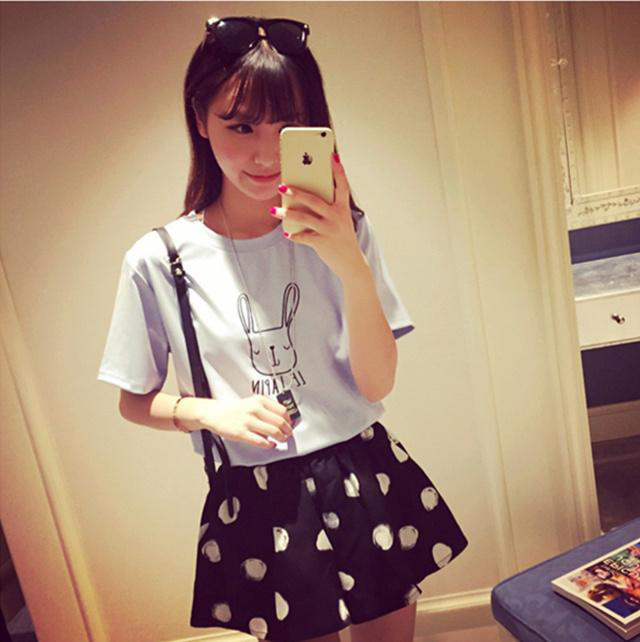

In [21]:
img, _ = dataset_test[10]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [22]:
prediction

[{'boxes': tensor([[ 93.9954, 199.1631, 421.4054, 461.2502],
          [198.9520, 384.0485, 469.1379, 641.8298],
          [191.0011, 411.7347, 459.8268, 637.8473],
          [ 96.6527, 189.6621, 437.5907, 479.1381],
          [175.9861, 389.8755, 502.2752, 642.0000],
          [106.0693, 191.2449, 480.4470, 637.7356]], device='cuda:0'),
  'labels': tensor([ 1,  9,  7,  2,  8, 10], device='cuda:0'),
  'scores': tensor([0.9680, 0.7490, 0.7220, 0.3877, 0.1376, 0.1036], device='cuda:0')}]

tensor([[ 93.9954, 199.1631, 421.4054, 461.2502],
        [198.9520, 384.0485, 469.1379, 641.8298],
        [191.0011, 411.7347, 459.8268, 637.8473],
        [ 96.6527, 189.6621, 437.5907, 479.1381],
        [175.9861, 389.8755, 502.2752, 642.0000],
        [106.0693, 191.2449, 480.4470, 637.7356]], device='cuda:0')


Text(tensor(198.9520, device='cuda:0'), tensor(384.0485, device='cuda:0'), "tensor(9, device='cuda:0')")

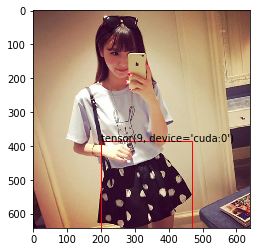

In [23]:

         [[-1.8732e-03]],import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.image import imread
rimg = img.mul(255).permute(1, 2, 0).byte().numpy()
Image.fromarray(rimg)
idx=1
#plt.imshow(rimg)
print(prediction[0]['boxes'])
boxes = prediction[0]['boxes'][idx]
width = boxes[2] - boxes[0]
height = boxes[3] - boxes[1]
rect = patches.Rectangle((boxes[0], boxes[1]), width, height, linewidth=1,
                         edgecolor='r', facecolor='none', label = str(prediction[0]['labels'][idx]))
fig, ax = plt.subplots(1) # Create figure and axes
ax.imshow(rimg)
ax.add_patch(rect) # Add the patch to the Axes
plt.text(boxes[0], boxes[1], str(prediction[0]['labels'][idx]))